# Importación modulos y datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets
from sklearn.preprocessing import normalize

import funciones as f

matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data = pd.read_csv("conchillas_orig.csv", low_memory = False, keep_default_na = False, na_values = '')
print(data.shape)
data.head(5)

(1688, 12)


Lote  Individuo    AE    LE     AT     LT    AA    LA    NV Morfotipo  \
0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28        LU   
1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97        LU   
2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11        LU   
3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44        LU   
4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29        LU   

   Labio cox1-lsu  
0      1       AA  
1      1       HG  
2      1      NaN  
3      0      NaN  
4      1      NaN

# Exploración y limpieza de datos

### Agrupación y dummies

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Lote       1688 non-null   int64  
 1   Individuo  1688 non-null   int64  
 2   AE         1688 non-null   float64
 3   LE         1688 non-null   float64
 4   AT         1688 non-null   float64
 5   LT         1688 non-null   float64
 6   AA         1688 non-null   float64
 7   LA         1688 non-null   float64
 8   NV         1688 non-null   float64
 9   Morfotipo  1688 non-null   object 
 10  Labio      1688 non-null   int64  
 11  cox1-lsu   106 non-null    object 
dtypes: float64(7), int64(3), object(2)
memory usage: 158.4+ KB


In [4]:
# No hay individuos juveniles en el dataset (ancho total menor a 8 milímetros o ausencia de labio)

len(np.logical_or(data.Labio == 1, data.AT >= 8)) == len(data)

True

In [5]:
# Creación de diccionario y reemplazo de haplotipos combinados (105) por haplogrupos (3)
ht = ['AA', 'AB', 'BA', 'CA', 'DA', 'EA', 'FA', 'LA', 'NA', 'OA', 'JH', 'KI', 'GC', 'GD', 'GE', 'GF', 'HG', 'IG', 'MG']
hg = ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '2', '2', '2']
hg_ht_rep = dict(zip(ht, hg))

data["haplogrupos"] = data["cox1-lsu"].replace(hg_ht_rep)

In [6]:
data.iloc[:,2:-3].describe()

AE           LE           AT           LT           AA  \
count  1688.000000  1688.000000  1688.000000  1688.000000  1688.000000   
mean      6.242690     1.763626    13.268957     9.778969     7.692814   
std       0.981426     0.376717     1.942482     1.436368     1.234036   
min       3.120000     0.680000     8.020000     6.050000     4.710000   
25%       5.577500     1.500000    11.777500     8.760000     6.787500   
50%       6.240000     1.760000    13.195000     9.695000     7.590000   
75%       6.892500     2.030000    14.602500    10.845000     8.560000   
max       9.070000     3.150000    19.130000    14.460000    11.970000   

                LA           NV  
count  1688.000000  1688.000000  
mean      6.264846     5.144419  
std       0.914297     0.298324  
min       4.210000     4.000000  
25%       5.600000     4.950000  
50%       6.140000     5.175000  
75%       6.800000     5.340000  
max       9.770000     5.970000

In [7]:
round(data['Morfotipo'].value_counts(normalize = True)*100, 2)
data['haplogrupos'].value_counts()
data['cox1-lsu'].value_counts()

LU    86.02
LB    13.27
DU     0.71
Name: Morfotipo, dtype: float64

0    85
2    12
1     9
Name: haplogrupos, dtype: int64

AA    68
HG    10
BA     3
GF     3
LA     3
GC     3
CA     2
OA     2
GE     2
KI     1
GD     1
NA     1
JH     1
IG     1
MG     1
FA     1
DA     1
EA     1
AB     1
Name: cox1-lsu, dtype: int64

In [8]:
data = pd.get_dummies(data, columns = ["Morfotipo"], drop_first = True)
data.head(5)

Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  Labio  \
0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28      1   
1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97      1   
2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11      1   
3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44      0   
4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29      1   

  cox1-lsu haplogrupos  Morfotipo_LB  Morfotipo_LU  
0       AA           0             0             1  
1       HG           2             0             1  
2      NaN         NaN             0             1  
3      NaN         NaN             0             1  
4      NaN         NaN             0             1

### Creación columnas nuevas

In [9]:
# Ratios
# Cada parte sobre sí misma
data["Ratio_LE_AE"] = data["LE"]/data["AE"] # Espira
data["Ratio_LT_AT"] = data["LT"]/data["AT"] # Total
data["Ratio_LA_AA"] = data["LA"]/data["AA"] # Abertura

# Espira / Total
data["Ratio_LE_LT"] = data["LE"]/data["LT"] # Largo
data["Ratio_AE_AT"] = data["AE"]/data["AT"] # Ancho

# Abertura / Total
data["Ratio_LA_LT"] = data["LA"]/data["LT"] # Largo
data["Ratio_AA_AT"] = data["AA"]/data["AT"] # Ancho

# Espira / Abertura
data["Ratio_LE_LA"] = data["LE"]/data["LA"] # Largo
data["Ratio_AE_AA"] = data["AE"]/data["AA"] # Ancho

data.head(5)

Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  Labio  ...  \
0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28      1  ...   
1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97      1  ...   
2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11      1  ...   
3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44      0  ...   
4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29      1  ...   

  Morfotipo_LU Ratio_LE_AE  Ratio_LT_AT  Ratio_LA_AA  Ratio_LE_LT  \
0            1    0.366776     0.747684     0.860321     0.212583   
1            1    0.261101     0.713672     0.918495     0.177108   
2            1    0.288274     0.722585     0.742092     0.177889   
3            1    0.333333     0.785593     0.754573     0.237325   
4            1    0.369028     0.755764     0.849034     0.213537   

   Ratio_AE_AT  Ratio_LA_LT  Ratio_AA_AT  Ratio_LE_LA  Ratio_AE_AA  
0     0.433357     0.663489     0.576622     0.320402     0.751545  
1     0.484093     0.706024     0.548581     0.250853     0.882445  
2     0.445897     0.613065     0.596950     0.290164     0.746959  
3     0.559322     0.533981     0.555932     0.444444     1.006098  
4     0.437320     0.670162     0.596542     0.318634     0.733092  

[5 rows x 23 columns]

In [10]:
# Powers
potencia = 4

# Espira
data["Power_LE"] = data["LE"] ** potencia # Largo
data["Power_AE"] = data["AE"] ** potencia # Ancho

# Total
data["Power_LT"] = data["LT"] ** potencia # Largo
data["Power_AT"] = data["AT"] ** potencia # Ancho

# Abertura
data["Power_LA"] = data["LA"] ** potencia # Largo
data["Power_AA"] = data["AA"] ** potencia # Ancho

# Número de vueltas
data["Power_NV"] = data["NV"] ** potencia

data.head(5)

Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  Labio  ...  \
0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28      1  ...   
1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97      1  ...   
2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11      1  ...   
3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44      0  ...   
4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29      1  ...   

  Ratio_AA_AT Ratio_LE_LA  Ratio_AE_AA   Power_LE     Power_AE      Power_LT  \
0    0.576622    0.320402     0.751545  24.729734  1366.514729  12108.823608   
1    0.548581    0.250853     0.882445   4.669489  1004.693470   4745.832100   
2    0.596950    0.290164     0.746959   9.815062  1421.259840   9801.495006   
3    0.555932    0.444444     1.006098  23.425600  1897.473600   7384.463302   
4    0.596542    0.318634     0.733092  25.176310  1357.546656  12108.823608   

       Power_AT     Power_LA     Power_AA    Power_NV  
0  38746.339913  2346.588611  4283.453794  777.205187  
1  18294.428998  1179.208128  1656.848179  610.134461  
2  35953.051846  1384.584100  4565.488679  681.841766  
3  19387.777600   600.372506  1851.890729  875.781161  
4  37115.717839  2442.425357  4700.254211  783.109853  

[5 rows x 30 columns]

In [11]:
# Power_ratios
# (Cada parte sobre sí misma) ** potencia
data["Power_Ratio_LE_AE"] = data["Ratio_LE_AE"] ** potencia # Espira
data["Power_Ratio_LT_AT"] = data["Ratio_LT_AT"] ** potencia # Total
data["Power_Ratio_LA_AA"] = data["Ratio_LA_AA"] ** potencia # Abertura

# (Espira / Total) ** potencia
data["Power_Ratio_LE_LT"] = data["Ratio_LE_LT"] ** potencia # Largo
data["Power_Ratio_AE_AT"] = data["Ratio_AE_AT"] ** potencia # Ancho

# (Abertura / Total) ** potencia
data["Power_Ratio_LA_LT"] = data["Ratio_LA_LT"] ** potencia # Largo
data["Power_Ratio_AA_AT"] = data["Ratio_AA_AT"] ** potencia # Ancho

# (Espira / Abertura) ** potencia
data["Power_Ratio_LE_LA"] = data["Ratio_LE_LA"] ** potencia # Largo
data["Power_Ratio_AE_AA"] = data["Ratio_AE_AA"] ** potencia # Ancho

In [12]:
data.columns

Index(['Lote', 'Individuo', 'AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV', 'Labio',
       'cox1-lsu', 'haplogrupos', 'Morfotipo_LB', 'Morfotipo_LU',
       'Ratio_LE_AE', 'Ratio_LT_AT', 'Ratio_LA_AA', 'Ratio_LE_LT',
       'Ratio_AE_AT', 'Ratio_LA_LT', 'Ratio_AA_AT', 'Ratio_LE_LA',
       'Ratio_AE_AA', 'Power_LE', 'Power_AE', 'Power_LT', 'Power_AT',
       'Power_LA', 'Power_AA', 'Power_NV', 'Power_Ratio_LE_AE',
       'Power_Ratio_LT_AT', 'Power_Ratio_LA_AA', 'Power_Ratio_LE_LT',
       'Power_Ratio_AE_AT', 'Power_Ratio_LA_LT', 'Power_Ratio_AA_AT',
       'Power_Ratio_LE_LA', 'Power_Ratio_AE_AA'],
      dtype='object')

### Relación entre variables

In [13]:
Medidas = ['AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV', 'Morfotipo_LB', 'Morfotipo_LU']
Ratios = ['Ratio_LE_AE', 'Ratio_LT_AT', 'Ratio_LA_AA', 'Ratio_LE_LT', 'Ratio_AE_AT', 'Ratio_LA_LT', 'Ratio_AA_AT', 'Ratio_LE_LA', 'Ratio_AE_AA', 'Morfotipo_LB', 'Morfotipo_LU']
Powers = ['Power_LE', 'Power_AE', 'Power_LT', 'Power_AT', 'Power_LA', 'Power_AA', 'Power_NV', 'Morfotipo_LB', 'Morfotipo_LU']
Powers_ratios = ['Power_Ratio_LE_AE', 'Power_Ratio_LT_AT', 'Power_Ratio_LA_AA', 'Power_Ratio_LE_LT', 'Power_Ratio_AE_AT', 'Power_Ratio_LA_LT', 'Power_Ratio_AA_AT', 'Power_Ratio_LE_LA', 'Power_Ratio_AE_AA', 'Morfotipo_LB', 'Morfotipo_LU']
Todo = Medidas + Ratios + Powers + Powers_ratios
Todo = list(dict.fromkeys(Todo)) #para eliminar elementos duplicados de una lista
print(Todo)

['AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV', 'Morfotipo_LB', 'Morfotipo_LU', 'Ratio_LE_AE', 'Ratio_LT_AT', 'Ratio_LA_AA', 'Ratio_LE_LT', 'Ratio_AE_AT', 'Ratio_LA_LT', 'Ratio_AA_AT', 'Ratio_LE_LA', 'Ratio_AE_AA', 'Power_LE', 'Power_AE', 'Power_LT', 'Power_AT', 'Power_LA', 'Power_AA', 'Power_NV', 'Power_Ratio_LE_AE', 'Power_Ratio_LT_AT', 'Power_Ratio_LA_AA', 'Power_Ratio_LE_LT', 'Power_Ratio_AE_AT', 'Power_Ratio_LA_LT', 'Power_Ratio_AA_AT', 'Power_Ratio_LE_LA', 'Power_Ratio_AE_AA']


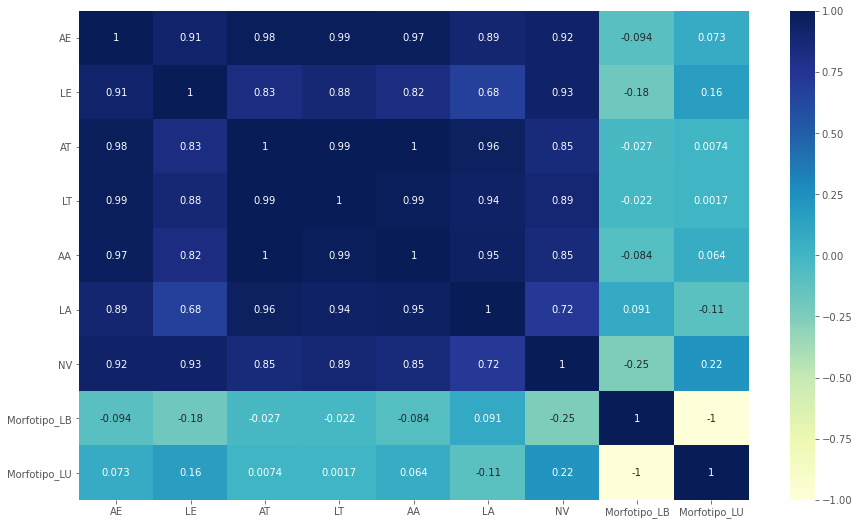

In [14]:
#variables originales del dataset
f._print_matriz_correlacion(data[Medidas].corr())

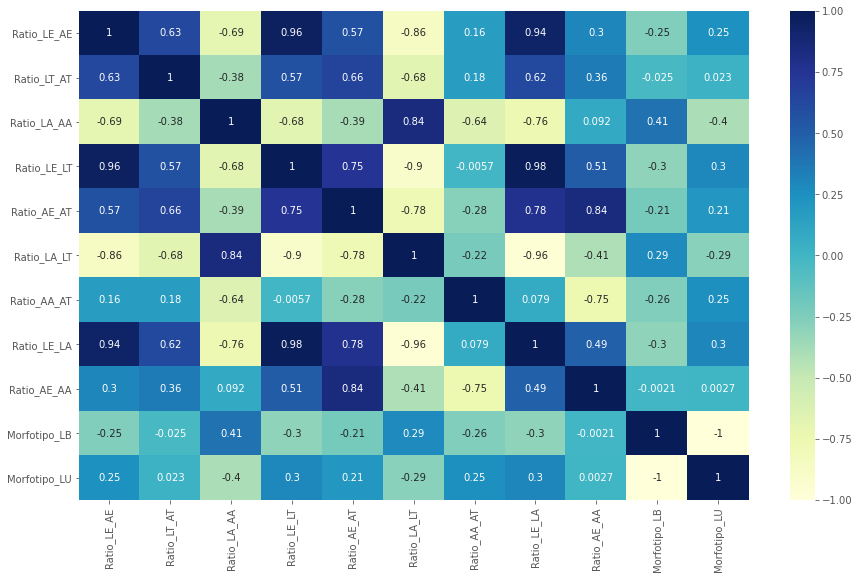

In [15]:
#variables originales del dataset
f._print_matriz_correlacion(data[Ratios].corr())

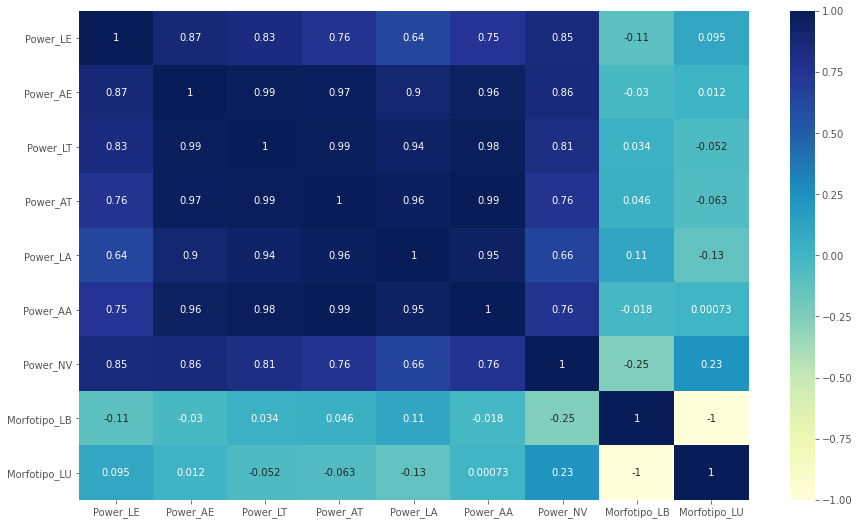

In [16]:
#variables originales del dataset
f._print_matriz_correlacion(data[Powers].corr())

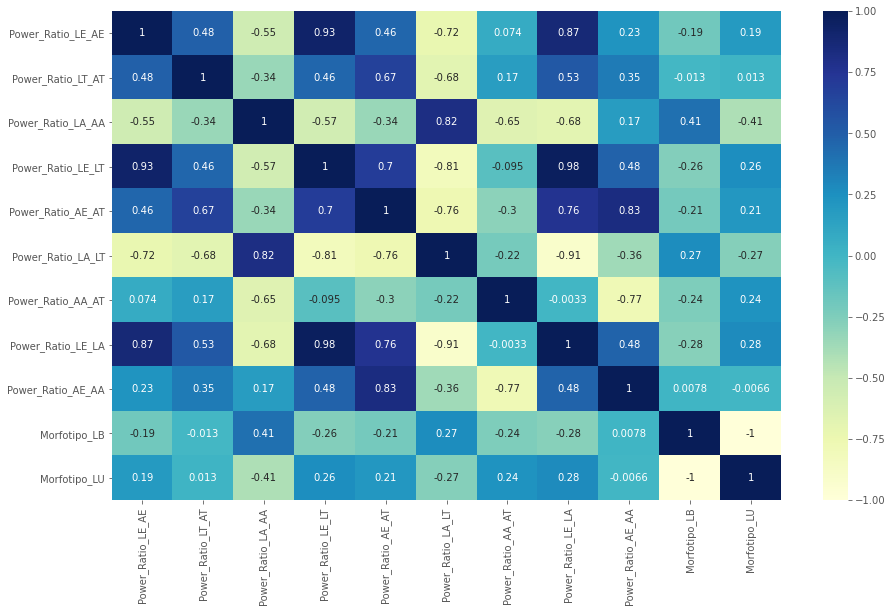

In [17]:
#variables originales del dataset
f._print_matriz_correlacion(data[Powers_ratios].corr())

In [18]:
# sns.pairplot(data=data,x_vars = Medidas,\
#          y_vars= Medidas,hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

In [19]:
# sns.pairplot(data=data,x_vars = Ratios,\
#          y_vars= Ratios,hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

In [20]:
# sns.pairplot(data=data,x_vars = Powers,\
#          y_vars= Powers,hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

In [21]:
# sns.pairplot(data=data,x_vars = Powers_ratios,\
#          y_vars= Powers_ratios,hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

In [22]:
#sns.pairplot(data=data,x_vars = Todo,\
#         y_vars= Todo,hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

### Distribución de las observaciones

In [23]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 9))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()

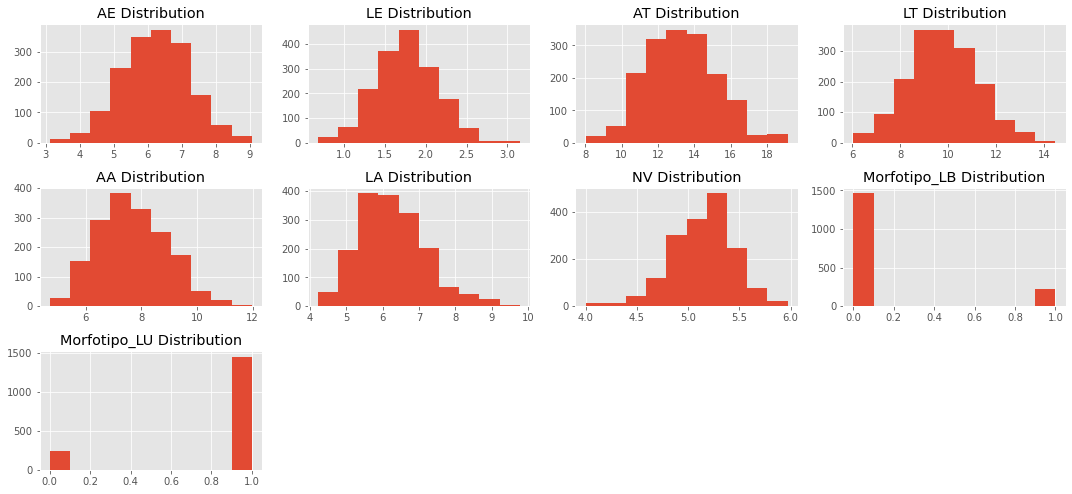

In [24]:
draw_histograms(data, data[Medidas], 4, 4)

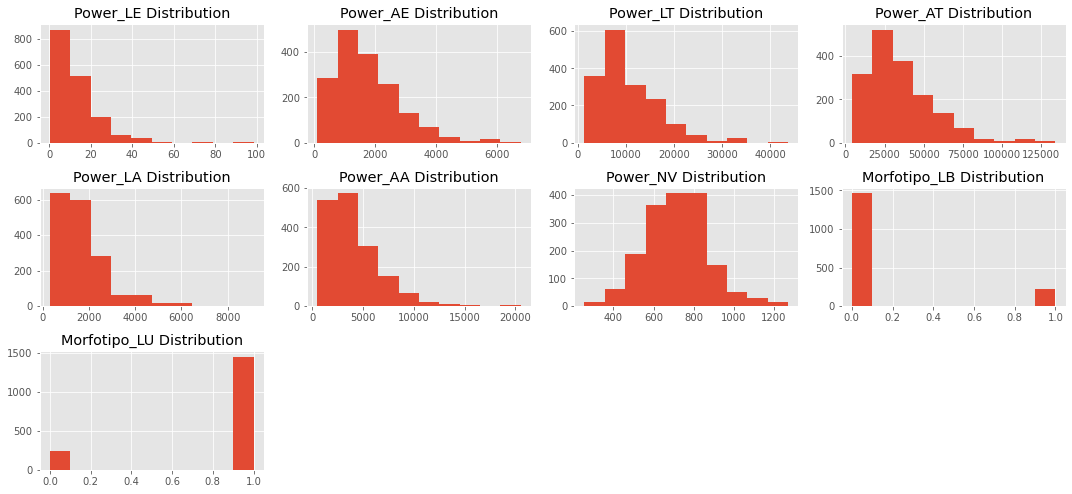

In [25]:
draw_histograms(data, data[Powers], 4, 4)

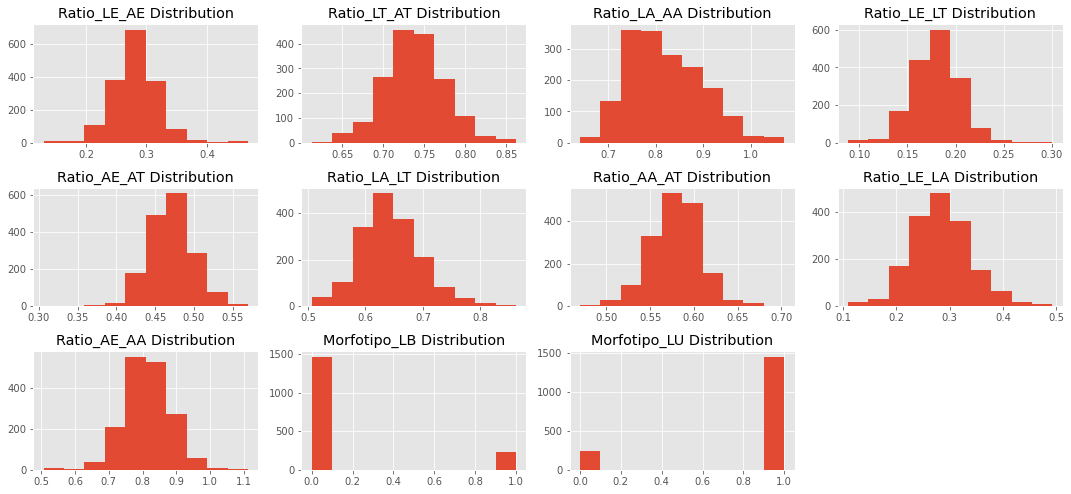

In [26]:
draw_histograms(data, data[Ratios], 4, 4)

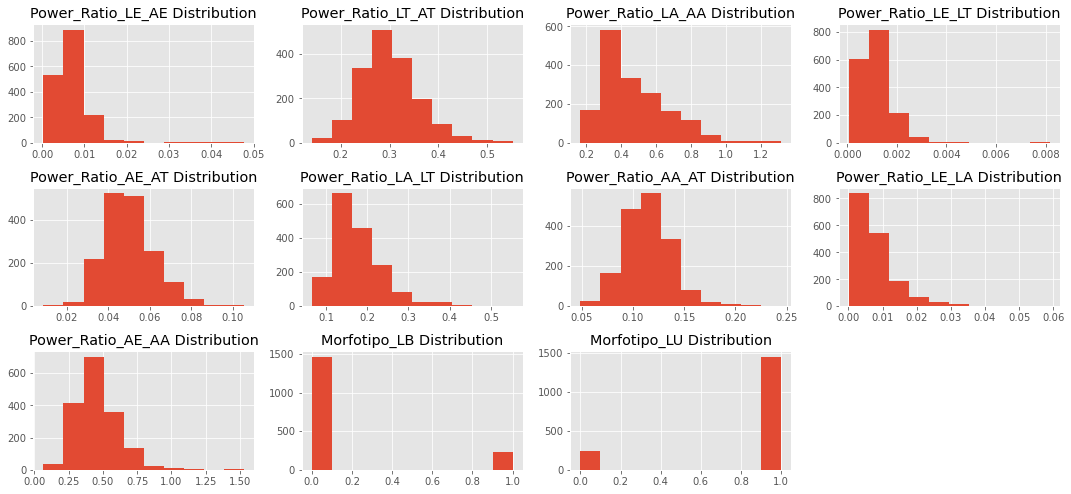

In [27]:
draw_histograms(data, data[Powers_ratios], 4, 4)

# Modelos de clustering

In [28]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score,calinski_harabasz_score
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.cm as cm

## KMEANS

### Variables

In [29]:
x1 = data[Medidas]
x2 = data[Powers]
x3 = data[Ratios]
x4 = data[Powers_ratios]
x5 = data[Todo]
y_true = data["haplogrupos"]

scaler = StandardScaler()
x1_scaled=scaler.fit_transform(x1)
x2_scaled=scaler.fit_transform(x2)
x3_scaled=scaler.fit_transform(x3)
x4_scaled=scaler.fit_transform(x4)
x5_scaled=scaler.fit_transform(x5)


### Numero de clusters por SQ distance

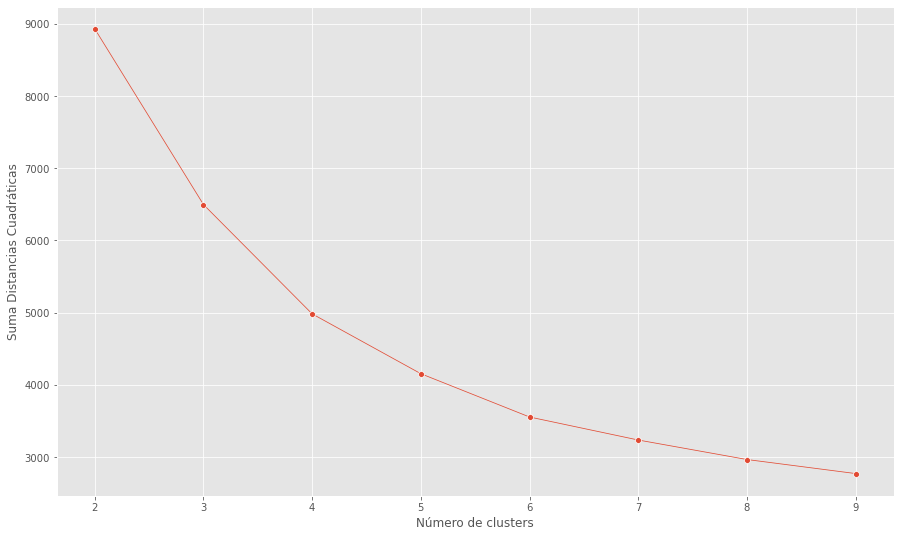

In [30]:
#x1_scaled medidas
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x1_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

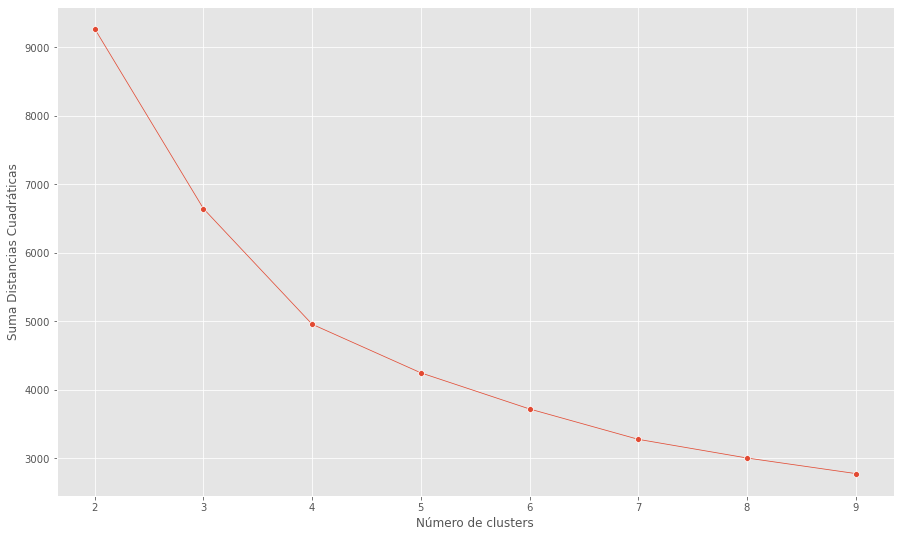

In [31]:
#x2_scaled powers
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x2_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

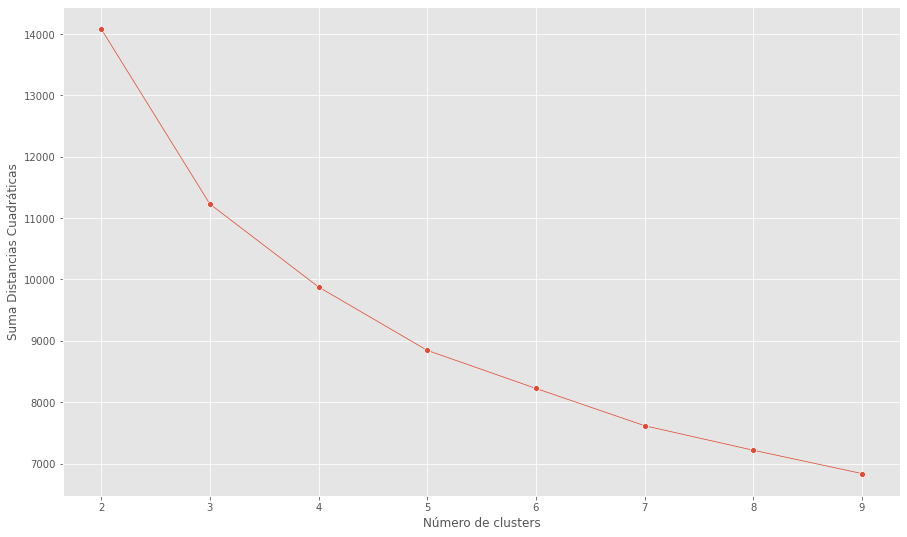

In [32]:
#x3_scaled ratios
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x3_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

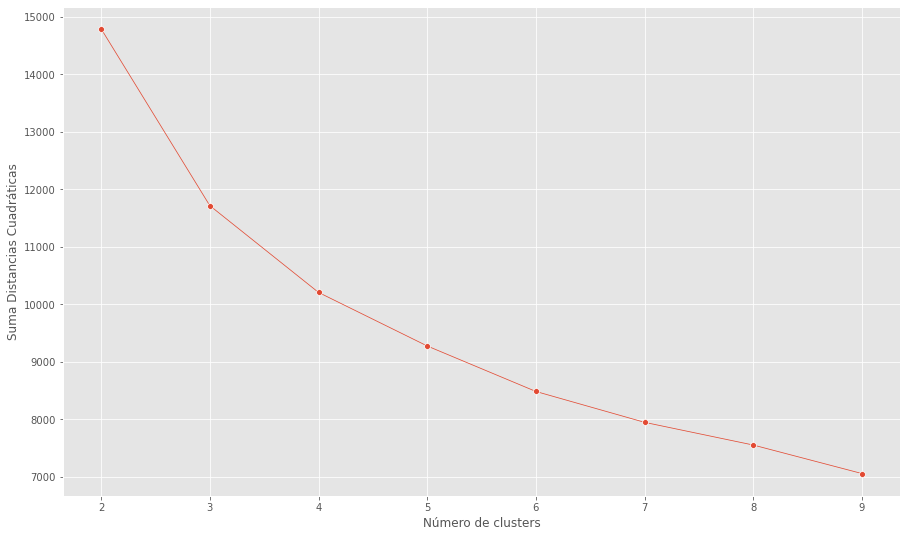

In [33]:
#x4_scaled powers ratios
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x4_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

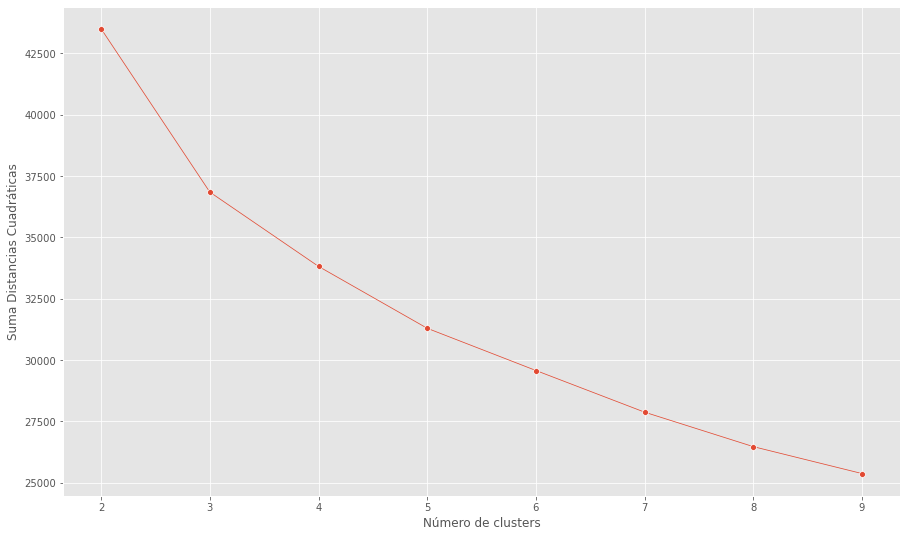

In [34]:
#x5_scaled todo
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x5_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

### Numero de clusters por silohuette score

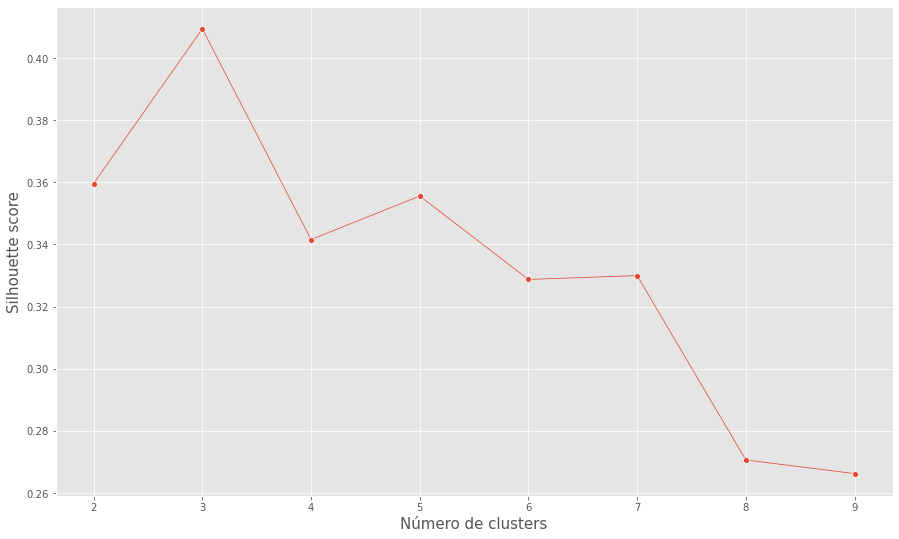

In [35]:
#x1_scaled medidas
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x1_scaled)
    score=silhouette_score(x1_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

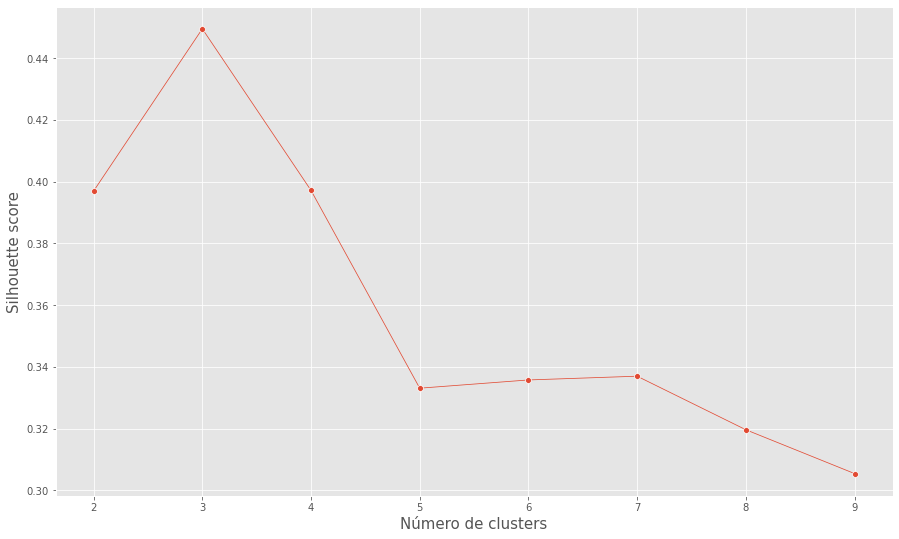

In [36]:
#x2_scaled powers
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x2_scaled)
    score=silhouette_score(x2_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

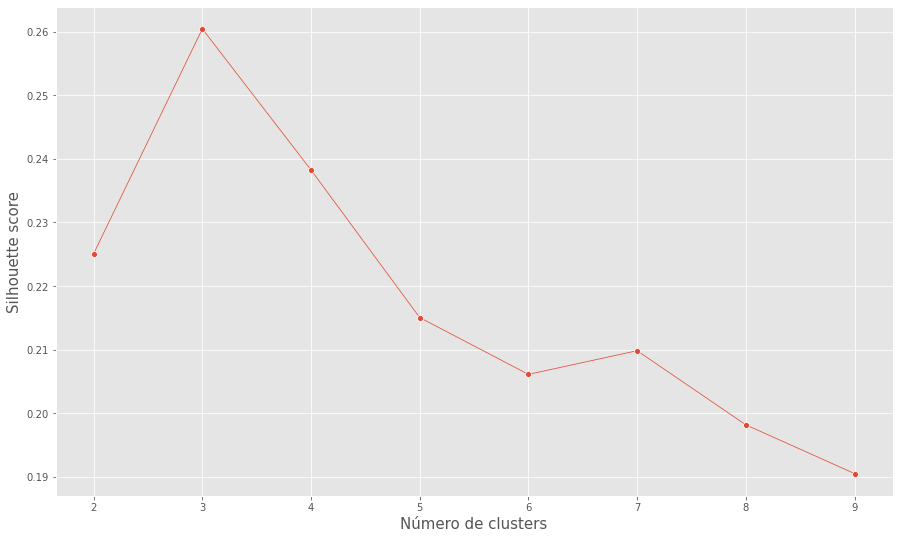

In [37]:
#x3_scaled ratios
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x3_scaled)
    score=silhouette_score(x3_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

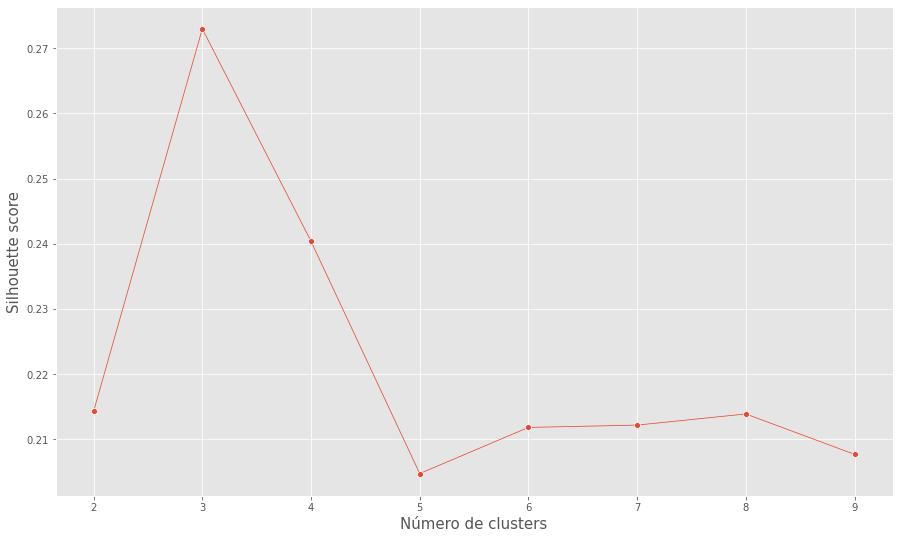

In [38]:
#x4_scaled power ratios
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x4_scaled)
    score=silhouette_score(x4_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

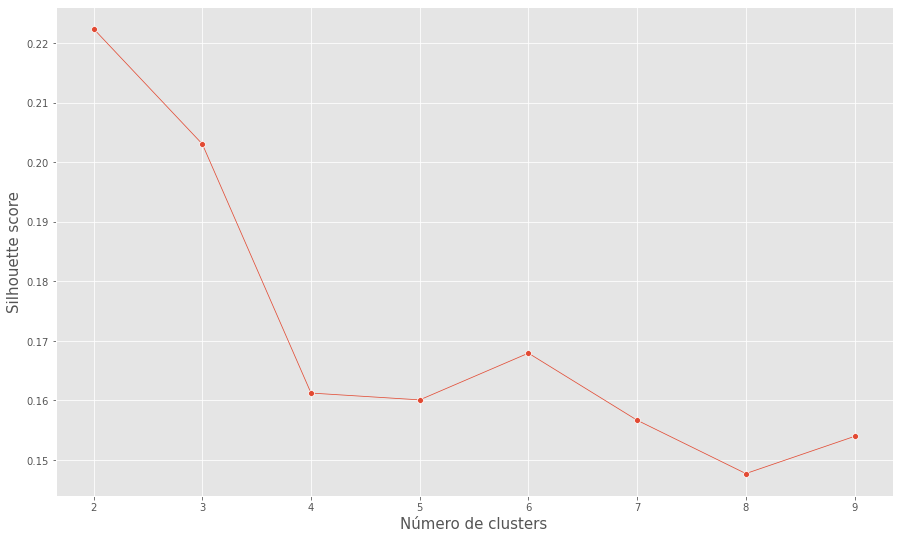

In [39]:
#x5_scaled todo
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x5_scaled)
    score=silhouette_score(x5_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

### Kmeans 

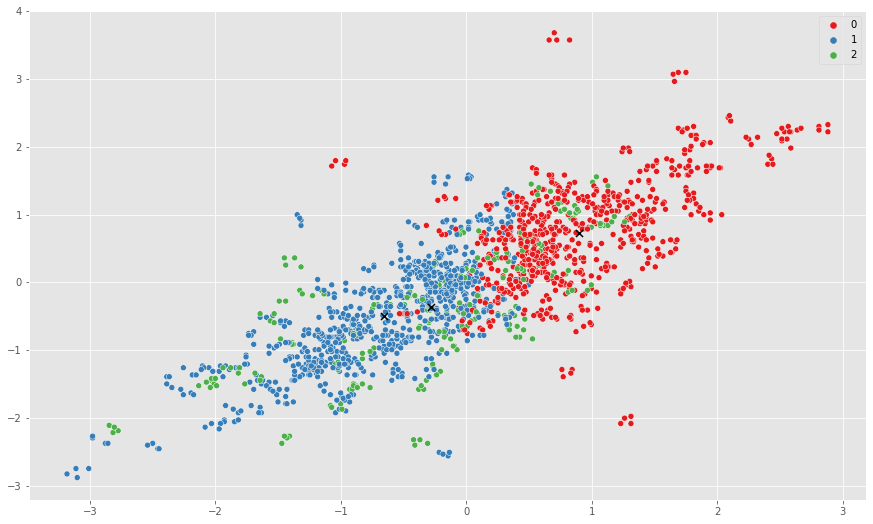

In [40]:
#x1_scaled medidas
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x1_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x1_scaled[:,0],y=x1_scaled[:,1],hue=labels,legend='full', palette = 'Set1');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

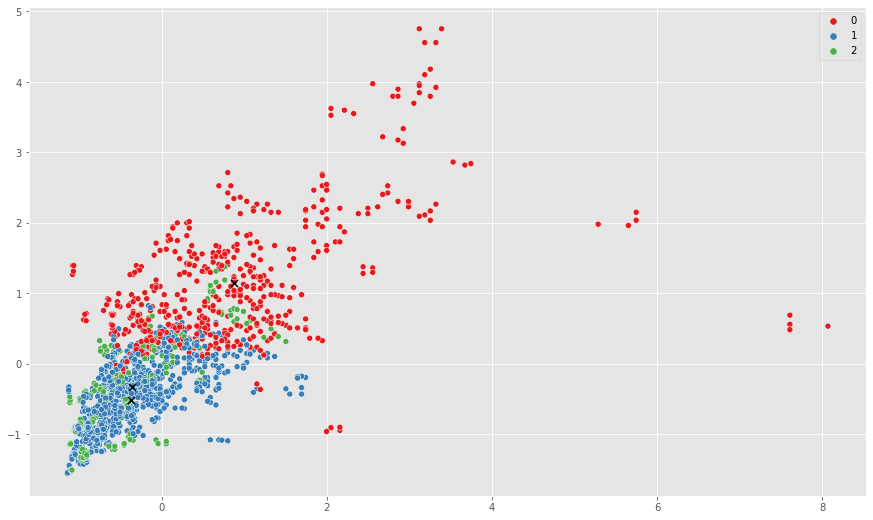

In [41]:
#x2_scaled powers
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x2_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x2_scaled[:,0],y=x2_scaled[:,1],hue=labels,legend='full', palette = 'Set1');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

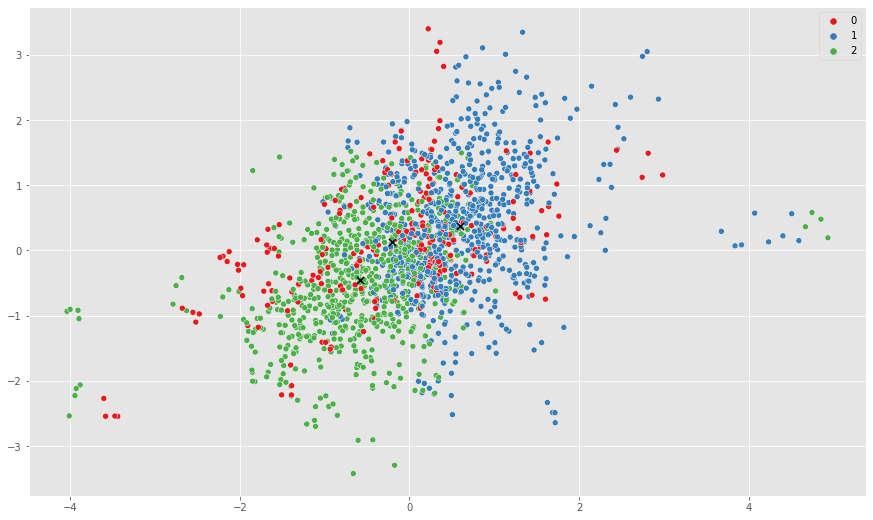

In [42]:
#x3_scaled ratios
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x3_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x3_scaled[:,0],y=x3_scaled[:,1],hue=labels,legend='full', palette = 'Set1');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

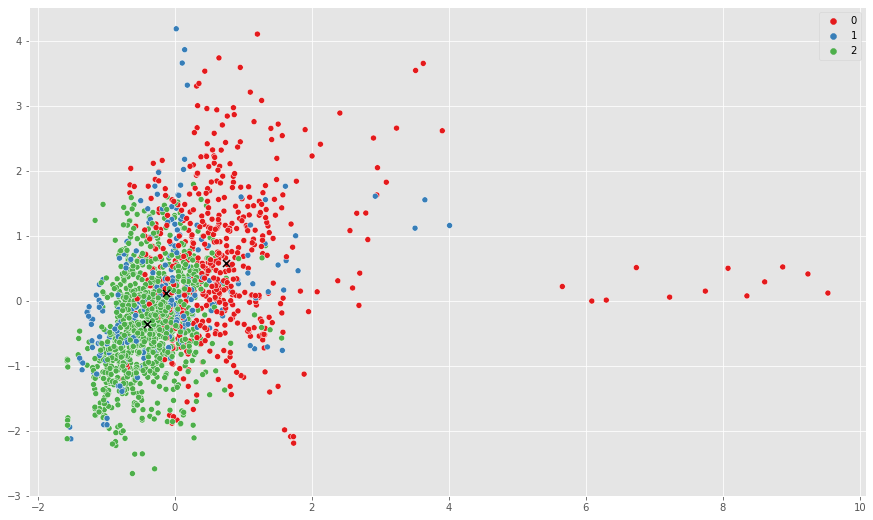

In [43]:
#x4_scaled powers ratios
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x4_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x4_scaled[:,0],y=x4_scaled[:,1],hue=labels,legend='full', palette = 'Set1');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

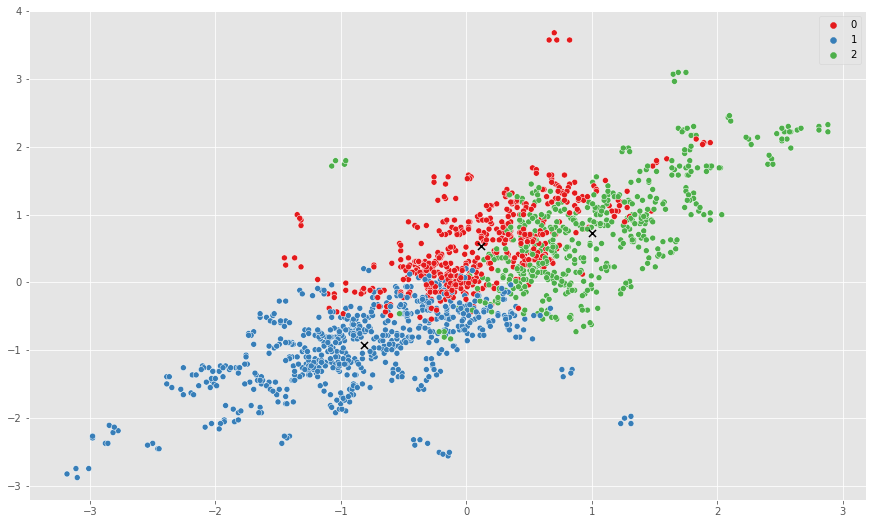

In [44]:
#x5_scaled todo
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x5_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x5_scaled[:,0],y=x5_scaled[:,1],hue=labels,legend='full', palette="Set1");

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

### Comparación True labels vs Kmeans

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

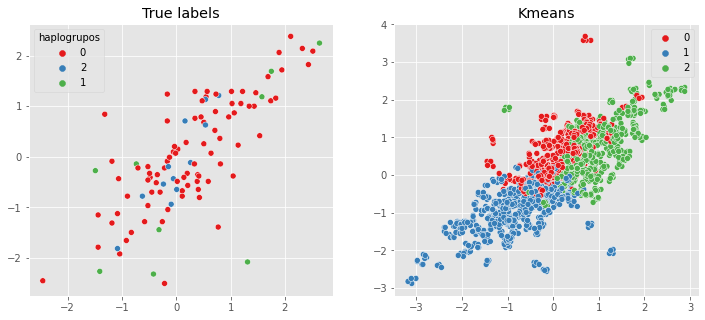

In [45]:
#x1_scaled medidas
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x1_scaled[:,0], y = x1_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x1_scaled[:,0], y = x1_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

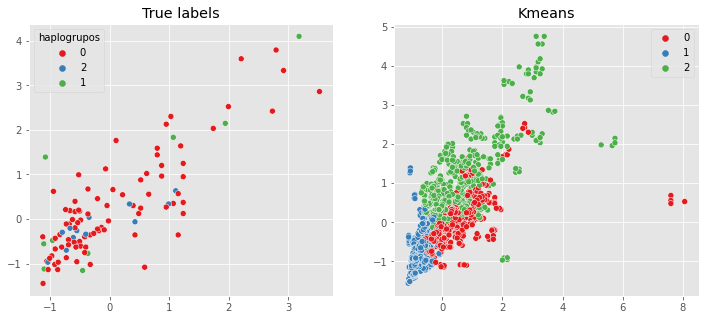

In [46]:
#x2_scaled powers
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x2_scaled[:,0], y = x2_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x2_scaled[:,0], y = x2_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

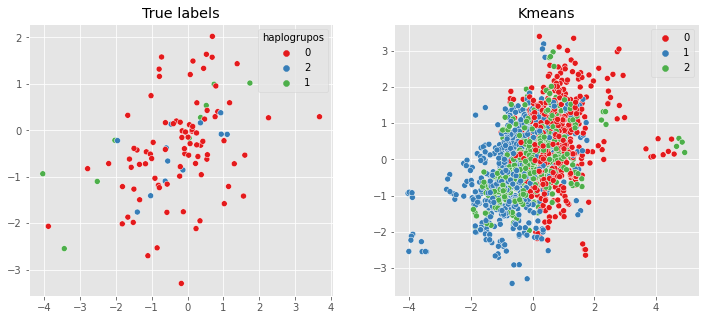

In [47]:
#x3_scaled ratios
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x3_scaled[:,0], y = x3_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x3_scaled[:,0], y = x3_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

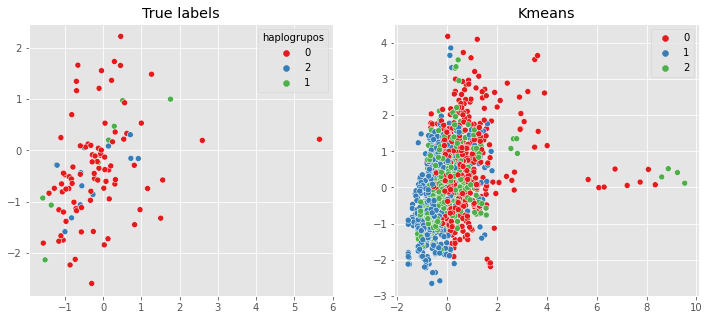

In [48]:
#x4_scaled powers ratios
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x4_scaled[:,0], y = x4_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x4_scaled[:,0], y = x4_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

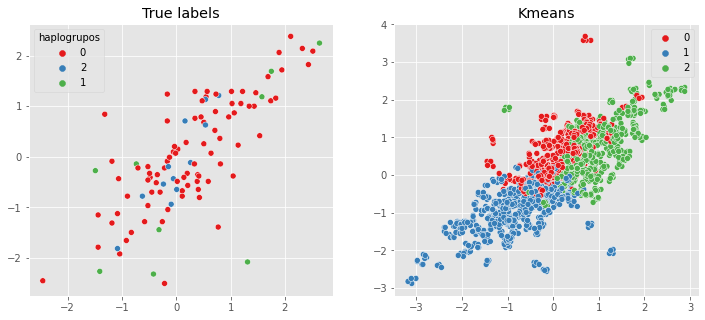

In [49]:
#x5_scaled todos
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')



<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

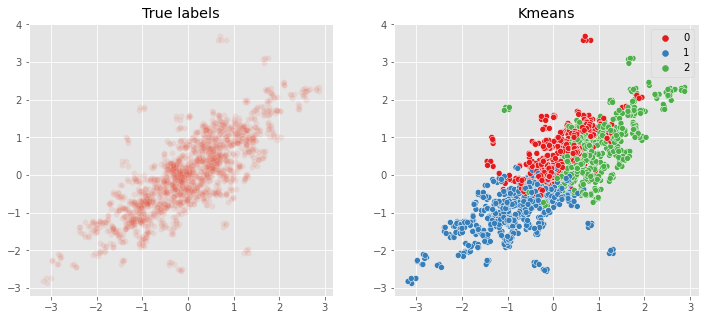

In [50]:
#x5_scaled todos (agregamos alpha)
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],ax=ax[0], alpha=0.1)
#sns.scatterplot(x = x_scaled[indices,0], y = x_scaled[indices,1],hue=y_true[y_true!="0"],ax=ax[0], palette="magma")
ax[0].set_title('True labels')
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

In [51]:
#sns.heatmap(confusion_matrix(y_true,labels),annot=True,cmap='Blues',fmt=".0f");

#print(classification_report(y_true,labels))

## DBSCAN

In [52]:
from scipy.spatial.distance import pdist,squareform

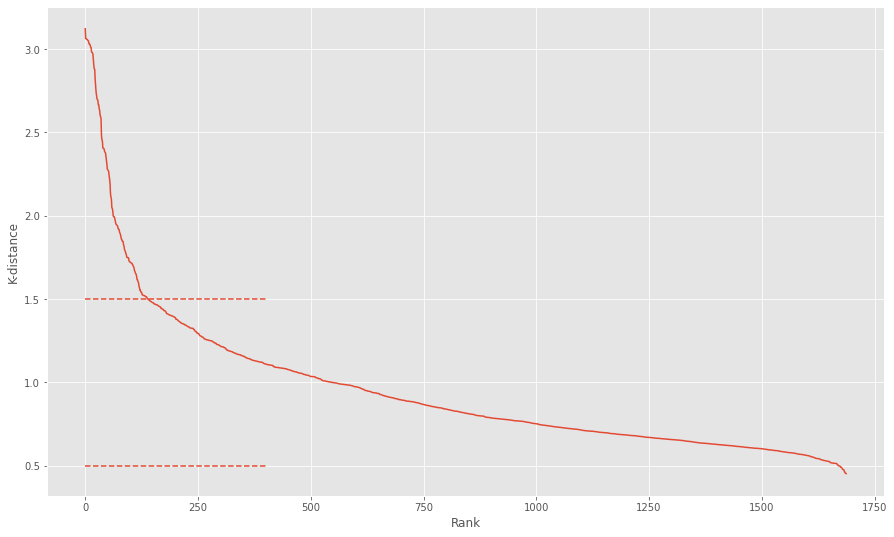

In [53]:
#x1_scaled medidas
minPts=20;
k=minPts-1;

D=squareform(pdist(x1_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([0.5,1.5],0,400,linestyles='dashed');

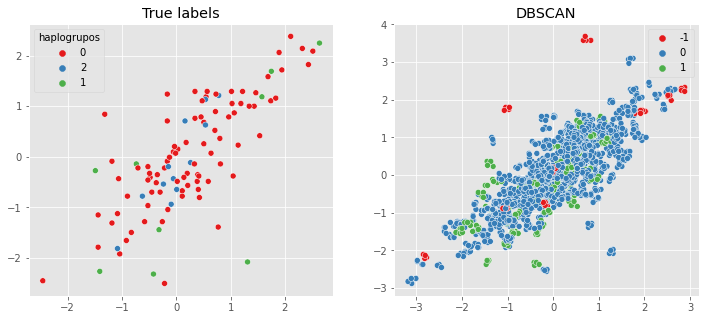

In [54]:
#x1_scaled medidas
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x1_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x1_scaled[:,0], y = x1_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x1_scaled[:,0], y = x1_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN');


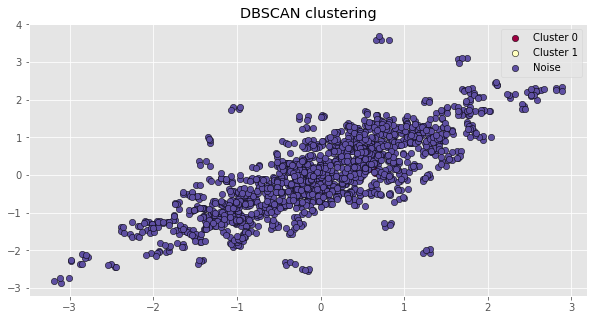

In [55]:
#x1_scaled medidas
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x1_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x1_scaled[labels==l,0], x1_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x1_scaled[labels==l,0], x1_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');
    

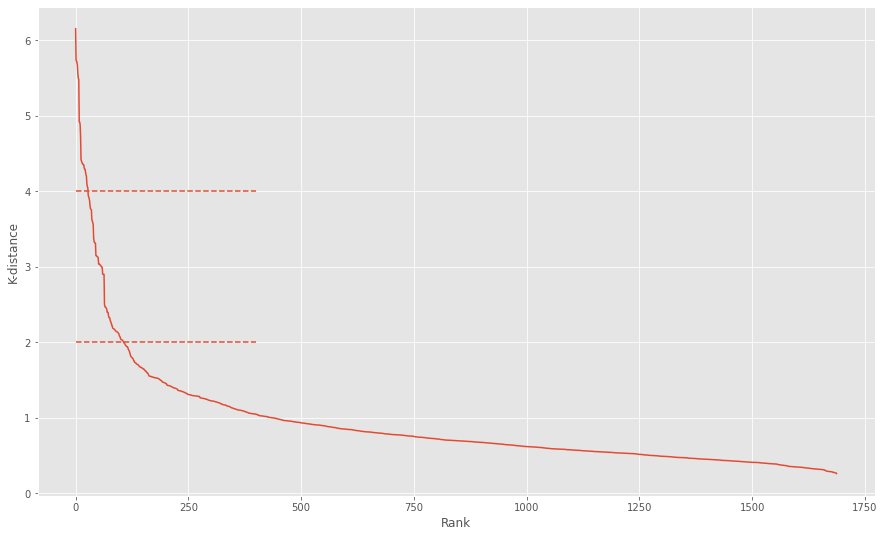

In [56]:
#x2_scaled powers
minPts=20;
k=minPts-1;

D=squareform(pdist(x2_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([2,4],0,400,linestyles='dashed');

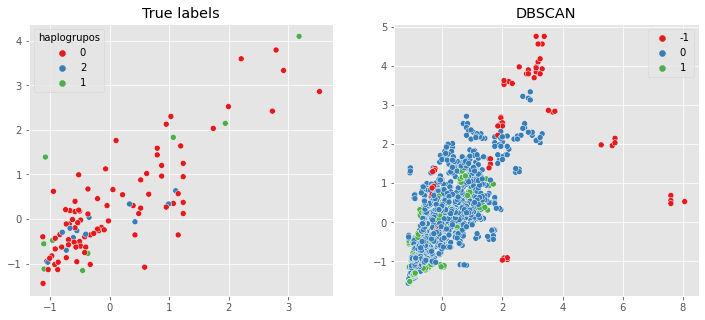

In [57]:
#x2_scaled powers
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x2_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x2_scaled[:,0], y = x2_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x2_scaled[:,0], y = x2_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN');

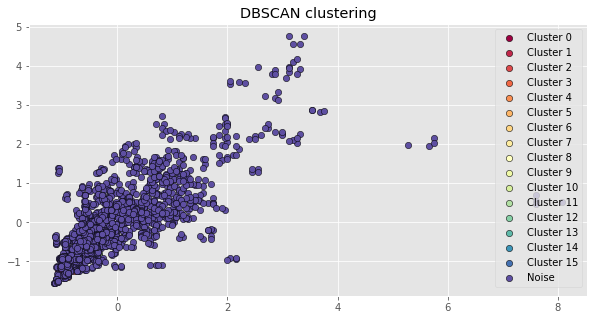

In [58]:
#x2_scaled medidas
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x2_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x2_scaled[labels==l,0], x2_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x2_scaled[labels==l,0], x2_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');

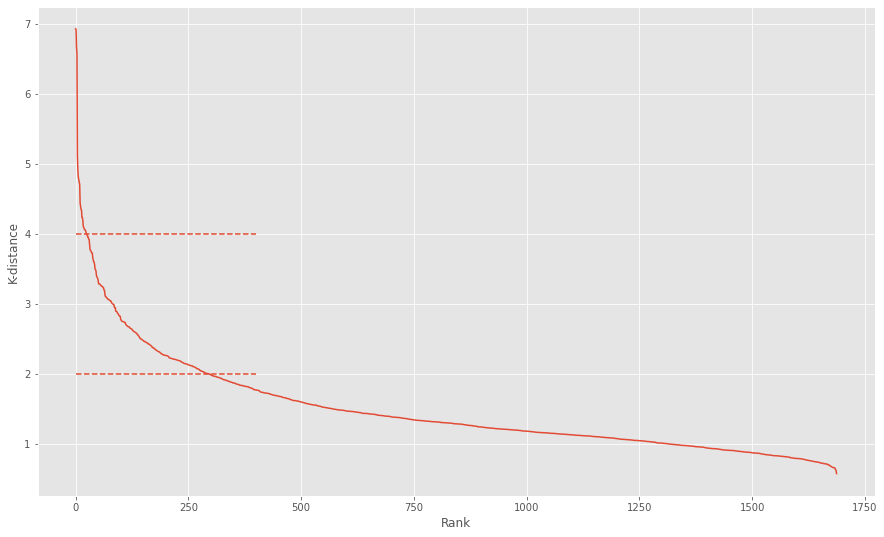

In [59]:
#x3_scaled ratios
minPts=20;
k=minPts-1;

D=squareform(pdist(x3_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([2,4],0,400,linestyles='dashed');

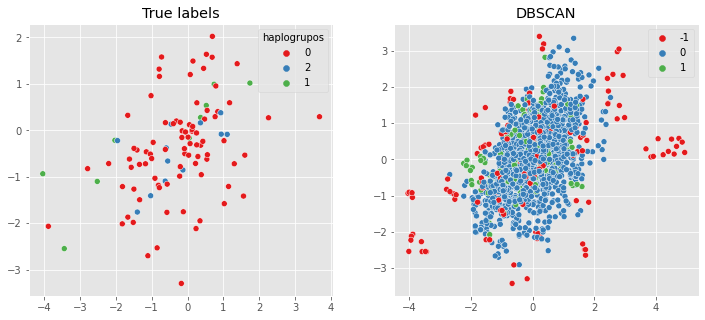

In [60]:
#x3_scaled ratios
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x3_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x3_scaled[:,0], y = x3_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x3_scaled[:,0], y = x3_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN');

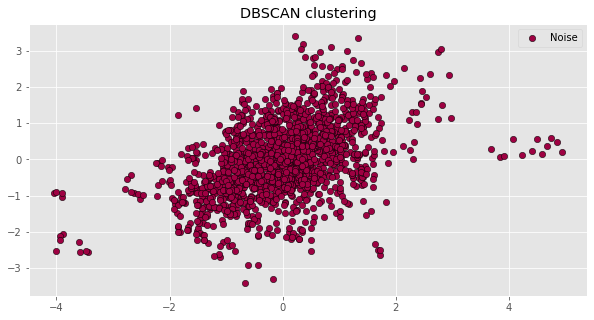

In [61]:
#x3_scaled ratios
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x3_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x3_scaled[labels==l,0], x3_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x3_scaled[labels==l,0], x3_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');

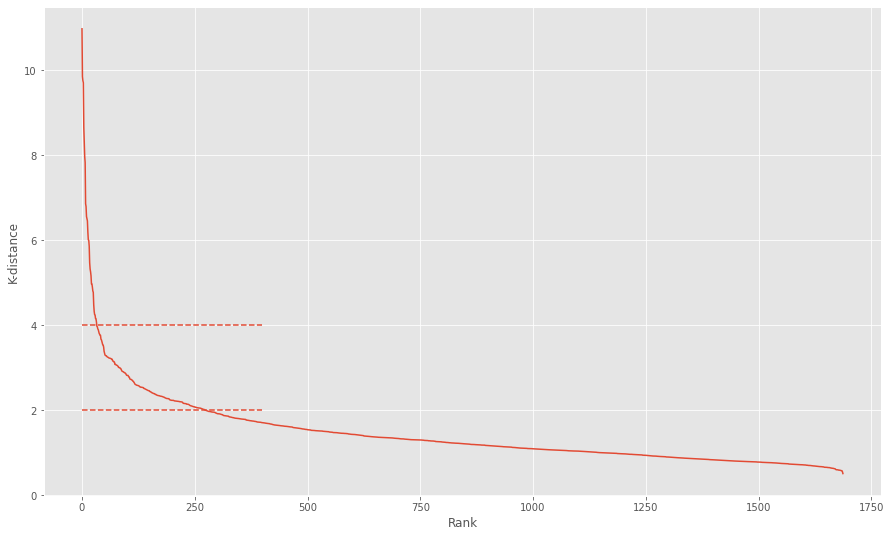

In [62]:
#x4_scaled power ratios
minPts=20;
k=minPts-1;

D=squareform(pdist(x4_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([2,4],0,400,linestyles='dashed');

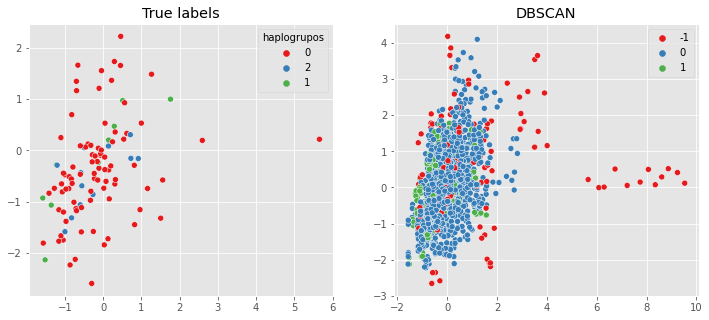

In [63]:
#x4_scaled power ratios
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x4_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x4_scaled[:,0], y = x4_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x4_scaled[:,0], y = x4_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN');

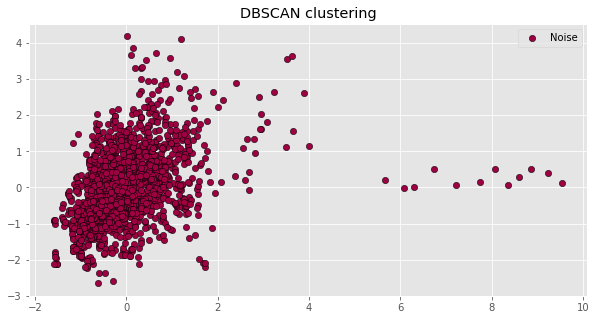

In [64]:
#x4_scaled powers ratios
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x4_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x4_scaled[labels==l,0], x4_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x4_scaled[labels==l,0], x4_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');

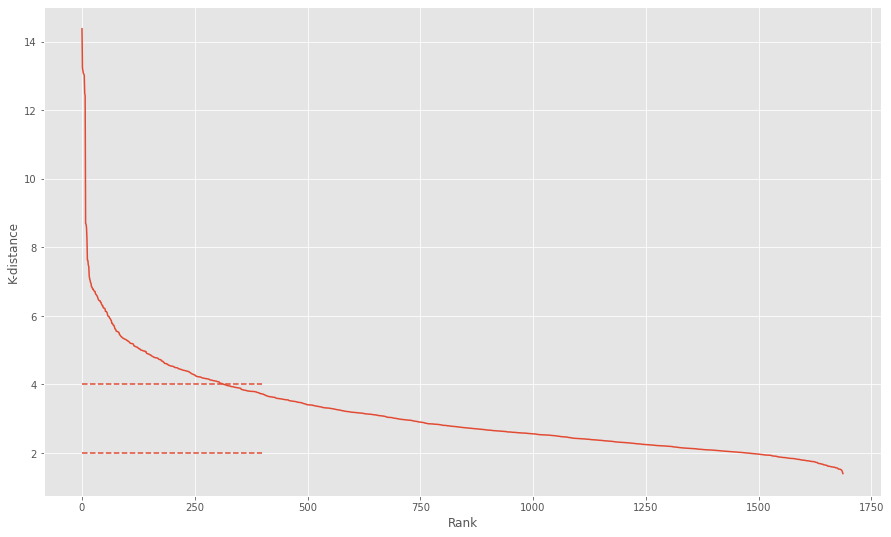

In [65]:
#x5_scaled todos
minPts=20;
k=minPts-1;

D=squareform(pdist(x5_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([2,4],0,400,linestyles='dashed');

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'DBSCAN')

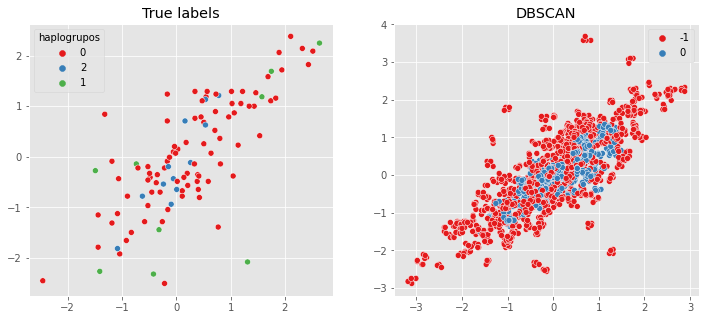

In [66]:
#x5_scaled todos
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x5_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN')

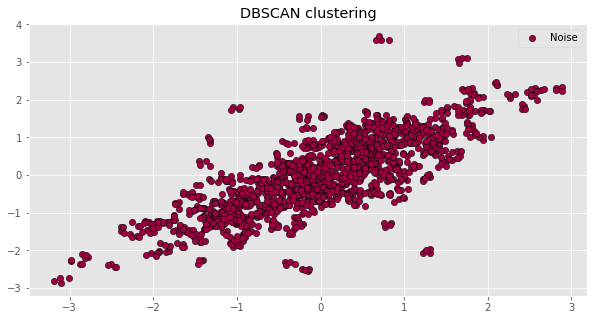

In [67]:
#x5_scaled todos
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x5_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x5_scaled[labels==l,0], x5_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x5_scaled[labels==l,0], x5_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');

# Modelos reducción dimensionalidad

## Prueba PCA

In [68]:
from sklearn.decomposition import PCA

### Data frames

In [69]:
df_x1 = pd.DataFrame(x1_scaled)
df_x2 = pd.DataFrame(x2_scaled)
df_x3 = pd.DataFrame(x3_scaled)
df_x4 = pd.DataFrame(x4_scaled)
df_x5 = pd.DataFrame(x5_scaled)

In [70]:
pca_1 = PCA().fit(df_x1)
pca_2 = PCA().fit(df_x2)
pca_3 = PCA().fit(df_x3)
pca_4 = PCA().fit(df_x4)
pca_5 = PCA().fit(df_x5)

### Pesos (loadings)

In [71]:
#x1 medidas
#Creamos un DataFrame con los loadings.
loadings_1 = pd.DataFrame(pca_1.components_.T, index=df_x1.columns, columns = ['PC' + str(x+1) for x in range(0, len(pca_1.components_.T[0]))])
loadings_1

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.401108  0.002964 -0.088953  0.050613 -0.151504 -0.795708  0.047696   
1  0.336554 -0.053072 -0.604906  0.585563  0.265920  0.240136  0.213225   
2  0.401806  0.044061  0.225250  0.034191 -0.314269 -0.095487  0.432310   
3  0.409534  0.045337  0.046567  0.122126  0.019045  0.008085 -0.824665   
4  0.391797  0.012194  0.254054  0.037390 -0.511167  0.524678  0.024623   
5  0.351494  0.104381  0.524742 -0.068194  0.732193  0.057296  0.158837   
6  0.344338 -0.084260 -0.461553 -0.793037  0.091453  0.140441  0.024735   
7 -0.021860  0.698766 -0.095491  0.006874 -0.015253 -0.012856 -0.160527   
8  0.024047 -0.697682  0.105938  0.058879  0.034808 -0.039248 -0.181875   

        PC8       PC9  
0  0.113803 -0.396607  
1 -0.031705 -0.016443  
2 -0.262768  0.648754  
3  0.138649  0.336777  
4  0.086082 -0.485603  
5  0.003624 -0.144640  
6 -0.057488  0.019710  
7 -0.667604 -0.173839  
8 -0.664341 -0.144196

In [72]:
#x2 powers
#Creamos un DataFrame con los loadings.
loadings_2 = pd.DataFrame(pca_2.components_.T, index=df_x2.columns, columns = ['PC' + str(x+1) for x in range(0, len(pca_2.components_.T[0]))])
loadings_2

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.322896 -0.050672  0.619972  0.612948  0.241434  0.233010 -0.141563   
1  0.405611 -0.002610  0.085529  0.036679 -0.162120 -0.816336 -0.203986   
2  0.416037  0.035421 -0.060088  0.092648 -0.085528 -0.027791  0.886181   
3  0.408467  0.044697 -0.239536  0.029140 -0.249415  0.010913 -0.302331   
4  0.359498  0.080114 -0.444714 -0.081548  0.796900  0.037277 -0.103746   
5  0.395103  0.009684 -0.285064  0.044126 -0.454935  0.497819 -0.185979   
6  0.325316 -0.116999  0.497819 -0.774752  0.056067  0.163555 -0.019716   
7 -0.005783  0.698379  0.097095 -0.016798 -0.018276 -0.015957  0.075403   
8  0.008748 -0.697309 -0.105114  0.066309  0.020256 -0.046816  0.101011   

        PC8       PC9  
0  0.021776 -0.001399  
1 -0.287860 -0.098244  
2  0.031751  0.138027  
3  0.745911  0.250631  
4 -0.099719 -0.052685  
5 -0.468752 -0.226904  
6  0.036762 -0.027979  
7  0.240337 -0.662184  
8  0.265492 -0.644164

In [73]:
#x3 ratios
#Creamos un DataFrame con los loadings.
loadings_3 = pd.DataFrame(pca_3.components_.T, index=df_x3.columns, columns = ['PC' + str(x+1) for x in range(0, len(pca_3.components_.T[0]))])
loadings_3

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   0.376385 -0.028108  0.156474 -0.225953  0.534562  0.073327  0.010336   
1   0.242198  0.111639  0.148333 -0.700756 -0.287576  0.403178  0.000870   
2  -0.219181  0.437033 -0.203860 -0.431263  0.239438  0.028547  0.016818   
3   0.430695  0.047586  0.029088  0.008317  0.393402 -0.321331  0.001578   
4   0.339766  0.254681 -0.147273 -0.071144 -0.465429 -0.482171 -0.008662   
5  -0.387550  0.123540 -0.152783 -0.286293  0.293036 -0.514066 -0.023246   
6   0.012657 -0.493869  0.283407 -0.349293 -0.238654 -0.463392  0.011202   
7   0.467036 -0.016545  0.080670  0.137835  0.144065 -0.026975 -0.020326   
8   0.235543  0.482496 -0.277948  0.146086 -0.195691 -0.064152  0.014603   
9  -0.114547  0.346054  0.591962  0.100353 -0.022647 -0.067588 -0.707628   
10  0.116690 -0.341501 -0.592938 -0.111304  0.020853  0.084293 -0.705338   

         PC8       PC9      PC10      PC11  
0  -0.458349  0.521433 -0.040644 -0.084483  
1   0.150030 -0.104709 -0.155710  0.335922  
2   0.089585 -0.185569  0.305392 -0.582461  
3  -0.080348 -0.706347  0.005423  0.218836  
4  -0.168974  0.089832 -0.442117 -0.334168  
5   0.261103  0.259953 -0.246545  0.426647  
6  -0.026240  0.042148  0.522436 -0.079932  
7   0.801890  0.233824  0.057284 -0.182264  
8  -0.108614  0.227234  0.589560  0.399354  
9  -0.020421 -0.003113  0.019407 -0.003759  
10 -0.016392 -0.006405  0.019443 -0.008157

In [74]:
#x4 powers_ratios
#Creamos un DataFrame con los loadings.
loadings_4 = pd.DataFrame(pca_4.components_.T, index=df_x4.columns, columns = ['PC' + str(x+1) for x in range(0, len(pca_4.components_.T[0]))])
loadings_4

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   0.349813 -0.010696  0.164267  0.555426  0.195441  0.267045  0.508952   
1   0.256298  0.091716  0.148371 -0.289355  0.694929  0.350158 -0.277221   
2  -0.180986  0.468771 -0.234162  0.230675  0.396882  0.058805 -0.132632   
3   0.437807  0.046518  0.046518  0.403211 -0.041835 -0.258207  0.005590   
4   0.376574  0.206934 -0.132893 -0.410242  0.100754 -0.446759  0.273099   
5  -0.357058  0.176081 -0.192721  0.354290  0.287734 -0.520972 -0.095408   
6  -0.018385 -0.473077  0.297163 -0.126928  0.408079 -0.460538  0.164453   
7   0.465966 -0.020089  0.091742  0.164134 -0.160144 -0.193388 -0.694464   
8   0.268072  0.444750 -0.283529 -0.229132 -0.123192 -0.054302  0.228621   
9  -0.118387  0.371781  0.575235 -0.036761 -0.093935 -0.071685  0.007196   
10  0.121952 -0.368115 -0.575499  0.035526  0.102446  0.085797 -0.034126   

         PC8       PC9      PC10      PC11  
0   0.404090 -0.040672  0.028464 -0.087977  
1  -0.045060 -0.167509 -0.011165  0.327959  
2  -0.208751  0.319819  0.034220 -0.560232  
3  -0.719686 -0.049282 -0.054755  0.222691  
4   0.067455 -0.436956  0.113759 -0.369678  
5   0.293147 -0.258359 -0.013089  0.403338  
6  -0.004607  0.504726 -0.069110 -0.078926  
7   0.389336  0.146124  0.029428 -0.167301  
8   0.172294  0.557875 -0.139172  0.408379  
9   0.030179 -0.105151 -0.693103 -0.095620  
10  0.021712 -0.097525 -0.690203 -0.108508

In [75]:
#x5 todos
#Creamos un DataFrame con los loadings.
loadings_5 = pd.DataFrame(pca_5.components_.T, index=df_x5.columns, columns = ['PC' + str(x+1) for x in range(0, len(pca_5.components_.T[0]))])
loadings_5

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   0.254003 -0.091544 -0.113496 -0.124573 -0.033906  0.013494 -0.071963   
1   0.267482  0.067673 -0.021368  0.095232  0.085896 -0.011483  0.004416   
2   0.227831 -0.188723 -0.054268 -0.072476  0.081493  0.041455  0.064317   
3   0.251408 -0.134318 -0.060043  0.021599 -0.063355  0.021785  0.149836   
4   0.227077 -0.199885  0.059642 -0.024522 -0.000313  0.009625 -0.034094   
5   0.166792 -0.239620 -0.156122  0.136611 -0.015416 -0.091507 -0.013287   
6   0.234835 -0.022431 -0.043851 -0.091262 -0.056162 -0.056031 -0.054335   
7  -0.028217 -0.039840 -0.117614  0.213343 -0.060537  0.633342 -0.162737   
8   0.029987  0.040446  0.113911 -0.207146  0.057396 -0.634169  0.176927   
9   0.131178  0.217722  0.097658  0.307008  0.179981 -0.035388  0.122874   
10  0.071765  0.161387 -0.013331  0.291222 -0.447308 -0.052004  0.257915   
11 -0.135218 -0.028109 -0.348670  0.262899 -0.015670 -0.146759  0.059049   
12  0.152982  0.251852  0.025821  0.113890  0.205458 -0.040390 -0.139710   
13  0.120452  0.215436 -0.166552 -0.147470 -0.271563 -0.059565 -0.307920   
14 -0.163064 -0.182870 -0.163194  0.209734  0.090583 -0.198413 -0.299853   
15  0.054906 -0.087839  0.366085  0.142954 -0.258891 -0.089625 -0.318509   
16  0.175583  0.258848  0.085398 -0.012804  0.111627  0.054031 -0.006176   
17  0.051173  0.209699 -0.341132 -0.187964 -0.047643  0.007074 -0.032189   
18  0.244315  0.051678 -0.028054  0.157750  0.133606 -0.020624 -0.062233   
19  0.246205 -0.112481 -0.109710 -0.066927 -0.030349  0.010983 -0.073147   
20  0.240564 -0.152657 -0.058496  0.066783 -0.041644  0.020917  0.157829   
21  0.218420 -0.204423 -0.050590 -0.014751  0.082850  0.046700  0.080329   
22  0.159067 -0.234059 -0.153099  0.159614  0.008660 -0.096946 -0.032241   
23  0.214344 -0.209697  0.045505  0.021814  0.016179  0.011548  0.002129   
24  0.234742 -0.025780 -0.042662 -0.074811 -0.053136 -0.065548 -0.058324   
25  0.111535  0.187007  0.078176  0.350920  0.247056 -0.046917  0.109703   
26  0.067963  0.163177 -0.013972  0.293603 -0.445995 -0.058146  0.244520   
27 -0.129954 -0.020703 -0.351177  0.261073  0.006833 -0.137212  0.031844   
28  0.136917  0.246026  0.014683  0.147519  0.255203 -0.047611 -0.236477   
29  0.121688  0.222572 -0.163494 -0.123359 -0.266771 -0.068381 -0.297169   
30 -0.155779 -0.170016 -0.168543  0.201938  0.106358 -0.206170 -0.363247   
31  0.046939 -0.085979  0.360305  0.152595 -0.265107 -0.093832 -0.319098   
32  0.151008  0.251935  0.071671  0.002899  0.143960  0.043350 -0.134920   
33  0.044510  0.210645 -0.336699 -0.163430 -0.051823 -0.004126 -0.013643   

         PC8       PC9      PC10  ...      PC25      PC26      PC27      PC28  \
0   0.066844 -0.083634  0.167778  ...  0.031145  0.069440 -0.056033  0.720002   
1   0.019563 -0.206012 -0.048900  ... -0.176366  0.757845 -0.216917 -0.129715   
2   0.016931 -0.058884  0.266226  ... -0.042737 -0.142165  0.012343  0.045616   
3   0.021529 -0.031263  0.235123  ... -0.076597 -0.085402 -0.093693 -0.070455   
4   0.029122 -0.082153  0.249911  ...  0.161573 -0.171647  0.025047 -0.414832   
5  -0.010098 -0.104115  0.306609  ...  0.036636 -0.182580  0.248909 -0.164513   
6  -0.634026  0.055825 -0.024067  ... -0.024724  0.027450 -0.012226  0.033203   
7  -0.051822 -0.015083  0.009428  ...  0.006322 -0.008186 -0.002169 -0.001984   
8   0.092143  0.025819  0.010306  ...  0.006031 -0.006608 -0.002418 -0.001837   
9  -0.058631 -0.367788 -0.124750  ...  0.049825 -0.418407 -0.240327  0.300512   
10  0.015024  0.064475  0.003678  ... -0.105423 -0.018005 -0.020862 -0.041040   
11 -0.033202 -0.008733 -0.042465  ... -0.177909  0.050621  0.177907  0.022321   
12  0.001657 -0.428414 -0.170844  ...  0.101758 -0.093145 -0.152679 -0.254175   
13  0.107382 -0.140996  0.027243  ...  0.285318 -0.034598 -0.065533 -0.093175   
14 -0.028727 -0.034966 -0.030394  ...  0.162280  0.145175  0.184699  0.116737   
15  0.033272 -0.041325  0.008390  ...  0.492240  0.1

### Explicación Varianza

In [76]:
def plot_explained_variance(components_count, X):

    model_pca = PCA(components_count).fit(X)

    explained_variance = model_pca.explained_variance_ratio_

    #print(explained_variance)

    cumulative_explained_variance = np.cumsum(explained_variance)

    #print(cumulative_explained_variance)

    plt.plot(cumulative_explained_variance)
    plt.xlabel('número de componentes')
    plt.ylabel('% de varianza explicada');

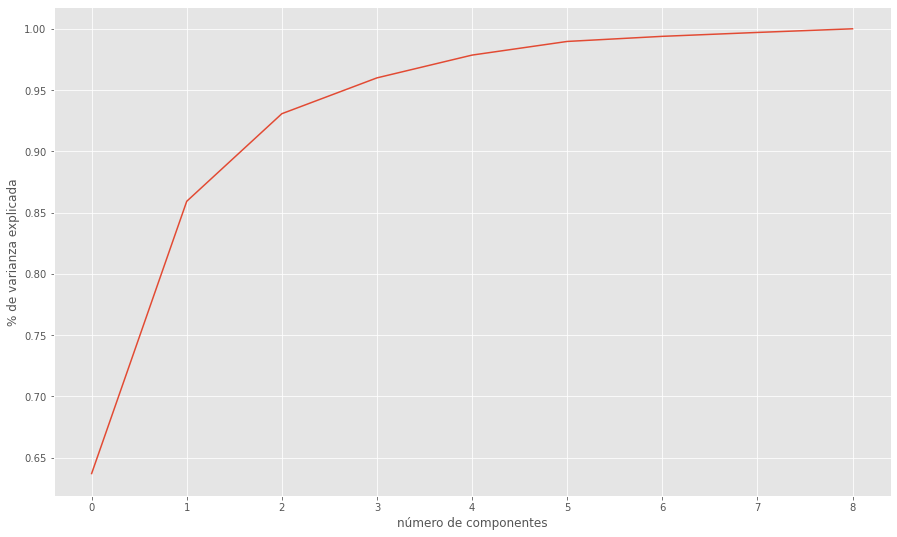

In [77]:
plot_explained_variance(components_count = 9, X = df_x1)

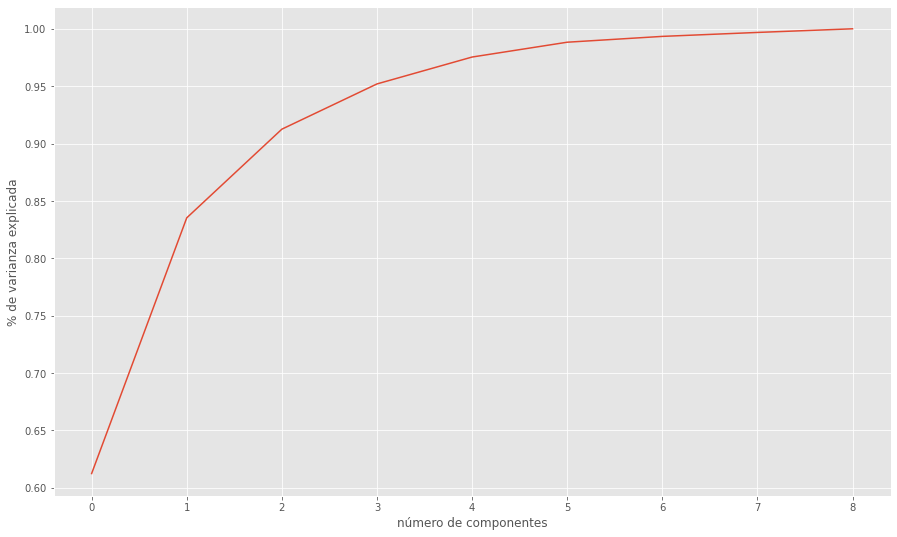

In [78]:
plot_explained_variance(components_count = 9, X = df_x2)

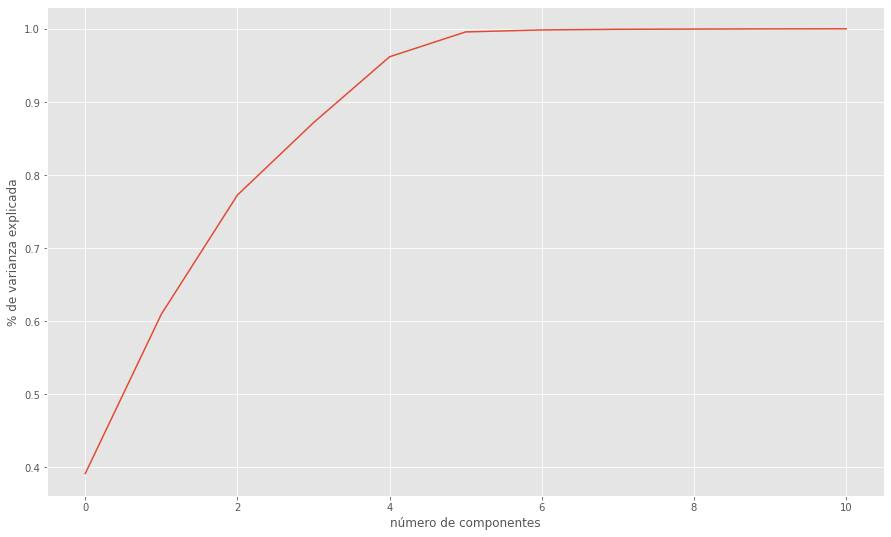

In [79]:
plot_explained_variance(components_count = 11, X = df_x3)

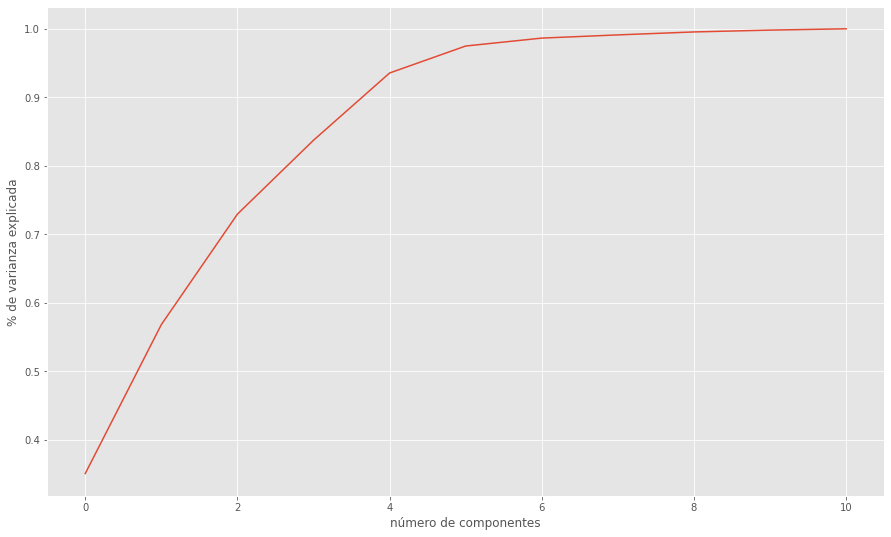

In [80]:
plot_explained_variance(components_count =11, X = df_x4)

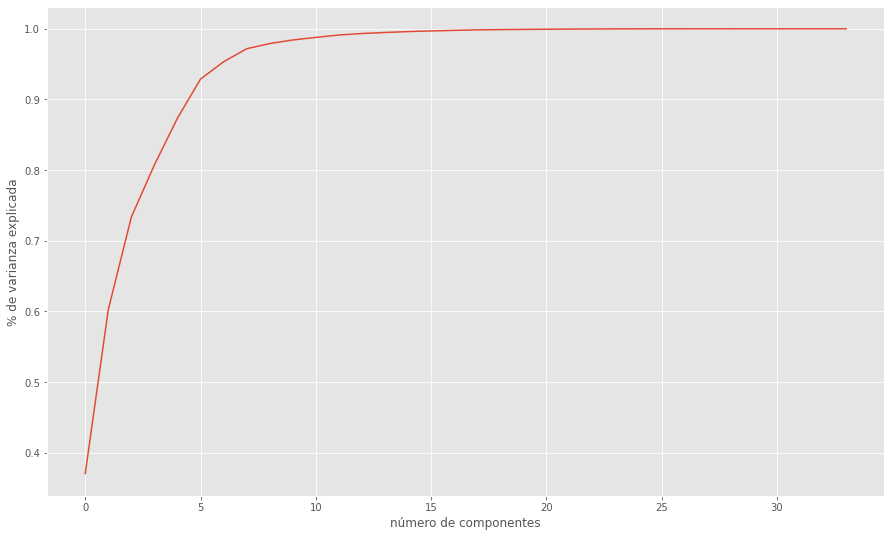

In [81]:
plot_explained_variance(components_count = 34, X = df_x5)

### Proyección - Bastón Quebrado

#### Proyección - Bastón Quebrado (x1 - Medidas)

In [82]:
#nuevo dataset con cada participación de feature
nuevo_data_pca_x1 = pd.DataFrame(pca_1.fit_transform(df_x1), index =df_x1.index,\
                              columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9'])

In [83]:
nuevo_data_pca_x1.reset_index()

index       PC1       PC2       PC3       PC4       PC5       PC6  \
0         0  1.278774 -0.536093 -0.271893  0.411321  0.694559  0.661451   
1         1 -2.029561 -0.608890  0.136322 -0.167529  0.319074 -0.294711   
2         2  0.198705 -0.542933  0.209993  0.168832 -0.399505  0.250548   
3         3 -0.418944 -0.909279 -2.285718 -0.073386  0.010667 -0.377978   
4         4  1.351391 -0.533889 -0.240609  0.397657  0.707854  0.773217   
...     ...       ...       ...       ...       ...       ...       ...   
1683   1683 -0.192669 -0.738952 -1.004813  0.107418 -0.599368  0.241658   
1684   1684 -0.183407 -0.737464 -1.024123  0.041573 -0.566872  0.013586   
1685   1685 -0.156728 -0.560395  0.438587 -0.996248 -0.159879  0.562186   
1686   1686 -0.069782 -0.554143  0.452774 -0.882465 -0.206218  0.615290   
1687   1687 -0.152943 -0.554811  0.479260 -0.913461 -0.206991  0.507545   

           PC7       PC8       PC9  
0     0.146662 -0.094817  0.218891  
1     0.166925 -0.033657 -0.054763  
2    -0.019574 -0.027659  0.074897  
3    -0.007401  0.006408 -0.090240  
4     0.135231 -0.064914  0.087179  
...        ...       ...       ...  
1683 -0.101994 -0.023429  0.079126  
1684 -0.144419 -0.009492  0.091615  
1685 -0.006103 -0.122725  0.186342  
1686 -0.042214 -0.101004  0.147312  
1687 -0.007216 -0.083477  0.047719  

[1688 rows x 10 columns]

In [84]:
data.reset_index()

index  Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  ...  \
0         0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28  ...   
1         1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97  ...   
2         2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11  ...   
3         3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44  ...   
4         4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29  ...   
...     ...   ...        ...   ...   ...    ...    ...   ...   ...   ...  ...   
1683   1683   554         25  6.12  1.96  12.97   9.71  7.76  5.23  5.25  ...   
1684   1684   554         26  6.29  1.93  12.96   9.76  7.58  5.23  5.26  ...   
1685   1685   554         27  5.59  1.47  13.51   9.58  8.04  6.33  5.34  ...   
1686   1686   554         28  5.61  1.50  13.52   9.68  8.18  6.33  5.32  ...   
1687   1687   554         29  5.70  1.47  13.38   9.54  8.14  6.33  5.31  ...   

        Power_NV Power_Ratio_LE_AE Power_Ratio_LT_AT  Power_Ratio_LA_AA  \
0     777.205187          0.018097          0.312515           0.547826   
1     610.134461          0.004648          0.259414           0.711718   
2     681.841766          0.006906          0.272619           0.303272   
3     875.781161          0.012346          0.380882           0.324194   
4     783.109853          0.018545          0.326245           0.519637   
...          ...               ...               ...                ...   
1683  759.691406          0.010520          0.314135           0.206329   
1684  765.496090          0.008864          0.321647           0.226637   
1685  813.139443          0.004782          0.252837           0.384229   
1686  801.025846          0.005111          0.262781           0.358593   
1687  795.020055          0.004424          0.258446           0.365693   

      Power_Ratio_LE_LT  Power_Ratio_AE_AT  Power_Ratio_LA_LT  \
0              0.002042           0.035268           0.193792   
1              0.000984           0.054918           0.248472   
2              0.001001           0.039531           0.141263   
3              0.003172           0.097870           0.081302   
4              0.002079           0.036576           0.201706   
...                 ...                ...                ...   
1683           0.001660           0.049573           0.084165   
1684           0.001529           0.055486           0.082453   
1685           0.000554           0.029311           0.190613   
1686           0.000577           0.029645           0.182858   
1687           0.000564           0.032936           0.193830   

      Power_Ratio_AA_AT  Power_Ratio_LE_LA  Power_Ratio_AE_AA  
0              0.110551           0.010539           0.319022  
1              0.090566           0.003960           0.606388  
2              0.126985           0.007089           0.311305  
3              0.095518           0.039018           1.024614  
4              0.126638           0.010308           0.288824  
...                 ...                ...                ...  
1683           0.128141           0.019725           0.386864  
1684           0.117019           0.018545           0.474161  
1685           0.125430           0.002908           0.233681  
1686           0.134001           0.003153           0.221227  
1687           0.136985           0.002908           0.240437  

[1688 rows x 40 columns]

In [85]:
pca_haplo_x1= pd.concat([nuevo_data_pca_x1, data["haplogrupos"]], axis=1)

In [86]:
pca_haplo_x1.head(5)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.278774 -0.536093 -0.271893  0.411321  0.694559  0.661451  0.146662   
1 -2.029561 -0.608890  0.136322 -0.167529  0.319074 -0.294711  0.166925   
2  0.198705 -0.542933  0.209993  0.168832 -0.399505  0.250548 -0.019574   
3 -0.418944 -0.909279 -2.285718 -0.073386  0.010667 -0.377978 -0.007401   
4  1.351391 -0.533889 -0.240609  0.397657  0.707854  0.773217  0.135231   

        PC8       PC9 haplogrupos  
0 -0.094817  0.218891           0  
1 -0.033657 -0.054763           2  
2 -0.027659  0.074897         NaN  
3  0.006408 -0.090240         NaN  
4 -0.064914  0.087179         NaN

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

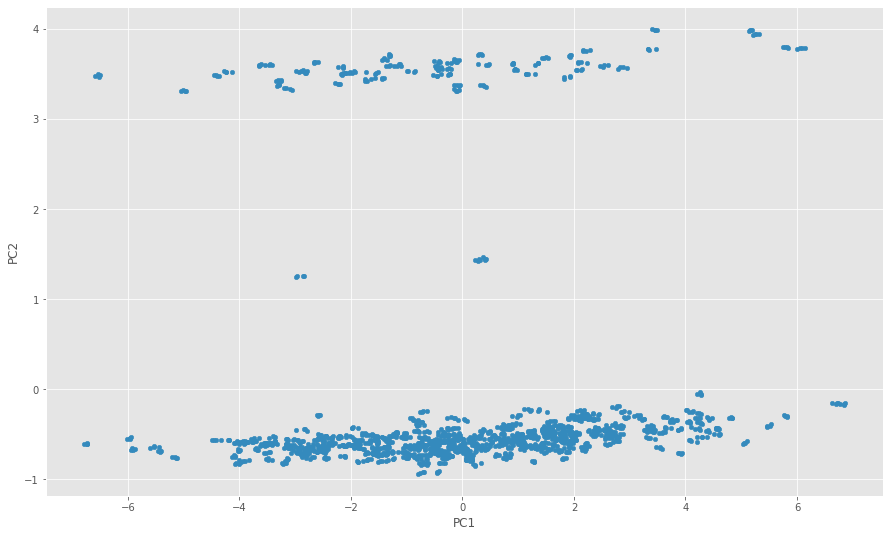

In [87]:
pca_haplo_x1.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

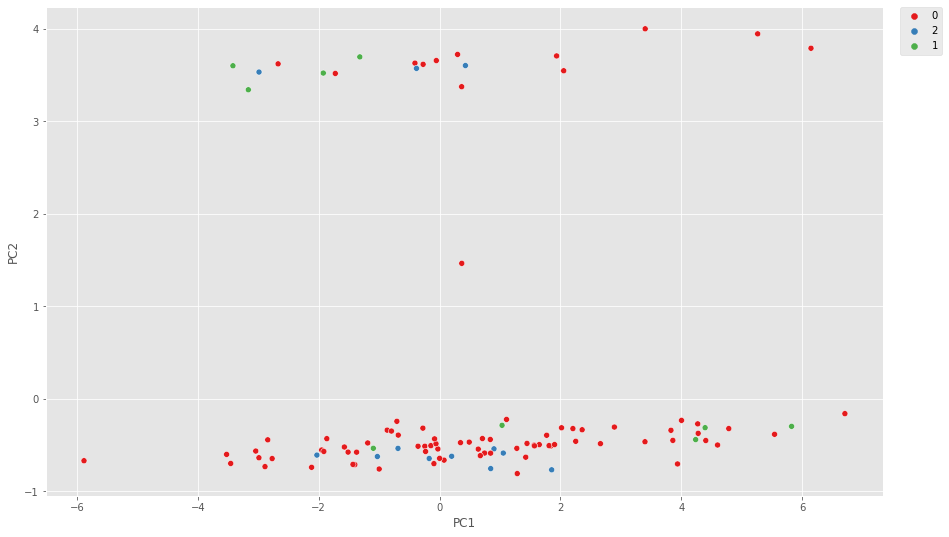

In [88]:
sns.scatterplot(data=pca_haplo_x1,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

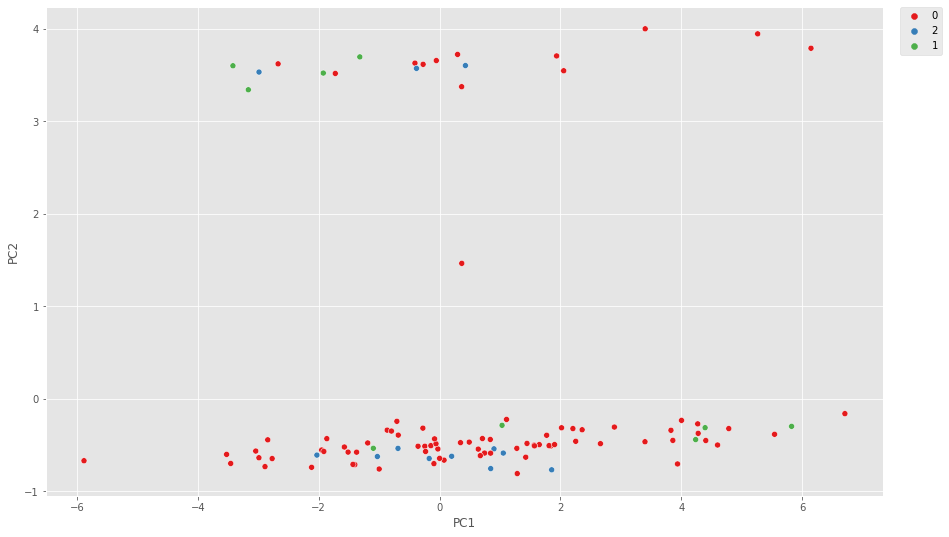

In [89]:
sns.scatterplot(data=pca_haplo_x1,x=pca_haplo_x1.PC1, y=pca_haplo_x1.PC2,hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [90]:
pca_1.explained_variance_ratio_

array([0.63691166, 0.22227471, 0.07150333, 0.02924664, 0.01859941,
       0.01113719, 0.00416907, 0.00318363, 0.00297435])

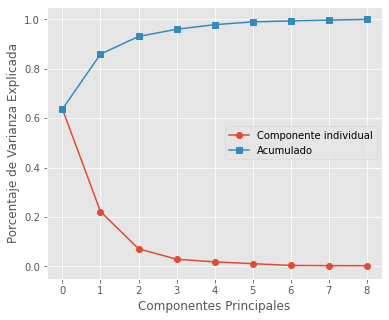

In [91]:
plt.figure(figsize=(6,5))

plt.plot(pca_1.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca_1.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

#### Proyección - Bastón Quebrado (x2 - Powers)

In [92]:
#nuevo dataset con cada participación de feature
nuevo_data_pca_x2 = pd.DataFrame(pca_2.fit_transform(df_x2), index =df_x2.index,\
                              columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9'])

In [93]:
nuevo_data_pca_x2.reset_index()

index       PC1       PC2       PC3       PC4       PC5       PC6  \
0         0  0.769419 -0.597519  0.486768  0.414847  0.685242  0.666236   
1         1 -1.965020 -0.556383 -0.190305 -0.038827  0.201666 -0.163474   
2         2 -0.327024 -0.542700 -0.273205  0.056893 -0.348367  0.229927   
3         3 -0.468594 -0.864720  1.966777 -0.132383  0.095786 -0.165763   
4         4  0.850731 -0.599216  0.467792  0.409250  0.715043  0.768074   
...     ...       ...       ...       ...       ...       ...       ...   
1683   1683 -0.575260 -0.692840  0.699244 -0.031377 -0.388372  0.237987   
1684   1684 -0.564640 -0.693592  0.712659 -0.107300 -0.378027  0.038332   
1685   1685 -0.517661 -0.612725 -0.200789 -0.937370 -0.080384  0.536270   
1686   1686 -0.455375 -0.602429 -0.250684 -0.845189 -0.134336  0.575116   
1687   1687 -0.527353 -0.602404 -0.257306 -0.847163 -0.117506  0.495574   

           PC7       PC8       PC9  
0     0.041293  0.205567  0.059007  
1    -0.072677  0.012814 -0.011095  
2     0.018605  0.061560  0.008235  
3    -0.125549 -0.061582 -0.060734  
4     0.022608  0.071191 -0.000309  
...        ...       ...       ...  
1683  0.049953  0.034563 -0.008434  
1684  0.079655  0.044052  0.005925  
1685  0.004000  0.148746 -0.012910  
1686  0.026721  0.096450 -0.028089  
1687 -0.025315  0.040293 -0.053211  

[1688 rows x 10 columns]

In [94]:
data.reset_index()

index  Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  ...  \
0         0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28  ...   
1         1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97  ...   
2         2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11  ...   
3         3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44  ...   
4         4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29  ...   
...     ...   ...        ...   ...   ...    ...    ...   ...   ...   ...  ...   
1683   1683   554         25  6.12  1.96  12.97   9.71  7.76  5.23  5.25  ...   
1684   1684   554         26  6.29  1.93  12.96   9.76  7.58  5.23  5.26  ...   
1685   1685   554         27  5.59  1.47  13.51   9.58  8.04  6.33  5.34  ...   
1686   1686   554         28  5.61  1.50  13.52   9.68  8.18  6.33  5.32  ...   
1687   1687   554         29  5.70  1.47  13.38   9.54  8.14  6.33  5.31  ...   

        Power_NV Power_Ratio_LE_AE Power_Ratio_LT_AT  Power_Ratio_LA_AA  \
0     777.205187          0.018097          0.312515           0.547826   
1     610.134461          0.004648          0.259414           0.711718   
2     681.841766          0.006906          0.272619           0.303272   
3     875.781161          0.012346          0.380882           0.324194   
4     783.109853          0.018545          0.326245           0.519637   
...          ...               ...               ...                ...   
1683  759.691406          0.010520          0.314135           0.206329   
1684  765.496090          0.008864          0.321647           0.226637   
1685  813.139443          0.004782          0.252837           0.384229   
1686  801.025846          0.005111          0.262781           0.358593   
1687  795.020055          0.004424          0.258446           0.365693   

      Power_Ratio_LE_LT  Power_Ratio_AE_AT  Power_Ratio_LA_LT  \
0              0.002042           0.035268           0.193792   
1              0.000984           0.054918           0.248472   
2              0.001001           0.039531           0.141263   
3              0.003172           0.097870           0.081302   
4              0.002079           0.036576           0.201706   
...                 ...                ...                ...   
1683           0.001660           0.049573           0.084165   
1684           0.001529           0.055486           0.082453   
1685           0.000554           0.029311           0.190613   
1686           0.000577           0.029645           0.182858   
1687           0.000564           0.032936           0.193830   

      Power_Ratio_AA_AT  Power_Ratio_LE_LA  Power_Ratio_AE_AA  
0              0.110551           0.010539           0.319022  
1              0.090566           0.003960           0.606388  
2              0.126985           0.007089           0.311305  
3              0.095518           0.039018           1.024614  
4              0.126638           0.010308           0.288824  
...                 ...                ...                ...  
1683           0.128141           0.019725           0.386864  
1684           0.117019           0.018545           0.474161  
1685           0.125430           0.002908           0.233681  
1686           0.134001           0.003153           0.221227  
1687           0.136985           0.002908           0.240437  

[1688 rows x 40 columns]

In [95]:
pca_haplo_x2= pd.concat([nuevo_data_pca_x2, data["haplogrupos"]], axis=1)

In [96]:
pca_haplo_x2.head(5)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.769419 -0.597519  0.486768  0.414847  0.685242  0.666236  0.041293   
1 -1.965020 -0.556383 -0.190305 -0.038827  0.201666 -0.163474 -0.072677   
2 -0.327024 -0.542700 -0.273205  0.056893 -0.348367  0.229927  0.018605   
3 -0.468594 -0.864720  1.966777 -0.132383  0.095786 -0.165763 -0.125549   
4  0.850731 -0.599216  0.467792  0.409250  0.715043  0.768074  0.022608   

        PC8       PC9 haplogrupos  
0  0.205567  0.059007           0  
1  0.012814 -0.011095           2  
2  0.061560  0.008235         NaN  
3 -0.061582 -0.060734         NaN  
4  0.071191 -0.000309         NaN

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

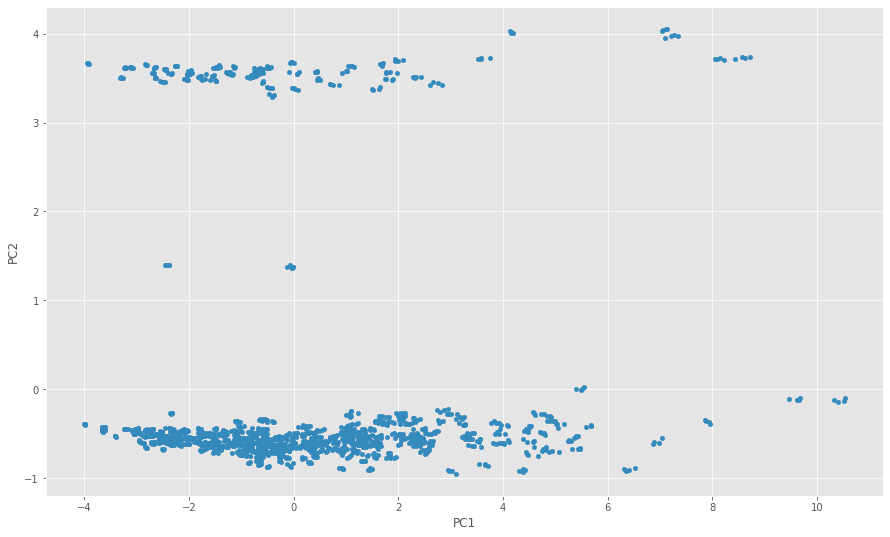

In [97]:
pca_haplo_x2.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

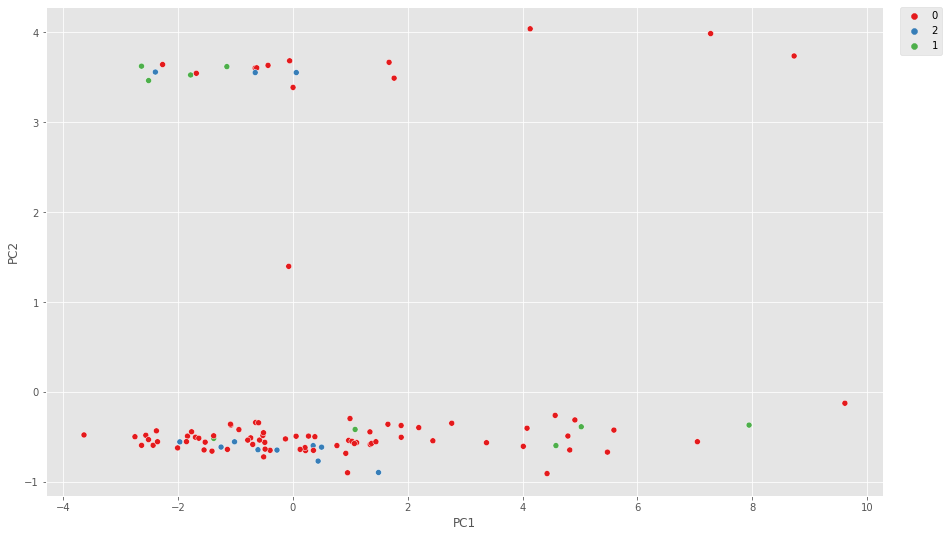

In [98]:
sns.scatterplot(data=pca_haplo_x2,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

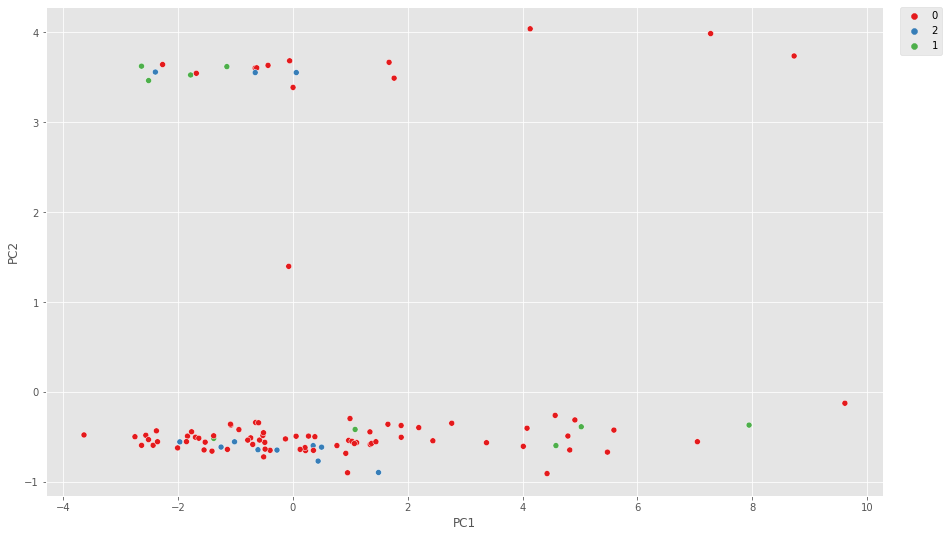

In [99]:
sns.scatterplot(data=pca_haplo_x2,x=pca_haplo_x2.PC1, y=pca_haplo_x2.PC2,hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [100]:
pca_4.explained_variance_ratio_

array([0.35067269, 0.21746512, 0.16128571, 0.10788445, 0.09816497,
       0.0393965 , 0.01154897, 0.00467711, 0.00432097, 0.00267022,
       0.00191328])

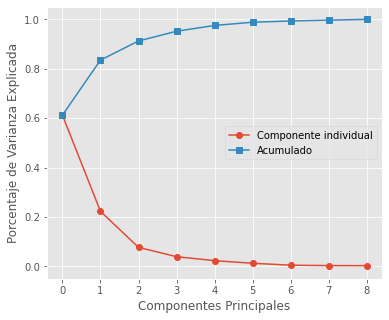

In [101]:
plt.figure(figsize=(6,5))

plt.plot(pca_2.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

#### Proyección - Bastón Quebrado (x3 - Ratios)

In [102]:
#nuevo dataset con cada participación de feature
nuevo_data_pca_x3 = pd.DataFrame(pca_3.fit_transform(df_x3), index =df_x3.index,\
                              columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10','PC11'])

In [103]:
nuevo_data_pca_x3.reset_index()

index       PC1       PC2       PC3       PC4       PC5       PC6  \
0         0  0.981712 -0.703095  0.268571 -1.019836  2.795334  0.429094   
1         1 -0.948894  1.486971 -1.785255  0.018369  0.267480 -0.571309   
2         2  0.009272 -1.822525  0.359822  0.486914  0.252941  0.378832   
3         3  5.962052  1.798045 -0.728177  0.530685 -0.879324 -0.401397   
4         4  1.034625 -1.156031  0.566815 -1.452277  2.602516  0.078575   
...     ...       ...       ...       ...       ...       ...       ...   
1683   1683  2.817759 -1.802415  0.854743  0.799924 -0.060918  0.575565   
1684   1684  2.861165 -1.067924  0.404849  0.920424 -0.557417  0.636057   
1685   1685 -2.278751 -2.124665  0.185925  0.229183  0.539532  0.696120   
1686   1686 -2.049339 -2.420016  0.423843  0.053265  0.432928  0.651702   
1687   1687 -2.118874 -2.236456  0.244628  0.046076  0.113147  0.272107   

           PC7       PC8       PC9      PC10      PC11  
0     0.000849 -0.090650  0.047909 -0.043579 -0.003899  
1    -0.009656 -0.045599  0.011114  0.011679 -0.006059  
2    -0.012847 -0.032539 -0.021448  0.010474 -0.010299  
3    -0.009847  0.329496  0.122547  0.034559  0.058605  
4    -0.000446 -0.106069  0.060773 -0.020302  0.009984  
...        ...       ...       ...       ...       ...  
1683 -0.013911  0.180964  0.045701  0.019610 -0.059910  
1684 -0.011425  0.165588  0.046157 -0.009458 -0.028184  
1685 -0.013286  0.009987 -0.033356  0.002292  0.019164  
1686 -0.012067 -0.000971 -0.029234  0.030263  0.020668  
1687 -0.015381 -0.003052 -0.023177  0.032551  0.017659  

[1688 rows x 12 columns]

In [104]:
data.reset_index()

index  Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  ...  \
0         0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28  ...   
1         1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97  ...   
2         2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11  ...   
3         3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44  ...   
4         4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29  ...   
...     ...   ...        ...   ...   ...    ...    ...   ...   ...   ...  ...   
1683   1683   554         25  6.12  1.96  12.97   9.71  7.76  5.23  5.25  ...   
1684   1684   554         26  6.29  1.93  12.96   9.76  7.58  5.23  5.26  ...   
1685   1685   554         27  5.59  1.47  13.51   9.58  8.04  6.33  5.34  ...   
1686   1686   554         28  5.61  1.50  13.52   9.68  8.18  6.33  5.32  ...   
1687   1687   554         29  5.70  1.47  13.38   9.54  8.14  6.33  5.31  ...   

        Power_NV Power_Ratio_LE_AE Power_Ratio_LT_AT  Power_Ratio_LA_AA  \
0     777.205187          0.018097          0.312515           0.547826   
1     610.134461          0.004648          0.259414           0.711718   
2     681.841766          0.006906          0.272619           0.303272   
3     875.781161          0.012346          0.380882           0.324194   
4     783.109853          0.018545          0.326245           0.519637   
...          ...               ...               ...                ...   
1683  759.691406          0.010520          0.314135           0.206329   
1684  765.496090          0.008864          0.321647           0.226637   
1685  813.139443          0.004782          0.252837           0.384229   
1686  801.025846          0.005111          0.262781           0.358593   
1687  795.020055          0.004424          0.258446           0.365693   

      Power_Ratio_LE_LT  Power_Ratio_AE_AT  Power_Ratio_LA_LT  \
0              0.002042           0.035268           0.193792   
1              0.000984           0.054918           0.248472   
2              0.001001           0.039531           0.141263   
3              0.003172           0.097870           0.081302   
4              0.002079           0.036576           0.201706   
...                 ...                ...                ...   
1683           0.001660           0.049573           0.084165   
1684           0.001529           0.055486           0.082453   
1685           0.000554           0.029311           0.190613   
1686           0.000577           0.029645           0.182858   
1687           0.000564           0.032936           0.193830   

      Power_Ratio_AA_AT  Power_Ratio_LE_LA  Power_Ratio_AE_AA  
0              0.110551           0.010539           0.319022  
1              0.090566           0.003960           0.606388  
2              0.126985           0.007089           0.311305  
3              0.095518           0.039018           1.024614  
4              0.126638           0.010308           0.288824  
...                 ...                ...                ...  
1683           0.128141           0.019725           0.386864  
1684           0.117019           0.018545           0.474161  
1685           0.125430           0.002908           0.233681  
1686           0.134001           0.003153           0.221227  
1687           0.136985           0.002908           0.240437  

[1688 rows x 40 columns]

In [105]:
pca_haplo_x3= pd.concat([nuevo_data_pca_x3, data["haplogrupos"]], axis=1)

In [106]:
pca_haplo_x3.head(5)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.981712 -0.703095  0.268571 -1.019836  2.795334  0.429094  0.000849   
1 -0.948894  1.486971 -1.785255  0.018369  0.267480 -0.571309 -0.009656   
2  0.009272 -1.822525  0.359822  0.486914  0.252941  0.378832 -0.012847   
3  5.962052  1.798045 -0.728177  0.530685 -0.879324 -0.401397 -0.009847   
4  1.034625 -1.156031  0.566815 -1.452277  2.602516  0.078575 -0.000446   

        PC8       PC9      PC10      PC11 haplogrupos  
0 -0.090650  0.047909 -0.043579 -0.003899           0  
1 -0.045599  0.011114  0.011679 -0.006059           2  
2 -0.032539 -0.021448  0.010474 -0.010299         NaN  
3  0.329496  0.122547  0.034559  0.058605         NaN  
4 -0.106069  0.060773 -0.020302  0.009984         NaN

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

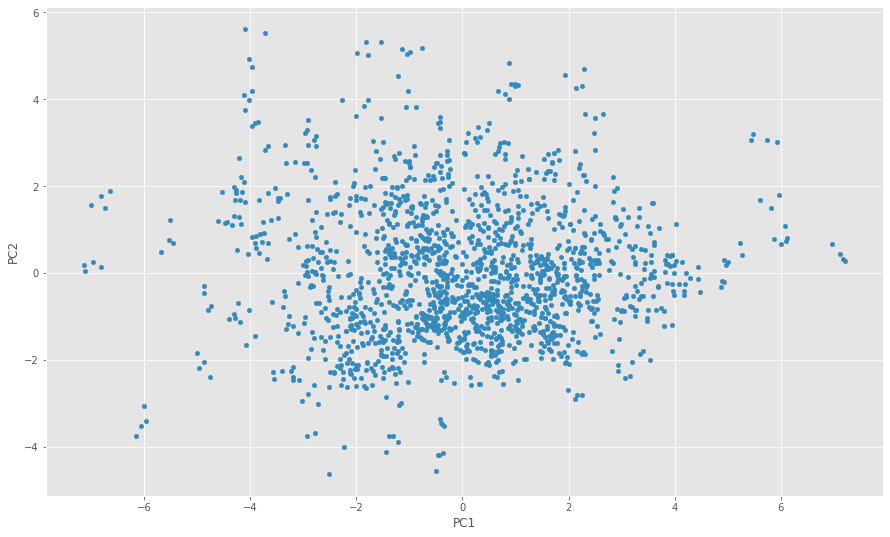

In [107]:
pca_haplo_x3.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

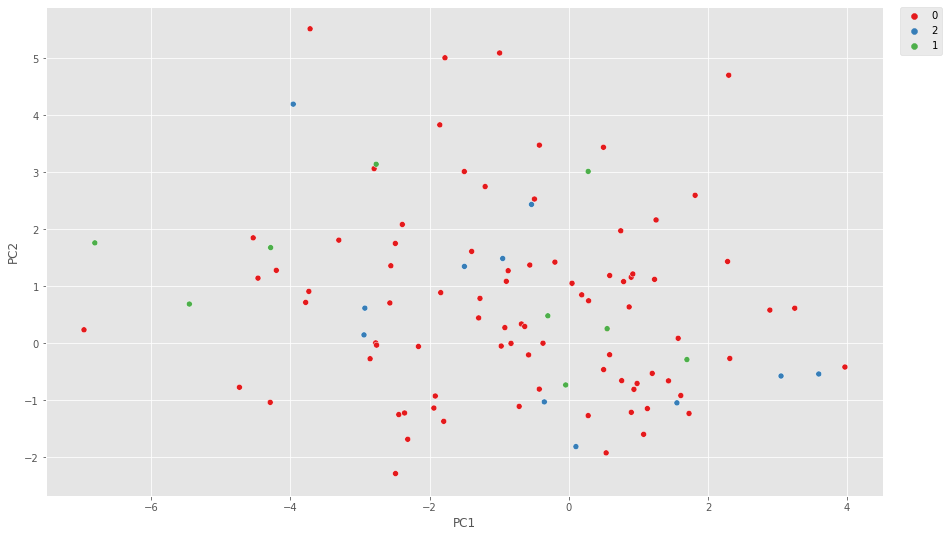

In [108]:
sns.scatterplot(data=pca_haplo_x3,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

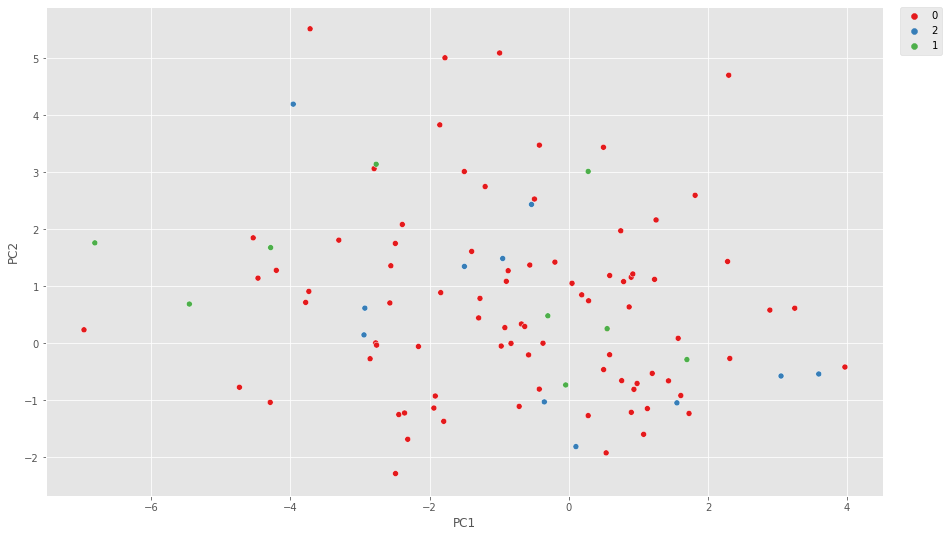

In [109]:
sns.scatterplot(data=pca_haplo_x3,x=pca_haplo_x3.PC1, y=pca_haplo_x3.PC2,hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [110]:
pca_3.explained_variance_ratio_

array([3.91625655e-01, 2.17978526e-01, 1.63000644e-01, 9.89898637e-02,
       9.01444436e-02, 3.39964209e-02, 2.69499496e-03, 8.82840067e-04,
       3.05715941e-04, 2.70429976e-04, 1.10466357e-04])

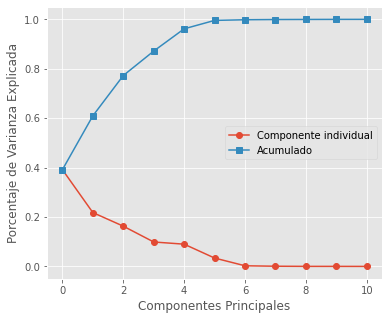

In [111]:
plt.figure(figsize=(6,5))

plt.plot(pca_3.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca_3.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

#### Proyección - Bastón Quebrado (x4 - Power Ratios)

In [112]:
#nuevo dataset con cada participación de feature
nuevo_data_pca_x4 = pd.DataFrame(pca_4.fit_transform(df_x4), index =df_x4.index,columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10','PC11'])

In [113]:
nuevo_data_pca_x4.reset_index()

index       PC1       PC2       PC3       PC4       PC5       PC6  \
0         0  0.945468 -0.609759  0.327913  2.894897  0.740406  0.983091   
1         1 -0.866730  1.404817 -1.843706  0.138591 -0.088334 -0.410902   
2         2 -0.414734 -1.732461  0.317644  0.115952 -0.503915  0.425177   
3         3  7.509378  2.021548 -0.796347 -0.797931 -0.759113 -1.636742   
4         4  1.006538 -1.024070  0.634407  2.825734  1.217809  0.652940   
...     ...       ...       ...       ...       ...       ...       ...   
1683   1683  2.223305 -1.705164  0.839020  0.189424 -0.619849  0.299125   
1684   1684  2.286496 -1.074391  0.383773 -0.422285 -0.752438  0.314422   
1685   1685 -2.060664 -1.802997  0.081990  0.413429 -0.359921  0.520150   
1686   1686 -1.909245 -2.076341  0.307607  0.312917 -0.162774  0.461805   
1687   1687 -1.945085 -1.982877  0.190926  0.144704 -0.107943  0.128854   

           PC7       PC8       PC9      PC10      PC11  
0     0.349853  0.019754 -0.133462  0.010586  0.047327  
1     0.195465  0.028033  0.000677 -0.005486 -0.061373  
2     0.001907 -0.076738  0.066124 -0.022611 -0.022045  
3    -0.939138  0.741146  0.277130 -0.013043  0.095262  
4     0.471131  0.038049 -0.069185 -0.008284  0.090761  
...        ...       ...       ...       ...       ...  
1683 -0.569468  0.253923  0.147859  0.015401 -0.169461  
1684 -0.508351  0.262397  0.022228  0.023638 -0.094200  
1685 -0.215233 -0.034746  0.075167 -0.034351  0.068923  
1686 -0.167684 -0.042015  0.166688 -0.048935  0.070999  
1687 -0.102039 -0.022100  0.161402 -0.048622  0.052016  

[1688 rows x 12 columns]

In [114]:
data.reset_index()

index  Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  ...  \
0         0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28  ...   
1         1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97  ...   
2         2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11  ...   
3         3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44  ...   
4         4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29  ...   
...     ...   ...        ...   ...   ...    ...    ...   ...   ...   ...  ...   
1683   1683   554         25  6.12  1.96  12.97   9.71  7.76  5.23  5.25  ...   
1684   1684   554         26  6.29  1.93  12.96   9.76  7.58  5.23  5.26  ...   
1685   1685   554         27  5.59  1.47  13.51   9.58  8.04  6.33  5.34  ...   
1686   1686   554         28  5.61  1.50  13.52   9.68  8.18  6.33  5.32  ...   
1687   1687   554         29  5.70  1.47  13.38   9.54  8.14  6.33  5.31  ...   

        Power_NV Power_Ratio_LE_AE Power_Ratio_LT_AT  Power_Ratio_LA_AA  \
0     777.205187          0.018097          0.312515           0.547826   
1     610.134461          0.004648          0.259414           0.711718   
2     681.841766          0.006906          0.272619           0.303272   
3     875.781161          0.012346          0.380882           0.324194   
4     783.109853          0.018545          0.326245           0.519637   
...          ...               ...               ...                ...   
1683  759.691406          0.010520          0.314135           0.206329   
1684  765.496090          0.008864          0.321647           0.226637   
1685  813.139443          0.004782          0.252837           0.384229   
1686  801.025846          0.005111          0.262781           0.358593   
1687  795.020055          0.004424          0.258446           0.365693   

      Power_Ratio_LE_LT  Power_Ratio_AE_AT  Power_Ratio_LA_LT  \
0              0.002042           0.035268           0.193792   
1              0.000984           0.054918           0.248472   
2              0.001001           0.039531           0.141263   
3              0.003172           0.097870           0.081302   
4              0.002079           0.036576           0.201706   
...                 ...                ...                ...   
1683           0.001660           0.049573           0.084165   
1684           0.001529           0.055486           0.082453   
1685           0.000554           0.029311           0.190613   
1686           0.000577           0.029645           0.182858   
1687           0.000564           0.032936           0.193830   

      Power_Ratio_AA_AT  Power_Ratio_LE_LA  Power_Ratio_AE_AA  
0              0.110551           0.010539           0.319022  
1              0.090566           0.003960           0.606388  
2              0.126985           0.007089           0.311305  
3              0.095518           0.039018           1.024614  
4              0.126638           0.010308           0.288824  
...                 ...                ...                ...  
1683           0.128141           0.019725           0.386864  
1684           0.117019           0.018545           0.474161  
1685           0.125430           0.002908           0.233681  
1686           0.134001           0.003153           0.221227  
1687           0.136985           0.002908           0.240437  

[1688 rows x 40 columns]

In [115]:
pca_haplo_x4= pd.concat([nuevo_data_pca_x4, data["haplogrupos"]], axis=1)

In [116]:
pca_haplo_x4.head(5)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.945468 -0.609759  0.327913  2.894897  0.740406  0.983091  0.349853   
1 -0.866730  1.404817 -1.843706  0.138591 -0.088334 -0.410902  0.195465   
2 -0.414734 -1.732461  0.317644  0.115952 -0.503915  0.425177  0.001907   
3  7.509378  2.021548 -0.796347 -0.797931 -0.759113 -1.636742 -0.939138   
4  1.006538 -1.024070  0.634407  2.825734  1.217809  0.652940  0.471131   

        PC8       PC9      PC10      PC11 haplogrupos  
0  0.019754 -0.133462  0.010586  0.047327           0  
1  0.028033  0.000677 -0.005486 -0.061373           2  
2 -0.076738  0.066124 -0.022611 -0.022045         NaN  
3  0.741146  0.277130 -0.013043  0.095262         NaN  
4  0.038049 -0.069185 -0.008284  0.090761         NaN

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

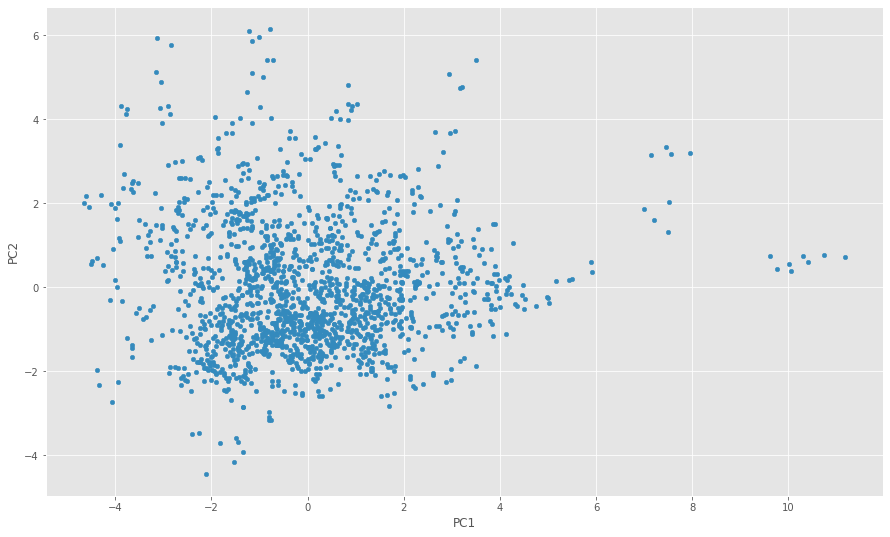

In [117]:
pca_haplo_x4.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

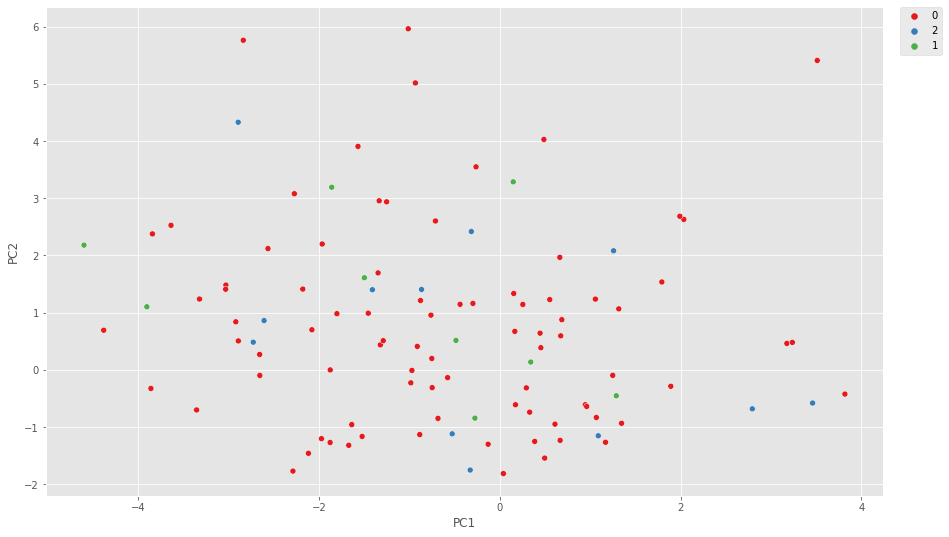

In [118]:
sns.scatterplot(data=pca_haplo_x4,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

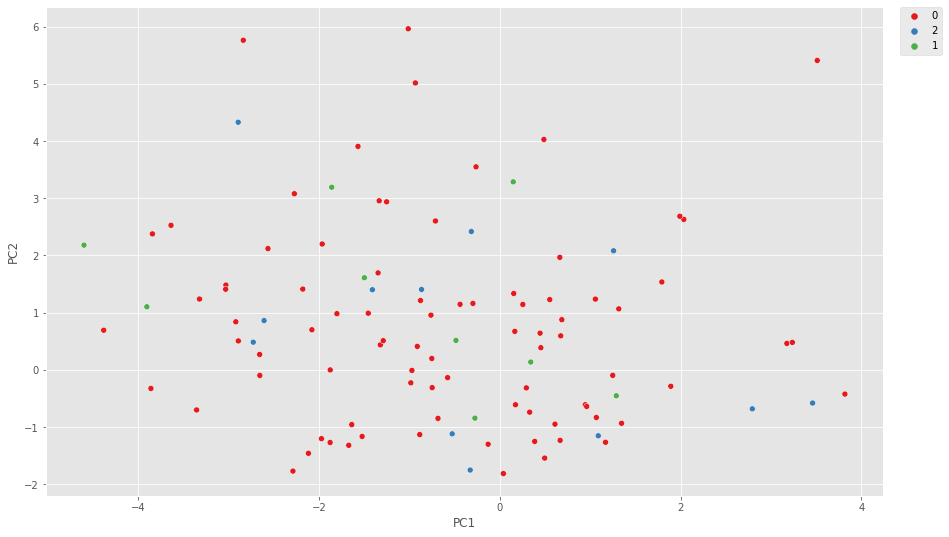

In [119]:
sns.scatterplot(data=pca_haplo_x4,x=pca_haplo_x4.PC1, y=pca_haplo_x4.PC2,hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [120]:
pca_4.explained_variance_ratio_

array([0.35067269, 0.21746512, 0.16128571, 0.10788445, 0.09816497,
       0.0393965 , 0.01154897, 0.00467711, 0.00432097, 0.00267022,
       0.00191328])

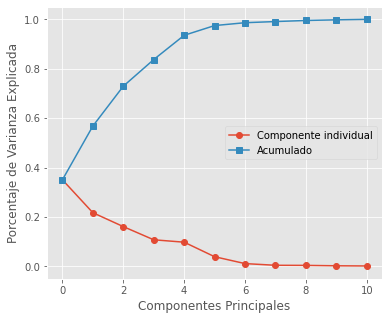

In [121]:
plt.figure(figsize=(6,5))

plt.plot(pca_4.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca_4.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

#### Proyección - Bastón Quebrado (x5 - Todos los futures)

In [122]:
#nuevo dataset con cada participación de feature
nuevo_data_pca = pd.DataFrame(pca_5.fit_transform(df_x5), index =df_x5.index,\
                              columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10','PC11','PC12','PC13',\
                                       'PC14','PC15','PC16','PC17','PC18','CP19','PC20', 'PC21', 'PC22', 'PC23','PC24', 'PC25', 'PC26', \
                                       'PC27','PC28', 'PC29','PC30','PC31','PC32','PC33','PC34'])

In [123]:
nuevo_data_pca.head(10)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.879451  0.541499  0.878859  3.337913  2.732173 -1.032855  1.034464   
1 -3.493884  0.805714 -2.407458 -0.720932  0.496158 -1.065208 -0.616935   
2  0.034532 -0.811380  2.485058 -0.511926  0.560611  0.151755  0.596080   
3  4.204249  9.330722 -1.549989 -1.604105 -0.456248  0.003587 -1.583203   
4  2.097490  0.387128  1.554832  3.798904  2.198114 -1.248394  0.530772   
5  1.666828  0.229697  0.851988  3.574419  3.114961 -1.252333  0.623407   
6  2.081533  0.596609  1.053602  3.293592  2.151055 -1.217407  0.364177   
7 -3.235078  0.996938 -2.585920 -1.167675 -0.214793 -0.965127 -0.582674   
8 -3.137802  0.651573 -1.915059 -1.036424 -0.567079 -0.988065 -0.695841   
9 -3.306289  0.782124 -1.768931 -0.620220  0.115662 -1.048213 -0.737293   

        PC8       PC9      PC10  ...      PC25      PC26      PC27      PC28  \
0 -0.863420 -0.351436  0.295483  ...  0.000865  0.032261 -0.003682  0.007996   
1  0.026867 -0.282510 -0.168332  ...  0.020992  0.010050 -0.000050  0.004497   
2 -0.018333 -0.286113  0.178430  ...  0.024064 -0.011284 -0.010370 -0.002061   
3  0.277241  1.370611  0.773696  ... -0.016468 -0.039251 -0.031733 -0.004166   
4 -0.835290 -0.407061  0.336501  ...  0.036363  0.037008 -0.004864  0.000882   
5 -1.106642 -0.445254  0.290829  ... -0.001705  0.028556 -0.008644  0.005426   
6 -0.938730 -0.400474  0.233609  ...  0.023996  0.037641 -0.003182  0.002799   
7  0.186668 -0.196203 -0.082495  ...  0.022494  0.014537 -0.002287  0.006277   
8 -0.033031 -0.116883 -0.084721  ...  0.019231  0.016207 -0.003049  0.006953   
9 -0.021160 -0.279031 -0.161638  ...  0.022250  0.010879  0.000730  0.004472   

       PC29      PC30      PC31      PC32      PC33      PC34  
0  0.006841 -0.015930 -0.001498  0.003389  0.001582 -0.003083  
1 -0.014460  0.009974  0.002041 -0.005674  0.000582  0.001487  
2 -0.004267 -0.009571 -0.001696 -0.003441  0.000896  0.001267  
3  0.013771 -0.001898 -0.008870  0.009219 -0.005241 -0.010814  
4  0.006660 -0.013560 -0.002636  0.001509 -0.005865 -0.001996  
5  0.010655 -0.017181 -0.004208  0.003088  0.000557 -0.003850  
6  0.007317 -0.013808 -0.002973  0.001927 -0.003691 -0.002465  
7 -0.013930  0.007208 -0.000608 -0.005684  0.000163  0.002563  
8 -0.012285  0.006976 -0.000563 -0.005023  0.001203  0.001997  
9 -0.013674  0.009995  0.001898 -0.005261  0.001758  0.001079  

[10 rows x 34 columns]

In [124]:
nuevo_data_pca.reset_index()

index       PC1       PC2       PC3       PC4       PC5       PC6  \
0         0  1.879451  0.541499  0.878859  3.337913  2.732173 -1.032855   
1         1 -3.493884  0.805714 -2.407458 -0.720932  0.496158 -1.065208   
2         2  0.034532 -0.811380  2.485058 -0.511926  0.560611  0.151755   
3         3  4.204249  9.330722 -1.549989 -1.604105 -0.456248  0.003587   
4         4  2.097490  0.387128  1.554832  3.798904  2.198114 -1.248394   
...     ...       ...       ...       ...       ...       ...       ...   
1683   1683  1.800325  2.903766  3.359474 -0.706595  0.438916  0.648352   
1684   1684  1.737150  3.175270  2.223688 -1.386800 -0.069304  0.666460   
1685   1685 -1.754656 -2.950722  2.320172 -0.343017  0.643993 -0.282199   
1686   1686 -1.468703 -2.897121  2.816331 -0.137666  0.360168 -0.269447   
1687   1687 -1.616578 -2.880149  2.551030 -0.364739  0.079040 -0.397785   

           PC7       PC8       PC9  ...      PC25      PC26      PC27  \
0     1.034464 -0.863420 -0.351436  ...  0.000865  0.032261 -0.003682   
1    -0.616935  0.026867 -0.282510  ...  0.020992  0.010050 -0.000050   
2     0.596080 -0.018333 -0.286113  ...  0.024064 -0.011284 -0.010370   
3    -1.583203  0.277241  1.370611  ... -0.016468 -0.039251 -0.031733   
4     0.530772 -0.835290 -0.407061  ...  0.036363  0.037008 -0.004864   
...        ...       ...       ...  ...       ...       ...       ...   
1683  0.477688 -0.233981  0.267127  ...  0.044703  0.000511  0.008507   
1684  0.560703 -0.114556  0.267419  ...  0.011234 -0.001505  0.003148   
1685  0.738502 -1.717274  0.334746  ...  0.004193 -0.056590 -0.007518   
1686  0.676940 -1.546819  0.261414  ...  0.016259 -0.060081 -0.010891   
1687  0.165137 -1.416556  0.250328  ...  0.034447 -0.039338 -0.005707   

          PC28      PC29      PC30      PC31      PC32      PC33      PC34  
0     0.007996  0.006841 -0.015930 -0.001498  0.003389  0.001582 -0.003083  
1     0.004497 -0.014460  0.009974  0.002041 -0.005674  0.000582  0.001487  
2    -0.002061 -0.004267 -0.009571 -0.001696 -0.003441  0.000896  0.001267  
3    -0.004166  0.013771 -0.001898 -0.008870  0.009219 -0.005241 -0.010814  
4     0.000882  0.006660 -0.013560 -0.002636  0.001509 -0.005865 -0.001996  
...        ...       ...       ...       ...       ...       ...       ...  
1683  0.000170  0.001820 -0.007697  0.003811  0.003135  0.002261  0.003910  
1684  0.001188  0.005217 -0.004785  0.004173 -0.001017 -0.003059 -0.003089  
1685 -0.013665  0.007022 -0.007843  0.001228 -0.005663  0.000558 -0.000704  
1686 -0.016812  0.005603 -0.010442  0.001557 -0.008973 -0.003100  0.002307  
1687 -0.016135  0.003159 -0.001397  0.000134 -0.006083 -0.004922  0.000718  

[1688 rows x 35 columns]

In [125]:
data.reset_index()

index  Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  ...  \
0         0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28  ...   
1         1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97  ...   
2         2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11  ...   
3         3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44  ...   
4         4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29  ...   
...     ...   ...        ...   ...   ...    ...    ...   ...   ...   ...  ...   
1683   1683   554         25  6.12  1.96  12.97   9.71  7.76  5.23  5.25  ...   
1684   1684   554         26  6.29  1.93  12.96   9.76  7.58  5.23  5.26  ...   
1685   1685   554         27  5.59  1.47  13.51   9.58  8.04  6.33  5.34  ...   
1686   1686   554         28  5.61  1.50  13.52   9.68  8.18  6.33  5.32  ...   
1687   1687   554         29  5.70  1.47  13.38   9.54  8.14  6.33  5.31  ...   

        Power_NV Power_Ratio_LE_AE Power_Ratio_LT_AT  Power_Ratio_LA_AA  \
0     777.205187          0.018097          0.312515           0.547826   
1     610.134461          0.004648          0.259414           0.711718   
2     681.841766          0.006906          0.272619           0.303272   
3     875.781161          0.012346          0.380882           0.324194   
4     783.109853          0.018545          0.326245           0.519637   
...          ...               ...               ...                ...   
1683  759.691406          0.010520          0.314135           0.206329   
1684  765.496090          0.008864          0.321647           0.226637   
1685  813.139443          0.004782          0.252837           0.384229   
1686  801.025846          0.005111          0.262781           0.358593   
1687  795.020055          0.004424          0.258446           0.365693   

      Power_Ratio_LE_LT  Power_Ratio_AE_AT  Power_Ratio_LA_LT  \
0              0.002042           0.035268           0.193792   
1              0.000984           0.054918           0.248472   
2              0.001001           0.039531           0.141263   
3              0.003172           0.097870           0.081302   
4              0.002079           0.036576           0.201706   
...                 ...                ...                ...   
1683           0.001660           0.049573           0.084165   
1684           0.001529           0.055486           0.082453   
1685           0.000554           0.029311           0.190613   
1686           0.000577           0.029645           0.182858   
1687           0.000564           0.032936           0.193830   

      Power_Ratio_AA_AT  Power_Ratio_LE_LA  Power_Ratio_AE_AA  
0              0.110551           0.010539           0.319022  
1              0.090566           0.003960           0.606388  
2              0.126985           0.007089           0.311305  
3              0.095518           0.039018           1.024614  
4              0.126638           0.010308           0.288824  
...                 ...                ...                ...  
1683           0.128141           0.019725           0.386864  
1684           0.117019           0.018545           0.474161  
1685           0.125430           0.002908           0.233681  
1686           0.134001           0.003153           0.221227  
1687           0.136985           0.002908           0.240437  

[1688 rows x 40 columns]

In [126]:
pca_haplo= pd.concat([nuevo_data_pca, data["haplogrupos"]], axis=1)

In [127]:
pca_haplo.head(5)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.879451  0.541499  0.878859  3.337913  2.732173 -1.032855  1.034464   
1 -3.493884  0.805714 -2.407458 -0.720932  0.496158 -1.065208 -0.616935   
2  0.034532 -0.811380  2.485058 -0.511926  0.560611  0.151755  0.596080   
3  4.204249  9.330722 -1.549989 -1.604105 -0.456248  0.003587 -1.583203   
4  2.097490  0.387128  1.554832  3.798904  2.198114 -1.248394  0.530772   

        PC8       PC9      PC10  ...      PC26      PC27      PC28      PC29  \
0 -0.863420 -0.351436  0.295483  ...  0.032261 -0.003682  0.007996  0.006841   
1  0.026867 -0.282510 -0.168332  ...  0.010050 -0.000050  0.004497 -0.014460   
2 -0.018333 -0.286113  0.178430  ... -0.011284 -0.010370 -0.002061 -0.004267   
3  0.277241  1.370611  0.773696  ... -0.039251 -0.031733 -0.004166  0.013771   
4 -0.835290 -0.407061  0.336501  ...  0.037008 -0.004864  0.000882  0.006660   

       PC30      PC31      PC32      PC33      PC34  haplogrupos  
0 -0.015930 -0.001498  0.003389  0.001582 -0.003083            0  
1  0.009974  0.002041 -0.005674  0.000582  0.001487            2  
2 -0.009571 -0.001696 -0.003441  0.000896  0.001267          NaN  
3 -0.001898 -0.008870  0.009219 -0.005241 -0.010814          NaN  
4 -0.013560 -0.002636  0.001509 -0.005865 -0.001996          NaN  

[5 rows x 35 columns]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

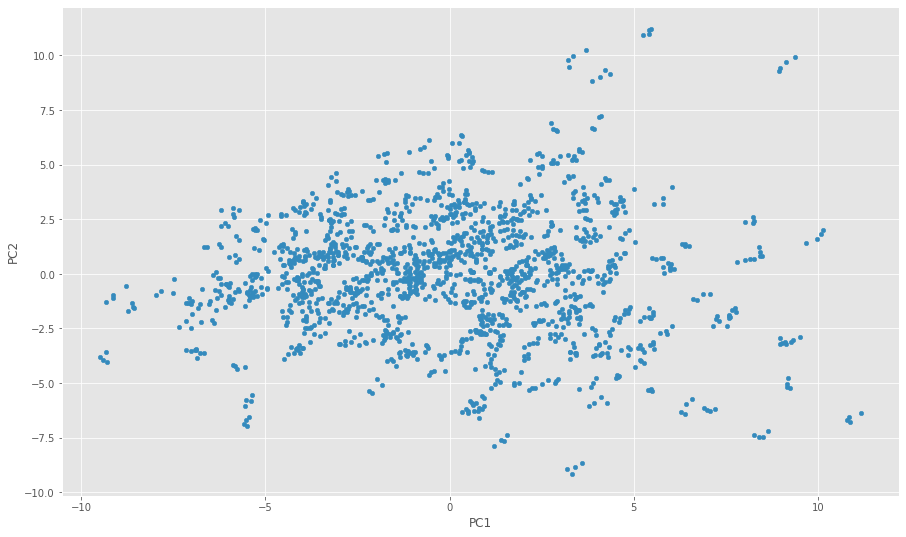

In [128]:
pca_haplo.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

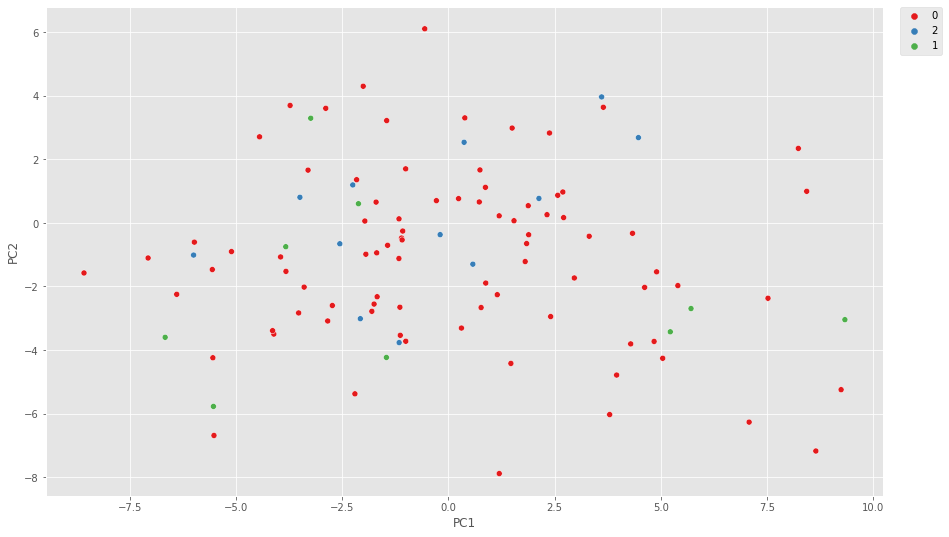

In [129]:
sns.scatterplot(data=pca_haplo,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

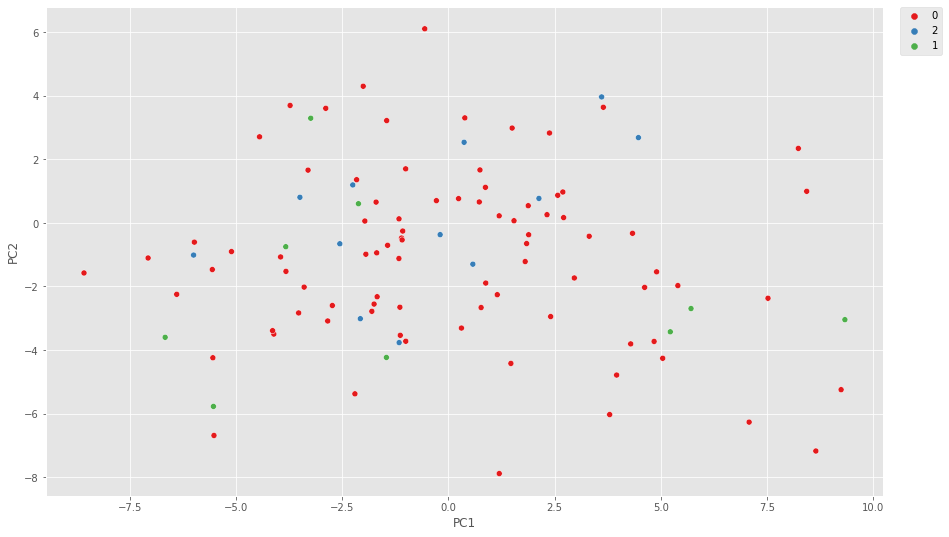

In [130]:
sns.scatterplot(data=pca_haplo,x=pca_haplo.PC1, y=pca_haplo.PC2,hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [131]:
pca_5.explained_variance_ratio_

array([3.70213849e-01, 2.32283588e-01, 1.30964136e-01, 7.38963378e-02,
       6.61507528e-02, 5.53478832e-02, 2.44482716e-02, 1.84468979e-02,
       7.36983641e-03, 5.04681899e-03, 3.63046376e-03, 3.42268560e-03,
       2.08024091e-03, 1.45949548e-03, 1.29842474e-03, 8.77983390e-04,
       8.35753327e-04, 7.05679134e-04, 3.68430504e-04, 2.86383605e-04,
       2.29947693e-04, 2.14834401e-04, 1.63564729e-04, 1.34301329e-04,
       6.02276401e-05, 2.91482480e-05, 1.44292140e-05, 6.30058106e-06,
       5.29583036e-06, 3.45797090e-06, 1.60849340e-06, 1.29052300e-06,
       1.00719865e-06, 6.73832881e-07])

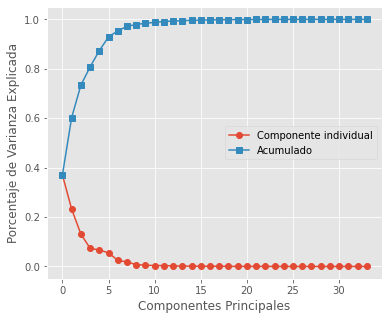

In [132]:
plt.figure(figsize=(6,5))

plt.plot(pca_5.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca_5.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

## Prueba TSNE

In [133]:
from sklearn.manifold import TSNE

### TSNE (x1 - Medidas)

In [134]:
tsne = TSNE(random_state=42)

proj_tsne_x1 =  tsne.fit_transform(df_x1)

In [135]:
df_x1.head()

0         1         2         3         4         5         6  \
0 -0.165818  1.238365  0.391905  0.495167  0.321955  0.760541  0.454609   
1 -0.624470 -0.779665 -0.843994 -1.029964 -1.064153 -0.442926 -0.584837   
2 -0.104664  0.016926  0.258016  0.119107  0.427331 -0.180352 -0.115410   
3  0.364181  1.158706 -0.756451 -0.354450 -0.918247 -1.438522  0.991097   
4 -0.176010  1.264918  0.314661  0.495167  0.475967  0.837125  0.488139   

          7         8  
0 -0.391159  0.403156  
1 -0.391159  0.403156  
2 -0.391159  0.403156  
3 -0.391159  0.403156  
4 -0.391159  0.403156

In [136]:
df_tsne_x1= pd.DataFrame(proj_tsne_x1)

In [137]:
df_tsne_x1.head()

0          1
0 -34.292675 -11.824125
1  40.772354  -1.478211
2  -0.789214  -4.178360
3   5.268590 -36.844326
4 -34.427574 -11.819998

In [138]:
tsne_haplo_x1= pd.concat([df_tsne_x1, data["haplogrupos"]], axis=1)

In [139]:
tsne_haplo_x1.columns = ["X","Y","haplogrupos"]

In [140]:
tsne_haplo_x1.head()

X          Y haplogrupos
0 -34.292675 -11.824125           0
1  40.772354  -1.478211           2
2  -0.789214  -4.178360         NaN
3   5.268590 -36.844326         NaN
4 -34.427574 -11.819998         NaN

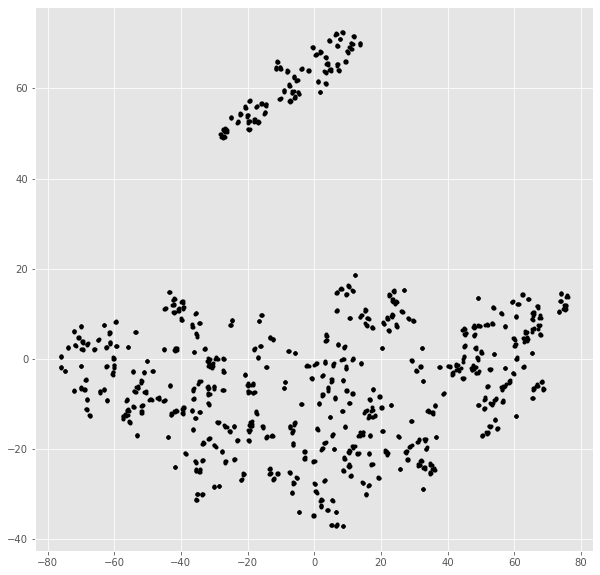

In [141]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x1[:, 0]
coord_y = proj_tsne_x1[:, 1]
ax.plot(coord_x, coord_y, '.k')

<AxesSubplot:xlabel='X', ylabel='Y'>

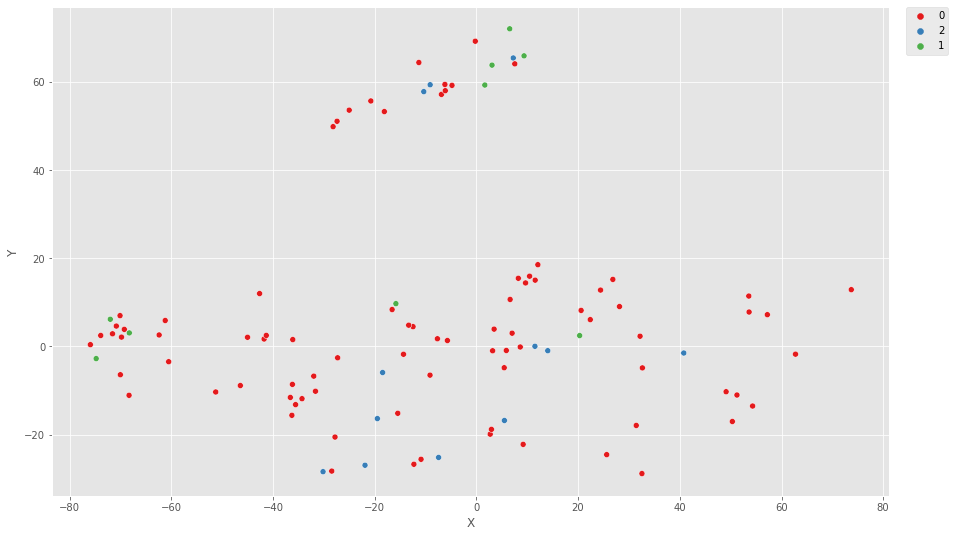

In [142]:
sns.scatterplot(data=tsne_haplo_x1,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### TSNE (x2 - Powers)

In [143]:
tsne = TSNE(random_state=42)

proj_tsne_x2 = tsne.fit_transform(df_x2)

In [144]:
df_x2.head()

0         1         2         3         4         5         6  \
0  1.154010 -0.357865  0.282269  0.175066  0.521446  0.080256  0.393611   
1 -0.726906 -0.700299 -0.907626 -0.806395 -0.501737 -0.892336 -0.652027   
2 -0.244439 -0.306054 -0.090606  0.041019 -0.321729  0.184689 -0.203236   
3  1.031730  0.144643 -0.481210 -0.753926 -1.009074 -0.820114  1.010564   
4  1.195883 -0.366353  0.282269  0.096814  0.605445  0.234591  0.430566   

          7         8  
0 -0.391159  0.403156  
1 -0.391159  0.403156  
2 -0.391159  0.403156  
3 -0.391159  0.403156  
4 -0.391159  0.403156

In [145]:
df_tsne_x2= pd.DataFrame(proj_tsne_x2)

In [146]:
df_tsne_x2.head()

0          1
0 -21.470926  22.143183
1  42.815845 -15.714681
2   8.764060   5.574784
3 -14.573481 -14.703093
4 -21.612427  22.221329

In [147]:
tsne_haplo_x2= pd.concat([df_tsne_x2, data["haplogrupos"]], axis=1)

In [148]:
tsne_haplo_x2.columns = ["X","Y","haplogrupos"]

In [149]:
tsne_haplo_x2.head()

X          Y haplogrupos
0 -21.470926  22.143183           0
1  42.815845 -15.714681           2
2   8.764060   5.574784         NaN
3 -14.573481 -14.703093         NaN
4 -21.612427  22.221329         NaN

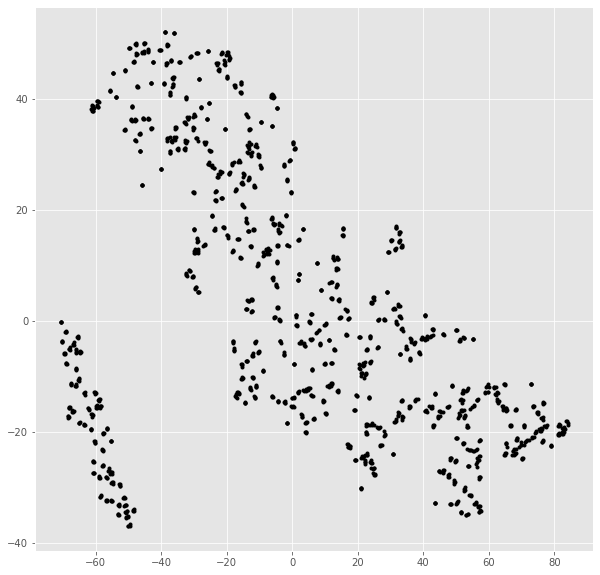

In [150]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x2[:, 0]
coord_y = proj_tsne_x2[:, 1]
ax.plot(coord_x, coord_y, '.k')

<AxesSubplot:xlabel='X', ylabel='Y'>

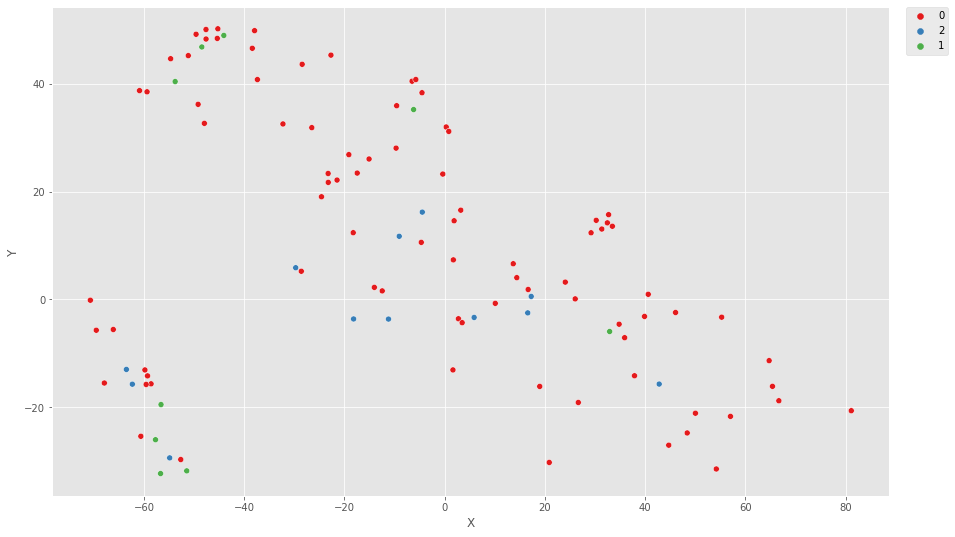

In [151]:
sns.scatterplot(data=tsne_haplo_x2,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### TSNE (x3 - Ratios)

In [152]:
tsne = TSNE(random_state=42)

proj_tsne_x3  = tsne.fit_transform(df_x3)

In [153]:
df_x3.head()

0         1         2         3         4         5         6   \
0  2.256107  0.269761  0.516143  1.322856 -1.280251  0.380014 -0.092006   
1 -0.554716 -0.660628  1.262376 -0.106359  0.474539  1.176758 -1.049702   
2  0.168034 -0.416794 -1.000452 -0.074893 -0.846540 -0.564496  0.602295   
3  1.366566  1.306771 -0.840354  2.319632  3.076478 -2.045869 -0.798635   
4  2.315999  0.490792  0.371351  1.361262 -1.143191  0.505009  0.588356   

         7         8         9         10  
0  0.679067 -0.912693 -0.391159  0.403156  
1 -0.587305  0.988954 -0.391159  0.403156  
2  0.128477 -0.979323 -0.391159  0.403156  
3  2.937666  2.785311 -0.391159  0.403156  
4  0.646876 -1.180774 -0.391159  0.403156

In [154]:
df_tsne_x3= pd.DataFrame(proj_tsne_x3)

In [155]:
df_tsne_x3.head()

0          1
0  -6.140574   0.161147
1  13.714659 -22.309267
2   4.166580  39.508991
3 -49.990147   5.380136
4  -6.381485  -0.147332

In [156]:
tsne_haplo_x3= pd.concat([df_tsne_x3, data["haplogrupos"]], axis=1)

In [157]:
tsne_haplo_x3.columns = ["X","Y","haplogrupos"]

In [158]:
tsne_haplo_x3.head()

X          Y haplogrupos
0  -6.140574   0.161147           0
1  13.714659 -22.309267           2
2   4.166580  39.508991         NaN
3 -49.990147   5.380136         NaN
4  -6.381485  -0.147332         NaN

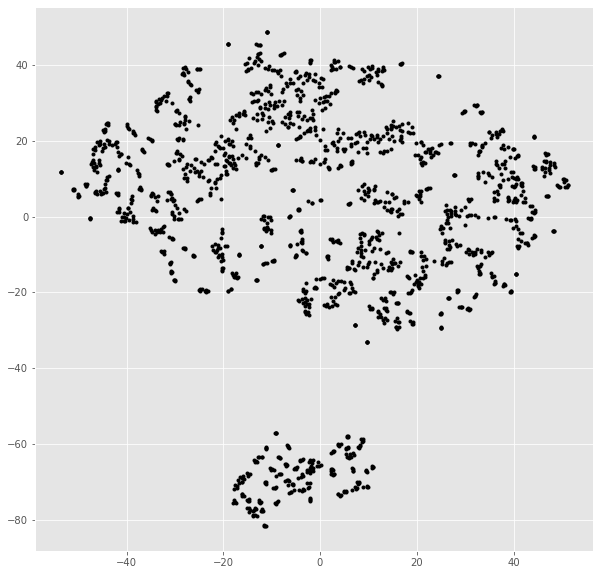

In [159]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x3[:, 0]
coord_y = proj_tsne_x3[:, 1]
ax.plot(coord_x, coord_y, '.k')    

<AxesSubplot:xlabel='X', ylabel='Y'>

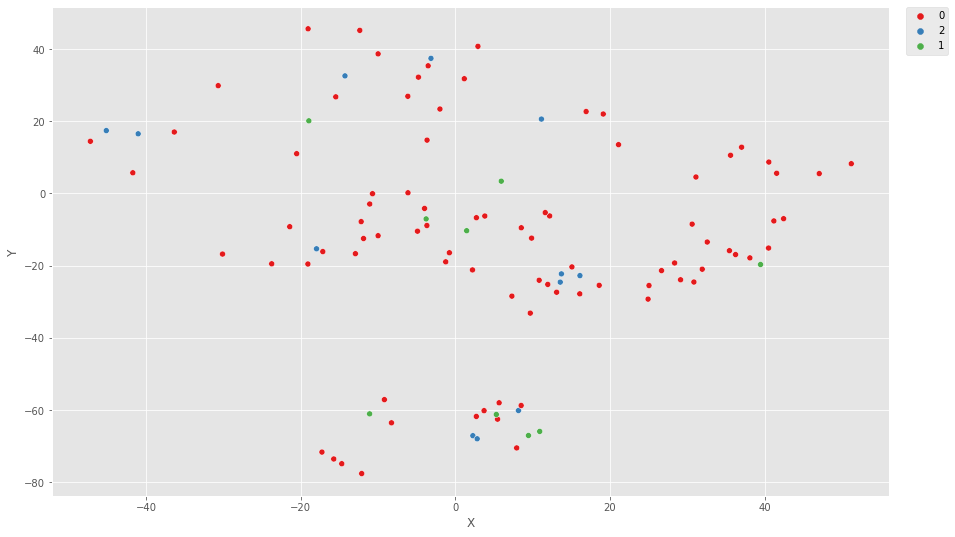

In [160]:
sns.scatterplot(data=tsne_haplo_x3,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### TSNE (x4 - Power Ratios)

In [161]:
tsne = TSNE(random_state=42)

proj_tsne_x4 = tsne.fit_transform(df_x4)

In [162]:
df_x4.head()

0         1         2         3         4         5         6   \
0  2.593865  0.196046  0.366347  1.287535 -1.227032  0.244204 -0.163913   
1 -0.555070 -0.687849  1.222511 -0.266685  0.404190  1.114621 -1.023355   
2 -0.026344 -0.468042 -0.911200 -0.241029 -0.873159 -0.591961  0.542784   
3  1.247298  1.334049 -0.801902  2.946920  3.969806 -1.546420 -0.810370   
4  2.698876  0.424586  0.219086  1.341693 -1.118462  0.370191  0.527867   

         7         8         9         10  
0  0.386974 -0.891833 -0.391159  0.403156  
1 -0.599501  0.942224 -0.391159  0.403156  
2 -0.130316 -0.941083 -0.391159  0.403156  
3  4.657496  3.611463 -0.391159  0.403156  
4  0.352384 -1.084563 -0.391159  0.403156

In [163]:
df_tsne_x4= pd.DataFrame(proj_tsne_x4)

In [164]:
df_tsne_x4.head()

0          1
0 -11.893164  10.720381
1   9.077359  30.481663
2  17.679892 -30.123726
3 -42.478466 -17.042339
4 -11.646595  10.933705

In [165]:
tsne_haplo_x4= pd.concat([df_tsne_x4, data["haplogrupos"]], axis=1)

In [166]:
tsne_haplo_x4.columns = ["X","Y","haplogrupos"]

In [167]:
tsne_haplo_x4.head()

X          Y haplogrupos
0 -11.893164  10.720381           0
1   9.077359  30.481663           2
2  17.679892 -30.123726         NaN
3 -42.478466 -17.042339         NaN
4 -11.646595  10.933705         NaN

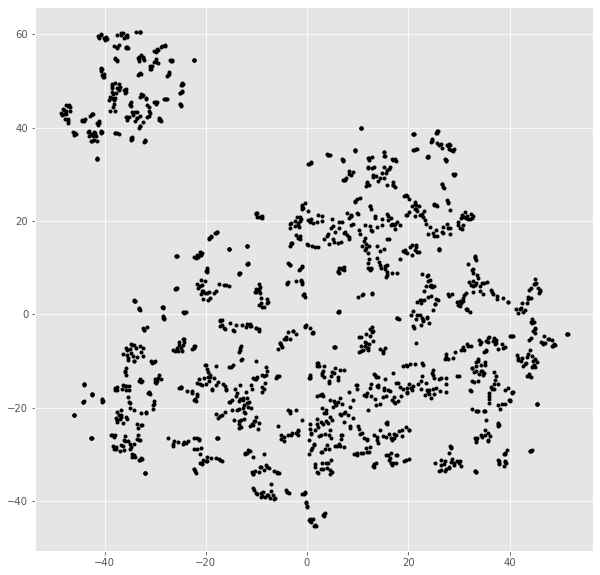

In [168]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x4[:, 0]
coord_y = proj_tsne_x4[:, 1]
ax.plot(coord_x, coord_y, '.k')    

<AxesSubplot:xlabel='X', ylabel='Y'>

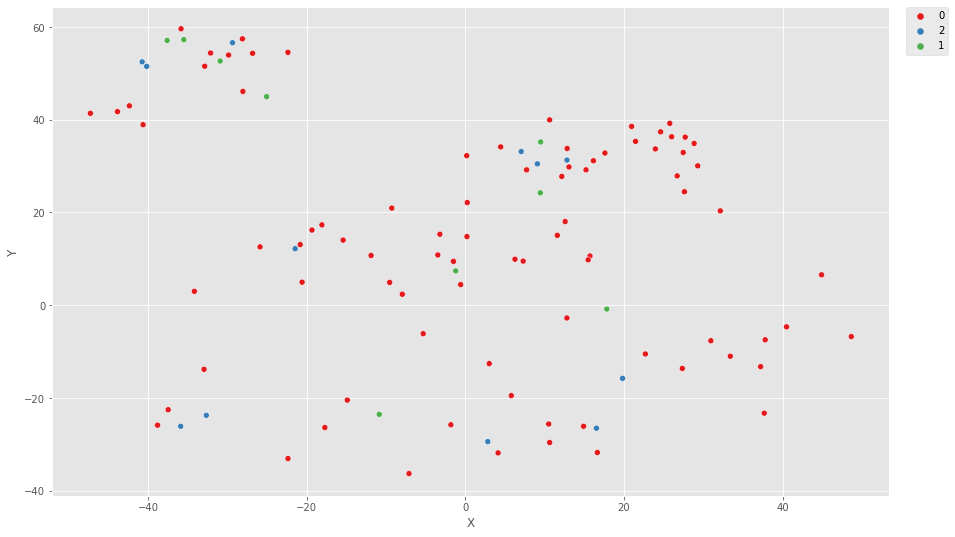

In [169]:
sns.scatterplot(data=tsne_haplo_x4,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### TSNE (x5 - Todas las Futures)

In [170]:
tsne = TSNE(random_state=42)

proj_tsne_x5 = tsne.fit_transform(df_x5)

In [171]:
df_x5.head()

0         1         2         3         4         5         6   \
0 -0.165818  1.238365  0.391905  0.495167  0.321955  0.760541  0.454609   
1 -0.624470 -0.779665 -0.843994 -1.029964 -1.064153 -0.442926 -0.584837   
2 -0.104664  0.016926  0.258016  0.119107  0.427331 -0.180352 -0.115410   
3  0.364181  1.158706 -0.756451 -0.354450 -0.918247 -1.438522  0.991097   
4 -0.176010  1.264918  0.314661  0.495167  0.475967  0.837125  0.488139   

         7         8         9   ...        24        25        26        27  \
0 -0.391159  0.403156  2.256107  ...  0.393611  2.593865  0.196046  0.366347   
1 -0.391159  0.403156 -0.554716  ... -0.652027 -0.555070 -0.687849  1.222511   
2 -0.391159  0.403156  0.168034  ... -0.203236 -0.026344 -0.468042 -0.911200   
3 -0.391159  0.403156  1.366566  ...  1.010564  1.247298  1.334049 -0.801902   
4 -0.391159  0.403156  2.315999  ...  0.430566  2.698876  0.424586  0.219086   

         28        29        30        31        32        33  
0  1.287535 -1.227032  0.244204 -0.163913  0.386974 -0.891833  
1 -0.266685  0.404190  1.114621 -1.023355 -0.599501  0.942224  
2 -0.241029 -0.873159 -0.591961  0.542784 -0.130316 -0.941083  
3  2.946920  3.969806 -1.546420 -0.810370  4.657496  3.611463  
4  1.341693 -1.118462  0.370191  0.527867  0.352384 -1.084563  

[5 rows x 34 columns]

In [172]:
df_tsne_x5= pd.DataFrame(proj_tsne_x5)

In [173]:
df_tsne_x5.head()

0          1
0 -24.221655  -1.935863
1  28.720104  -0.214968
2  -2.075243  -3.181887
3 -21.076075 -47.128918
4 -24.294117  -2.193568

In [174]:
tsne_haplo_x5= pd.concat([df_tsne_x5, data["haplogrupos"]], axis=1)

In [175]:
tsne_haplo_x5.columns = ["X","Y","haplogrupos"]

In [176]:
tsne_haplo_x5.head()

X          Y haplogrupos
0 -24.221655  -1.935863           0
1  28.720104  -0.214968           2
2  -2.075243  -3.181887         NaN
3 -21.076075 -47.128918         NaN
4 -24.294117  -2.193568         NaN

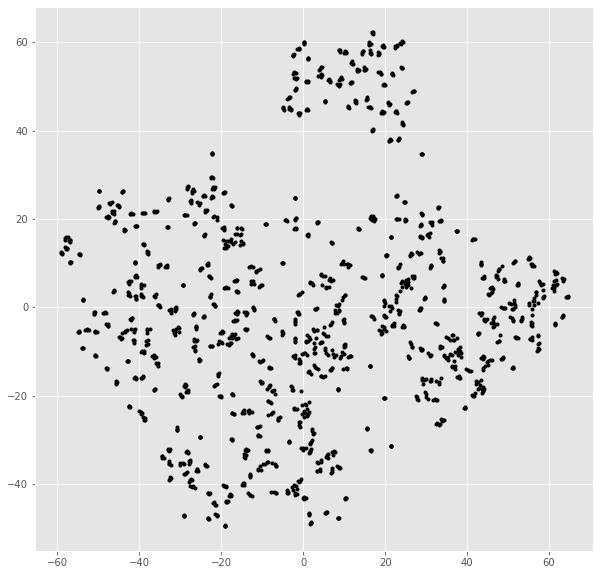

In [177]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x5[:, 0]
coord_y = proj_tsne_x5[:, 1]
ax.plot(coord_x, coord_y, '.k')    

<AxesSubplot:xlabel='X', ylabel='Y'>

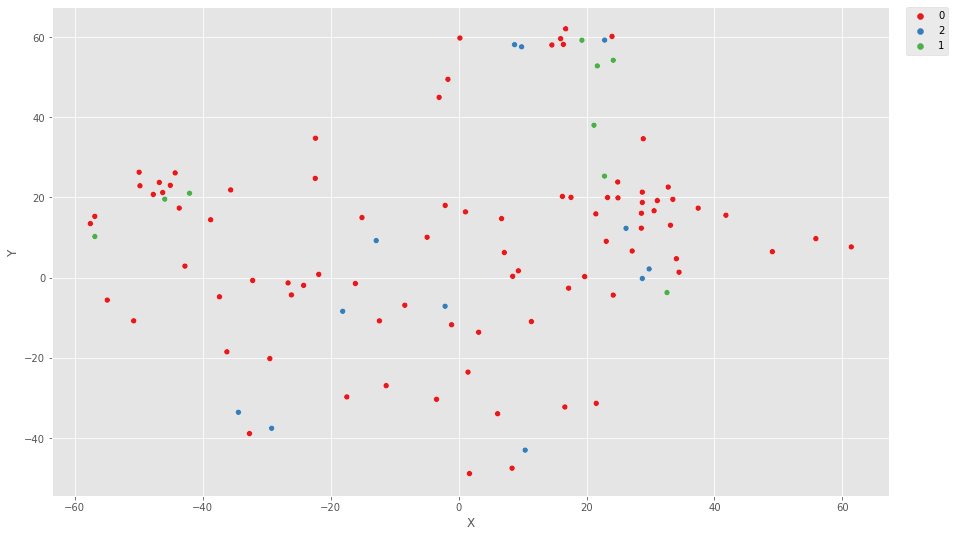

In [178]:
sns.scatterplot(data=tsne_haplo_x5,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Modelos clasificación

In [179]:
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
from sklearn.metrics import accuracy_score

## CART

### CART  (x1 - Medidas)

In [180]:
pca_haplo_x1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          1688 non-null   float64
 1   PC2          1688 non-null   float64
 2   PC3          1688 non-null   float64
 3   PC4          1688 non-null   float64
 4   PC5          1688 non-null   float64
 5   PC6          1688 non-null   float64
 6   PC7          1688 non-null   float64
 7   PC8          1688 non-null   float64
 8   PC9          1688 non-null   float64
 9   haplogrupos  106 non-null    object 
dtypes: float64(9), object(1)
memory usage: 132.0+ KB


In [181]:
nuevo_pca_haplo_x1 = pca_haplo_x1.dropna()

In [182]:
nuevo_pca_haplo_x1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 1664
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   haplogrupos  106 non-null    object 
dtypes: float64(9), object(1)
memory usage: 9.1+ KB


In [183]:
X_PCA = nuevo_pca_haplo_x1[['PC1', 'PC2', 'PC3']]
y_PCA = nuevo_pca_haplo_x1['haplogrupos']

In [184]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevo_pca_haplo_x1['haplogrupos'],random_state=0)

In [185]:
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

<Figure size 1080x540 with 0 Axes>

[Text(336.44117647058823, 382.21875, 'PC2 <= -0.315\ngini = 0.343\nsamples = 79\nvalue = [63, 7, 9]\nclass = 0'),
 Text(180.52941176470586, 331.25625, 'PC3 <= -1.194\ngini = 0.226\nsamples = 55\nvalue = [48, 1, 6]\nclass = 0'),
 Text(114.88235294117646, 280.29375, 'PC2 <= -0.73\ngini = 0.444\nsamples = 3\nvalue = [1, 0, 2]\nclass = 2'),
 Text(82.05882352941175, 229.33124999999998, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]\nclass = 2'),
 Text(147.70588235294116, 229.33124999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]\nclass = 0'),
 Text(246.17647058823528, 280.29375, 'PC2 <= -0.529\ngini = 0.177\nsamples = 52\nvalue = [47, 1, 4]\nclass = 0'),
 Text(213.35294117647058, 229.33124999999998, 'PC2 <= -0.542\ngini = 0.322\nsamples = 26\nvalue = [21, 1, 4]\nclass = 0'),
 Text(131.2941176470588, 178.36875, 'PC1 <= 0.865\ngini = 0.165\nsamples = 22\nvalue = [20, 0, 2]\nclass = 0'),
 Text(65.6470588235294, 127.40625, 'PC1 <= -0.201\ngini = 0.095\nsamples = 20\nvalue = [19, 0, 1]\nclass 

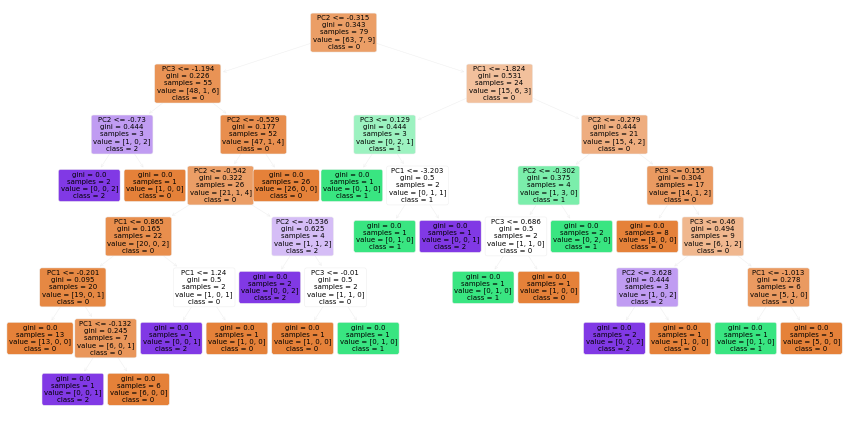

In [186]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns)

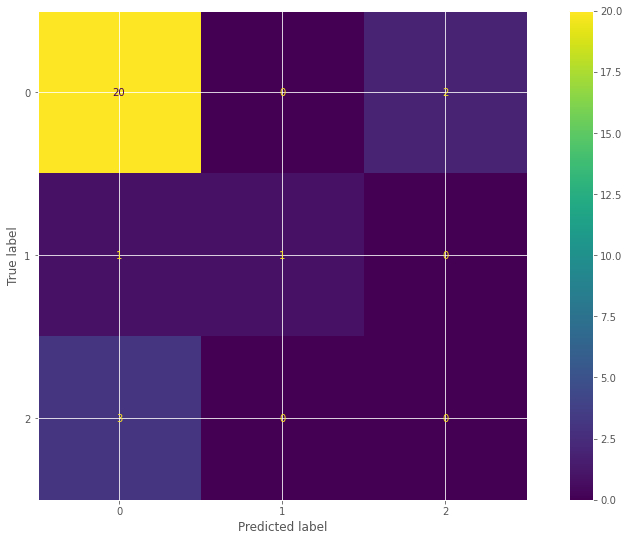

In [187]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [188]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.7777777777777778

### CART (x2 - Powers)

In [189]:
pca_haplo_x2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          1688 non-null   float64
 1   PC2          1688 non-null   float64
 2   PC3          1688 non-null   float64
 3   PC4          1688 non-null   float64
 4   PC5          1688 non-null   float64
 5   PC6          1688 non-null   float64
 6   PC7          1688 non-null   float64
 7   PC8          1688 non-null   float64
 8   PC9          1688 non-null   float64
 9   haplogrupos  106 non-null    object 
dtypes: float64(9), object(1)
memory usage: 132.0+ KB


In [190]:
nuevo_pca_haplo_x2 = pca_haplo_x2.dropna()

In [191]:
nuevo_pca_haplo_x2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 1664
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   haplogrupos  106 non-null    object 
dtypes: float64(9), object(1)
memory usage: 9.1+ KB


In [192]:
X_PCA = nuevo_pca_haplo_x2[['PC1', 'PC2', 'PC3']]
y_PCA = nuevo_pca_haplo_x2['haplogrupos']

In [193]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevo_pca_haplo_x2['haplogrupos'],random_state=0)

In [194]:
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

<Figure size 1080x540 with 0 Axes>

[Text(414.76339285714283, 385.05, 'PC2 <= -0.747\ngini = 0.343\nsamples = 79\nvalue = [63, 7, 9]\nclass = 0'),
 Text(283.98214285714283, 339.75, 'PC3 <= 2.202\ngini = 0.444\nsamples = 3\nvalue = [1, 0, 2]\nclass = 2'),
 Text(254.08928571428572, 294.45, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]\nclass = 2'),
 Text(313.875, 294.45, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]\nclass = 0'),
 Text(545.5446428571429, 339.75, 'PC2 <= 3.505\ngini = 0.318\nsamples = 76\nvalue = [62, 7, 7]\nclass = 0'),
 Text(373.6607142857143, 294.45, 'PC1 <= 4.966\ngini = 0.233\nsamples = 62\nvalue = [54, 4, 4]\nclass = 0'),
 Text(269.0357142857143, 249.15, 'PC2 <= -0.555\ngini = 0.193\nsamples = 57\nvalue = [51, 2, 4]\nclass = 0'),
 Text(179.35714285714286, 203.85, 'PC2 <= -0.558\ngini = 0.278\nsamples = 24\nvalue = [20, 0, 4]\nclass = 0'),
 Text(149.46428571428572, 158.55, 'PC3 <= 0.155\ngini = 0.227\nsamples = 23\nvalue = [20, 0, 3]\nclass = 0'),
 Text(89.67857142857143, 113.25, 'PC2 <= -0.591\ngini = 0.4

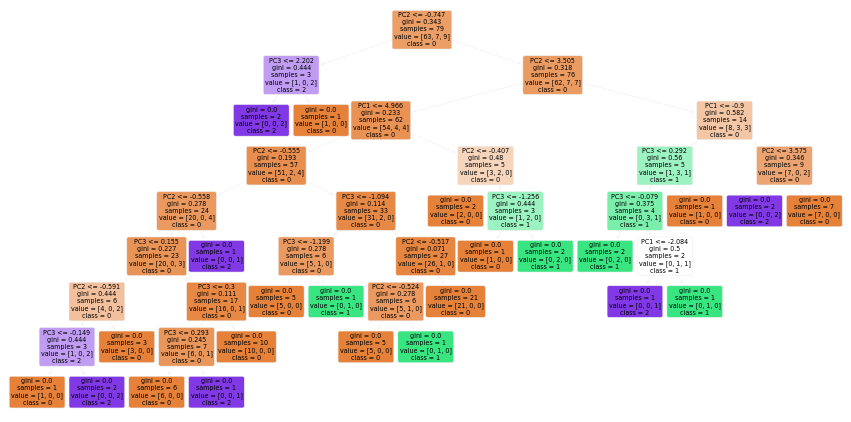

In [195]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns)

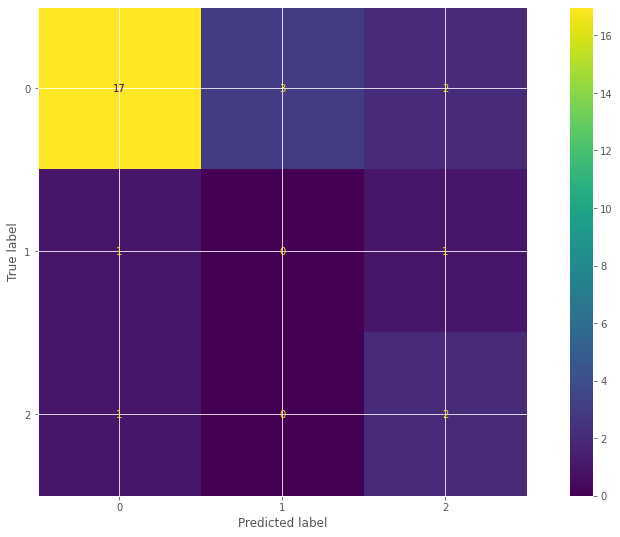

In [196]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [197]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.7037037037037037

### CART (x3 - Ratios)

In [198]:
pca_haplo_x3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          1688 non-null   float64
 1   PC2          1688 non-null   float64
 2   PC3          1688 non-null   float64
 3   PC4          1688 non-null   float64
 4   PC5          1688 non-null   float64
 5   PC6          1688 non-null   float64
 6   PC7          1688 non-null   float64
 7   PC8          1688 non-null   float64
 8   PC9          1688 non-null   float64
 9   PC10         1688 non-null   float64
 10  PC11         1688 non-null   float64
 11  haplogrupos  106 non-null    object 
dtypes: float64(11), object(1)
memory usage: 158.4+ KB


In [199]:
nuevo_pca_haplo_x3 = pca_haplo_x3.dropna()

In [200]:
nuevo_pca_haplo_x3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 1664
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   PC10         106 non-null    float64
 10  PC11         106 non-null    float64
 11  haplogrupos  106 non-null    object 
dtypes: float64(11), object(1)
memory usage: 10.8+ KB


In [201]:
X_PCA = nuevo_pca_haplo_x3[['PC1', 'PC2', 'PC3', 'PC4','PC5']]
y_PCA = nuevo_pca_haplo_x3['haplogrupos']

In [202]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevo_pca_haplo_x3['haplogrupos'],random_state=0)

In [203]:
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

<Figure size 1080x540 with 0 Axes>

[Text(548.0357142857142, 385.05, 'PC5 <= 0.351\ngini = 0.343\nsamples = 79\nvalue = [63, 7, 9]\nclass = 0'),
 Text(338.7857142857143, 339.75, 'PC1 <= -2.669\ngini = 0.491\nsamples = 46\nvalue = [31, 6, 9]\nclass = 0'),
 Text(159.42857142857142, 294.45, 'PC5 <= -0.884\ngini = 0.66\nsamples = 10\nvalue = [3, 4, 3]\nclass = 1'),
 Text(79.71428571428571, 249.15, 'PC2 <= 0.463\ngini = 0.32\nsamples = 5\nvalue = [1, 4, 0]\nclass = 1'),
 Text(39.857142857142854, 203.85, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]\nclass = 0'),
 Text(119.57142857142856, 203.85, 'gini = 0.0\nsamples = 4\nvalue = [0, 4, 0]\nclass = 1'),
 Text(239.1428571428571, 249.15, 'PC3 <= 2.316\ngini = 0.48\nsamples = 5\nvalue = [2, 0, 3]\nclass = 2'),
 Text(199.28571428571428, 203.85, 'PC2 <= 3.628\ngini = 0.444\nsamples = 3\nvalue = [2, 0, 1]\nclass = 0'),
 Text(159.42857142857142, 158.55, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]\nclass = 0'),
 Text(239.1428571428571, 158.55, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]

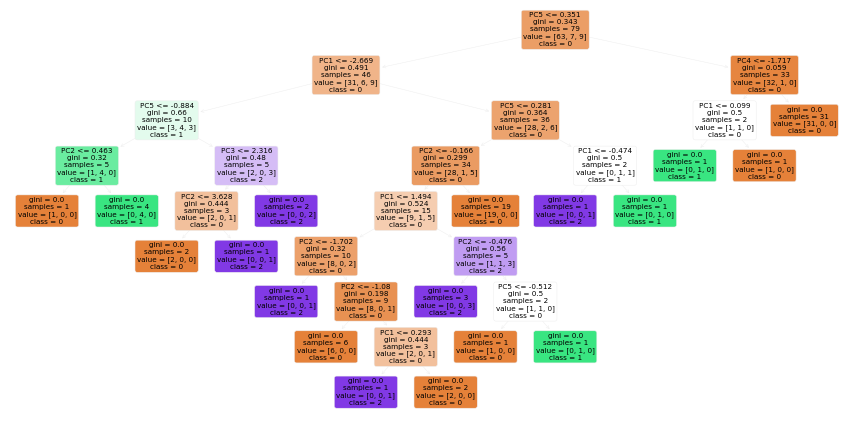

In [204]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns)

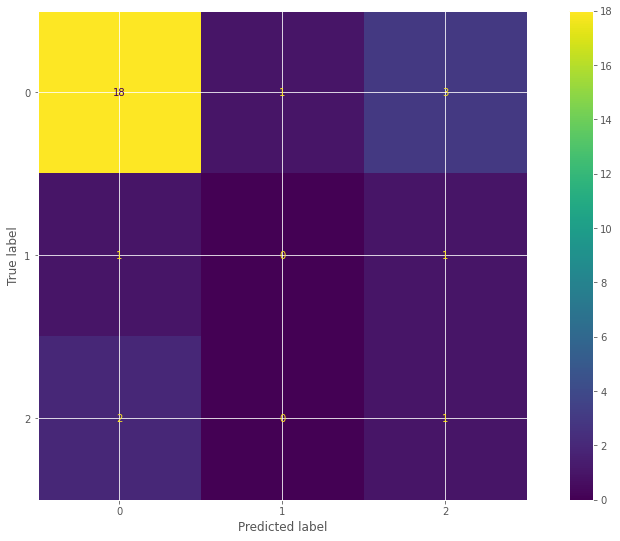

In [205]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [206]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.7037037037037037

### CART - (x4 - Powers Ratios)

In [207]:
pca_haplo_x4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          1688 non-null   float64
 1   PC2          1688 non-null   float64
 2   PC3          1688 non-null   float64
 3   PC4          1688 non-null   float64
 4   PC5          1688 non-null   float64
 5   PC6          1688 non-null   float64
 6   PC7          1688 non-null   float64
 7   PC8          1688 non-null   float64
 8   PC9          1688 non-null   float64
 9   PC10         1688 non-null   float64
 10  PC11         1688 non-null   float64
 11  haplogrupos  106 non-null    object 
dtypes: float64(11), object(1)
memory usage: 158.4+ KB


In [208]:
nuevo_pca_haplo_x4 = pca_haplo_x4.dropna()

In [209]:
nuevo_pca_haplo_x4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 1664
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   PC10         106 non-null    float64
 10  PC11         106 non-null    float64
 11  haplogrupos  106 non-null    object 
dtypes: float64(11), object(1)
memory usage: 10.8+ KB


In [210]:
X_PCA = nuevo_pca_haplo_x4[['PC1', 'PC2', 'PC3', 'PC4','PC5']]
y_PCA = nuevo_pca_haplo_x4['haplogrupos']

In [211]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevo_pca_haplo_x4['haplogrupos'],random_state=0)

In [212]:
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

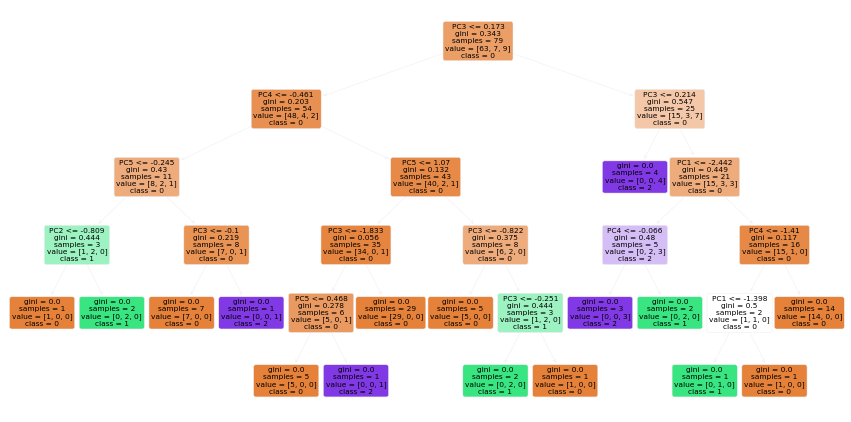

In [213]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns); 

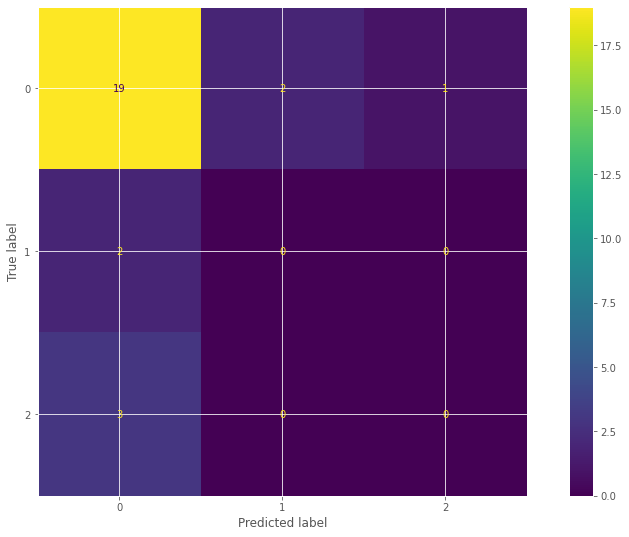

In [214]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [215]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.7037037037037037

### CART (x5 - Todas las Futures)

In [216]:
pca_haplo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          1688 non-null   float64
 1   PC2          1688 non-null   float64
 2   PC3          1688 non-null   float64
 3   PC4          1688 non-null   float64
 4   PC5          1688 non-null   float64
 5   PC6          1688 non-null   float64
 6   PC7          1688 non-null   float64
 7   PC8          1688 non-null   float64
 8   PC9          1688 non-null   float64
 9   PC10         1688 non-null   float64
 10  PC11         1688 non-null   float64
 11  PC12         1688 non-null   float64
 12  PC13         1688 non-null   float64
 13  PC14         1688 non-null   float64
 14  PC15         1688 non-null   float64
 15  PC16         1688 non-null   float64
 16  PC17         1688 non-null   float64
 17  PC18         1688 non-null   float64
 18  CP19         1688 non-null   float64
 19  PC20  

In [217]:
nuevo_pca_haplo = pca_haplo.dropna()

In [218]:
nuevo_pca_haplo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 1664
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   PC10         106 non-null    float64
 10  PC11         106 non-null    float64
 11  PC12         106 non-null    float64
 12  PC13         106 non-null    float64
 13  PC14         106 non-null    float64
 14  PC15         106 non-null    float64
 15  PC16         106 non-null    float64
 16  PC17         106 non-null    float64
 17  PC18         106 non-null    float64
 18  CP19         106 non-null    float64
 19  PC20   

In [219]:
X_PCA = nuevo_pca_haplo[['PC1', 'PC2', 'PC3', 'PC4','PC5']]
y_PCA = nuevo_pca_haplo['haplogrupos']

In [220]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevo_pca_haplo['haplogrupos'],random_state=0)

In [221]:
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

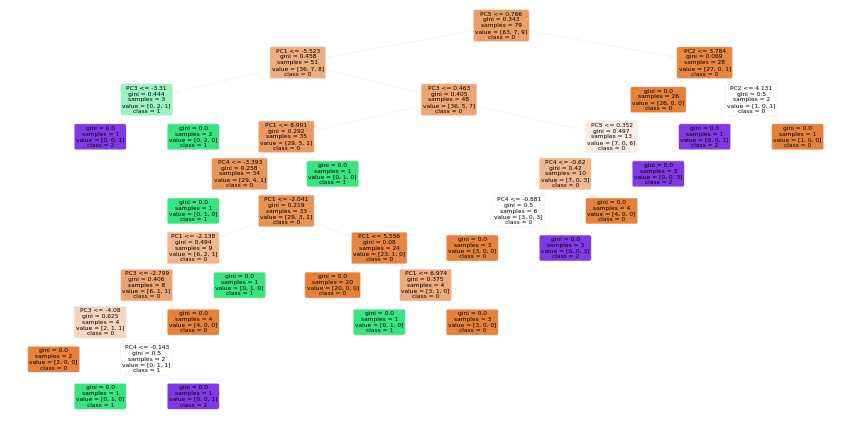

In [222]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns); 

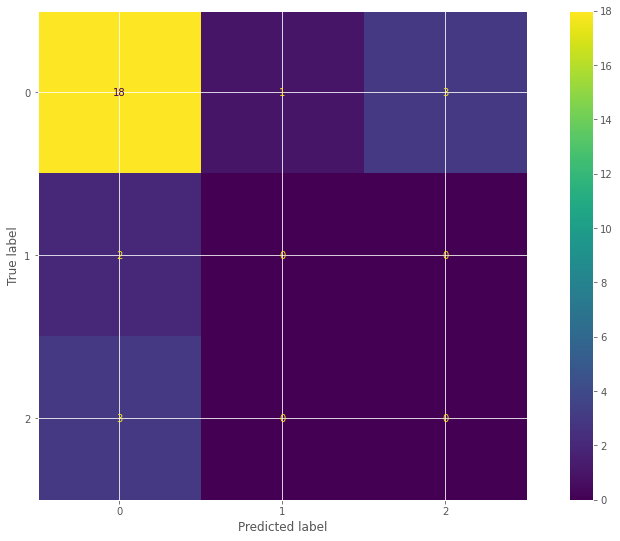

In [223]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [224]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.6666666666666666

## XGBoost

In [225]:
from xgboost import XGBClassifier


In [226]:
y_train_PCA = y_train_PCA.astype("int")

In [227]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train_PCA)
y_train_PCA = le.transform(y_train_PCA)

LabelEncoder()

In [228]:
xgboost = XGBClassifier()

In [229]:
clf_XGB = xgboost.fit(X_train_PCA,y_train_PCA)

In [231]:
#accuracy_score(le.transform(y_test_PCA), xgboost.predict(X_test_PCA))

# Modelos con Dataset de PCA

## Kmeans

In [232]:
x5 = pca_haplo[['PC1', 'PC2', 'PC3', 'PC4','PC5']]
y_true = pca_haplo['haplogrupos']

scaler = StandardScaler()
x5_scaled=scaler.fit_transform(x5)

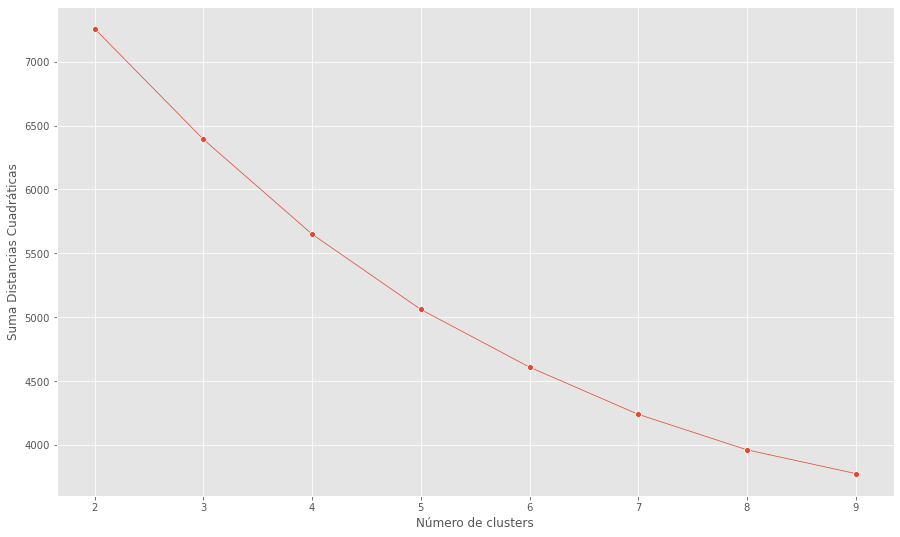

In [233]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x5_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

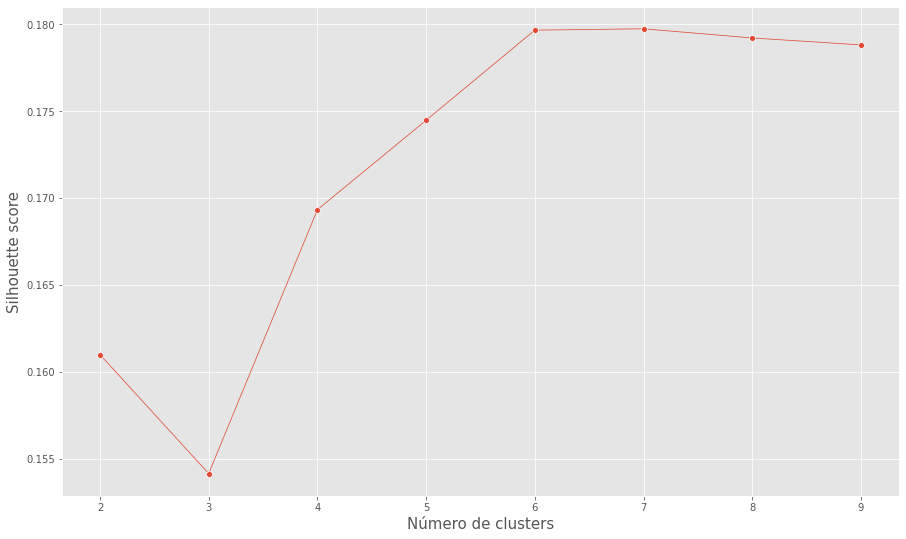

In [234]:
#x5_scaled todo
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x5_scaled)
    score=silhouette_score(x5_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

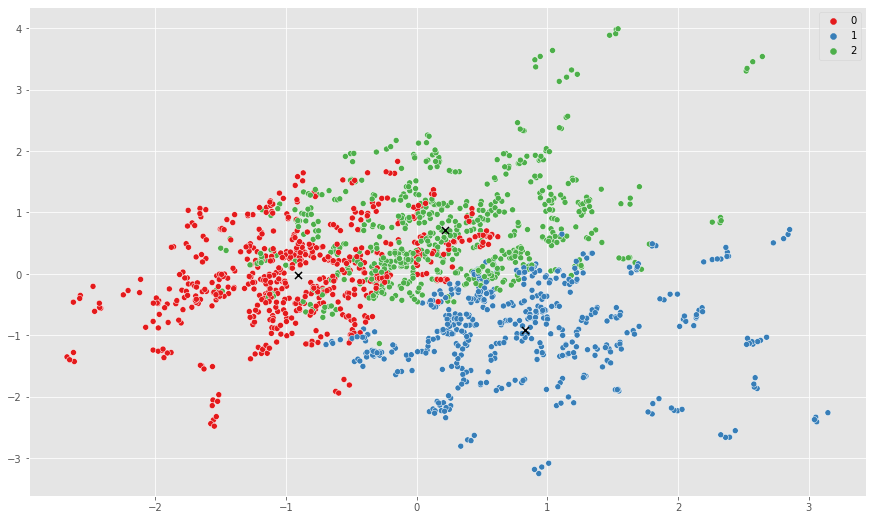

In [235]:
#x5_scaled todo
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x5_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x5_scaled[:,0],y=x5_scaled[:,1],hue=labels,legend='full', palette="Set1");

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

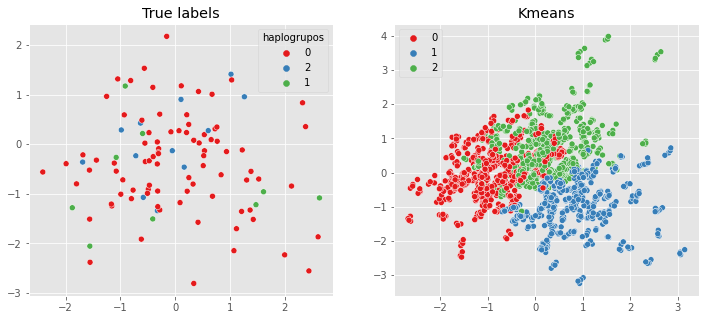

In [236]:
#x5_scaled todos
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

## DBSCAN

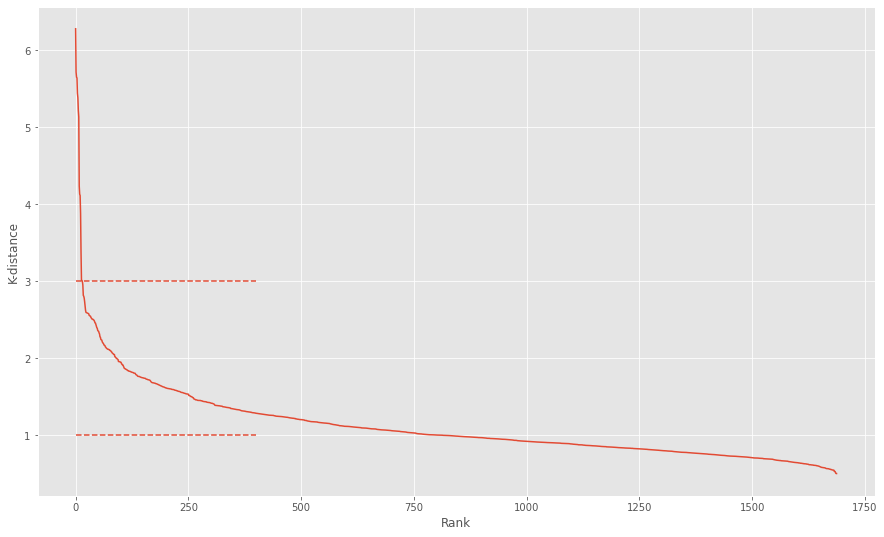

In [238]:
#x5_scaled todos
minPts=20;
k=minPts-1;

D=squareform(pdist(x5_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([1,3],0,400,linestyles='dashed');

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'DBSCAN')

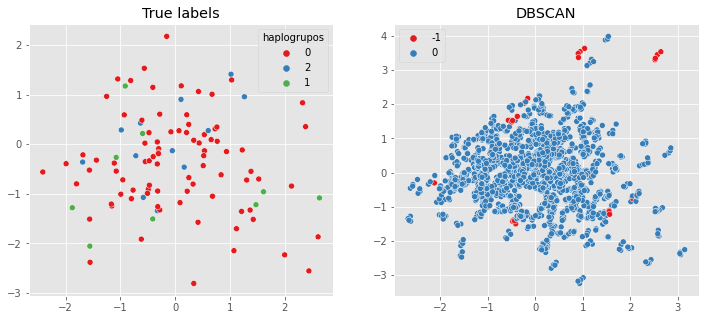

In [239]:
#x5_scaled todos
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x5_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN')

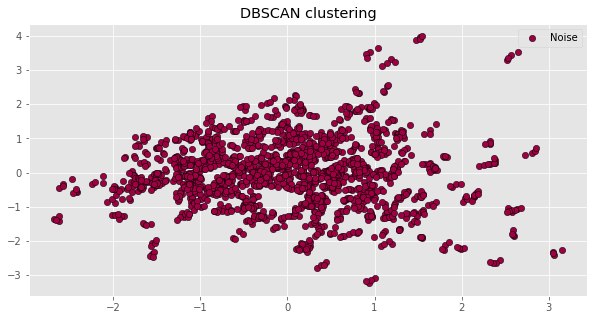

In [240]:
#x5_scaled todos
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x5_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x5_scaled[labels==l,0], x5_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x5_scaled[labels==l,0], x5_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');

## TSNE

In [241]:
df_x5 = pd.DataFrame(x5_scaled)

In [242]:
tsne = TSNE(random_state=42)

proj_tsne_x5 = tsne.fit_transform(df_x5)

In [243]:
df_x5.head()

0         1         2         3         4
0  0.529743  0.192686  0.416489  2.105834  1.821803
1 -0.984788  0.286703 -1.140888 -0.454824  0.330836
2  0.009733 -0.288719  1.177662 -0.322966  0.373813
3  1.185012  3.320218 -0.734536 -1.012003 -0.304225
4  0.591200  0.137754  0.736831  2.396665  1.465694

In [244]:
df_tsne_x5= pd.DataFrame(proj_tsne_x5)

In [245]:
df_tsne_x5.head()

0          1
0  10.977847  35.262524
1  35.864437  13.875610
2 -18.476234 -18.032030
3  -4.297182 -16.053015
4  11.043426  34.701679

In [246]:
tsne_haplo_x5= pd.concat([df_tsne_x5, data["haplogrupos"]], axis=1)

In [247]:
tsne_haplo_x5.columns = ["X","Y","haplogrupos"]

In [248]:
tsne_haplo_x5.head()

X          Y haplogrupos
0  10.977847  35.262524           0
1  35.864437  13.875610           2
2 -18.476234 -18.032030         NaN
3  -4.297182 -16.053015         NaN
4  11.043426  34.701679         NaN

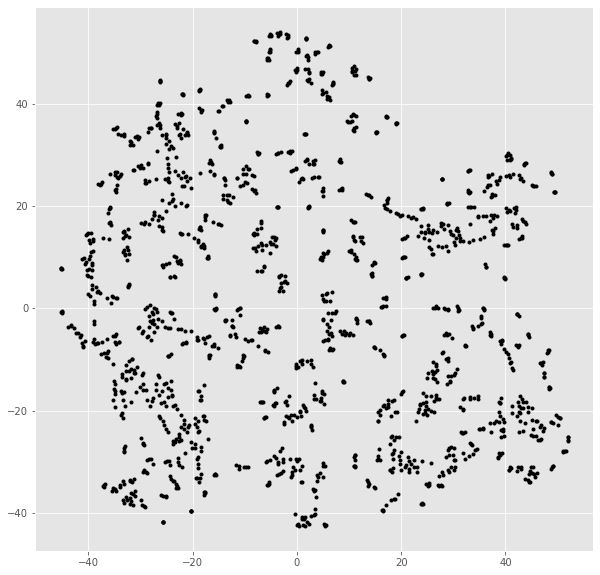

In [249]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x5[:, 0]
coord_y = proj_tsne_x5[:, 1]
ax.plot(coord_x, coord_y, '.k')    

<AxesSubplot:xlabel='X', ylabel='Y'>

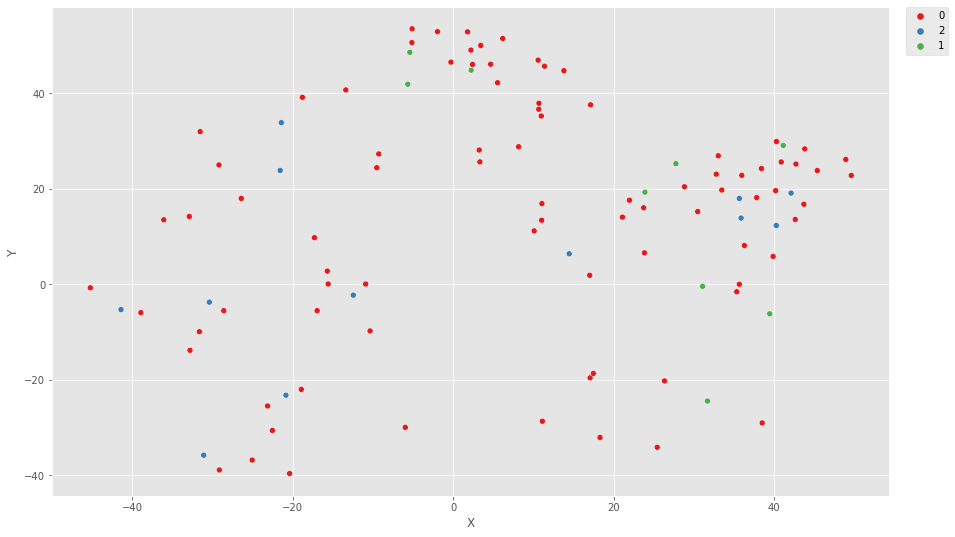

In [250]:
sns.scatterplot(data=tsne_haplo_x5,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)